# BIA 6303 - Predictive Models, Fall B 2019
# Final Project
### by Sara Lienau

# Introduction
I have volunteered quite a bit at animal shelters.  I was excited to find a data set on Kaggle that would overlap with my domain knowledge from that experience.  The Kaggle competition revolved around predicting how quickly animals would be adopted based on information available from the profile on the Pet Finder adoption site.

In my experience, shelter staff members usually have developed an intuitive model of the adoption speed of animals under their care.  They know cute puppies and kittens will be adopted quickly.  And it may take more time to find the right home for older animals, large dogs or shy pets, for example.

I thought it would be a worthy project to try and encapsulate this knowledge in a classification model and experiment with the techniques introduced in class.

## Business Problem
It would be valuable to animal shelters to have a model that could accurately predict how quickly an animal will be adopted.

You can think of the core process of an animal shelter as managing perishable inventory.  The purpose of an animal shelter is to provide temporary housing and care until a long-term home can be found.  Shelters need to understand the turnover rate of their inventory – how quickly animals move through the shelter to effectively serve as many animals as possible.  Adoption speed is highly variable across the animals in a shelter; thus, animals often do not move through the shelter at the same rate.

An important concept is to manage the shelter’s “capacity for care.”  That is, the number of animals the shelter can humanely care for given the available cage space, hours of labor to tend to the animals and other resources such as food and medical supplies.

If you could predict how quickly an animal is likely to be adopted, then you have a key variable in managing capacity for care (called length of stay).  This would help the shelter understand when space will likely open up and the shelter can accept more animals.  Or if the mix of quick versus slow adoption animals gets out of balance, perhaps the shelter needs to run a promotion to offer free or low-cost adoptions (basically have a sale).  Or the predicted speed of adoption (length of stay) might inform how to care for the animal. Extended stay residents might be placed in more appropriate long-term housing and assigned to volunteers to do training and enrichment activities.

Thus, working on a model to predict adoption speed is a worthwhile endeavor beyond the opportunity to experiment with classification algorithms.

## Data Source and Description
I obtained the data for my project from a Kaggle competition: **PetFinder.my Adoption Prediction** (https://www.kaggle.com/c/petfinder-adoption-prediction/overview ).

PetFinder.my has been Malaysia’s leading animal welfare platform since 2008, with a database of more than 150,000 animals.  Animal adoption rates are strongly correlated to the metadata associated with their online profiles, such as descriptive text and photo characteristics. 

The goal of the Kaggle competition was to develop a model to predict how quickly a pet is adopted based on characteristics of its online profile.

The competition provided training data for **14,993 pet profiles, with the known adoption speed, and 19 tabular attributes about the pet and its online profile**.

The text of the description within the pet's profile was processed by *Google’s Natural Language API* to provide information on sentiment and key entities within the description.  

**Available Attributes**
- Adoption Speed – the same day as profile posted, within the 1st week, within the 1st month, 2-3 months or 4 or more months.
- PetID - unique ID of pet profile
- Type - the type of animal – dog or cat
- Name - name of pet, if provided
- Age - the age of the pet (when listed), in months
- Breed - primary and secondary breed, if mixed breed
- Gender - male, female and mixed when the profile represents a group of pets (e.g., a litter of puppies).
- Color - primary, secondary and tertiary color, where applicable
- Size at Maturity - small, medium, large, extra-large or not specified
- Length of Fur - short, medium, long or not specified
- Vaccinated - pet has been vaccinated – yes, no, not sure
- Dewormed - pet has been dewormed – yes, no, not sure
- Sterilized - pet has been spayed/neutered – yes, no, not sure
- Condition of Health - healthy, minor injury, serious injury, not specified
- Quantity - number of pets available for adoption in the profile
- Fee - adoption fee, if any (0 = free)
- RescuerID - unique ID of rescuer
- Videos - total uploaded videos for the pet
- Photos - total uploaded photos for the pet
- Description - Profile write-up for this pet. The primary language used is English with some in Malay or Chinese.

(*Note: The competition also provided the photos from the pet profile and information from running the images through Google’s Vision API to provide analysis of Face Annotations, Label Annotations, Text Annotations, and Image Properties.  I did not incorporate any information from the analysis of the photos associated with the profiles.  It requires more thought on how to engineer useful features out of the information available.*)

<a id="TOC"></a>
# Table of Contents

- [Setup Notebook](#Setup)
- [Load Data](#LoadData)
- [Exploratory Data Analysis](#EDA)
- [Data Preprocessing](#Preprocess)
- [Split Data](#Split)
- [Models and Tuning](#models)
  - [Decision Tree](#model_decision_tree)
  - [KNN](#model_knn)
  - [Random Forest](#model_random_forest)
  - [Extra-Trees](#model_extra_trees)
  - [Support Vector Machines - Linear](#model_svm_linear)
  - [Support Vector Machines - RBF](#model_svm_rbf)
  - [Stochastic Gradient Descent](#model_sgd)
  - [Bagging Classifier](#model_bagclf)
  - [AdaBoost](#model_ada)
  - [Gradient Tree Boosting](#model_grad_tree_boosting)
  - [Stacking](#model_stack)
  - [Neural Network](#model_ann)
- [Discussion of Results](#Results)

<a id="Setup"></a>
# Setup Notebook
[Table of Contents](#TOC)

## Standard Imports

In [1]:
%matplotlib inline

# standard libraries
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json

pd.set_option('display.max_colwidth', 250) #important for getting all the text

# from Scikit Learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import sys
print("The Python version is %s.%s.%s" % sys.version_info[:3])

The Python version is 3.7.3


## Reload Data to Start Modeling
Code to reload the split datasets from a file as I work through the different algorithms.  This just saves the effort of running through all the preprocessing steps over and over again.

**This code can be uncommented when needed.  Initially, the code should be commented out.**

In [2]:
RANDOM_SEED = 114

# #------------------------------------------------------------
# # reload result from file to start modeling section
# #------------------------------------------------------------
# npzfile = np.load('split_data.npz')

# #npzfile.files
# features_train = npzfile['arr_0']
# features_test  = npzfile['arr_1']
# target_train   = npzfile['arr_2']
# target_test    = npzfile['arr_3']
# feature_labels = npzfile['arr_4']

# print("TRAINING")
# print("-- Features shape: ", features_train.shape)
# print("-- Target   shape: ", target_train.shape)
# print("-- Class   counts: ", np.bincount(target_train))

# print("\nTESTING")
# print("-- Features shape: ", features_test.shape)
# print("-- Target   shape: ", target_test.shape)
# print("-- Class   counts: ", np.bincount(target_test))

TRAINING
-- Features shape:  (10495, 75)
-- Target   shape:  (10495,)
-- Class   counts:  [2450 2826 2281 2938]

TESTING
-- Features shape:  (4498, 75)
-- Target   shape:  (4498,)
-- Class   counts:  [1050 1211  978 1259]


# My Function Library

### Modeling Functions
The following are functions I uses to consolidate repeated steps in multinomial classification problems.

In [3]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer 
from sklearn.model_selection import cross_validate, GridSearchCV

#------------------------------------------------------------
# Multinomial Classification (clfmulti) Assess Model
#------------------------------------------------------------
def clfmulti_assess_model(clf, model_label, test_features, test_target, 
                          print_output=True):

    #------------------------------------------------------------
    # predict using the test set
    #------------------------------------------------------------
    predict_target = clf.predict(test_features)
    
    #------------------------------------------------------------
    # collect metric for classifier
    #------------------------------------------------------------
    metric_accuracy   = np.round(accuracy_score(test_target, predict_target) * 100, 2)
    metric_cohenkappa = np.round(cohen_kappa_score(test_target, predict_target, weights='quadratic'), 4)
    metric_confmat    = confusion_matrix(test_target, predict_target)
    class_report      = classification_report(test_target, predict_target, output_dict=True)
    

    #------------------------------------------------------------
    # collect metric for each class
    #------------------------------------------------------------
    class_cf_dict = {}
    class_tpr = [] 
    class_ppv = []
    
    for true_class in range(metric_confmat.shape[0]):
        class_cf_dict[true_class] = {'TP': 0, 'FP' : 0, 'FN' : 0} 
        
        class_tpr.append(np.round(class_report[str(true_class)]['recall']    * 100, 2))
        class_ppv.append(np.round(class_report[str(true_class)]['precision'] * 100, 2))

    for true_class in range(metric_confmat.shape[0]):
        for pred_class in range(metric_confmat.shape[1]):
            if (true_class == pred_class):
                class_cf_dict[true_class]['TP'] = metric_confmat[true_class, pred_class]
            elif(pred_class != true_class):
                class_cf_dict[pred_class]['FP'] = class_cf_dict[pred_class]['FP'] + metric_confmat[true_class, pred_class]
                class_cf_dict[true_class]['FN'] = class_cf_dict[true_class]['FN'] + metric_confmat[true_class, pred_class]

    data={'Method'     :model_label,
          'Accuracy'   :metric_accuracy, 
          'CohenKappa' :metric_cohenkappa,
          'TPR_0'      :class_tpr[0],
          'TPR_1'      :class_tpr[1],
          'TPR_2'      :class_tpr[2],
          'TPR_3'      :class_tpr[3],
          'PPV'        :class_ppv,
          'TP'         :[class_cf_dict[0]['TP'], class_cf_dict[1]['TP'], 
                         class_cf_dict[2]['TP'], class_cf_dict[3]['TP']],
          'FP'         :[class_cf_dict[0]['FP'], class_cf_dict[1]['FP'], 
                         class_cf_dict[2]['FP'], class_cf_dict[3]['FP']],
          'FN'         :[class_cf_dict[0]['FN'], class_cf_dict[1]['FN'], 
                         class_cf_dict[2]['FN'], class_cf_dict[3]['FN']],
          'Parameters' :clf.get_params()}
    
    if(print_output):
        print()
        print("Accuracy      : %0.2f" % metric_accuracy)
        print("Cohen's Kappa : %0.4f" % metric_cohenkappa)

        print()
        print("Classification Report")
        print(classification_report(test_target, predict_target))

        # plot confusion matrix
        fig, ax = plt.subplots(figsize=(2.5, 2.5))
        ax.matshow(metric_confmat, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(metric_confmat.shape[0]):
            for j in range(metric_confmat.shape[1]):
                ax.text(x=j, y=i, s=metric_confmat[i, j], va='center', ha='center')

        plt.title('Confusion Matrix\n')
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.show()

    return data

#------------------------------------------------------------
# Multinomial Classification (clfmulti) / Cross Validation
#------------------------------------------------------------
def clfmulti_cross_validate(clf, features, target, cv_folds=5, print_output=True):
    
    #------------------------------------------------------------
    # define metrics for classifiers
    # cross validate
    #------------------------------------------------------------
    scoring = {'Accuracy'   : 'accuracy',
               'CohenKappa' : make_scorer(cohen_kappa_score, weights='quadratic')}

    cv_scores = cross_validate(clf, X=features, y=target,
                            cv=cv_folds, scoring=scoring,
                            return_train_score=False)

    #------------------------------------------------------------
    # extract metrics from using of test data in each CV fold
    # - capture data to add to results dataframe,
    # - output info if desired
    #------------------------------------------------------------
    metric_scores = {}

    for metric in scoring.keys():
        scores = cv_scores['test_' + metric]
        
        if (metric=='CohenKappa'):
            metric_mean = np.round(np.mean(scores), 3) 
            metric_std  = np.round(np.std(scores),  3)
            scores      = np.round(scores, 3)
        else:
            metric_mean = np.round(np.mean(scores) * 100, 2) 
            metric_std  = np.round(np.std(scores)  * 100, 2) 
            scores      = np.round(scores * 100, 2)
        
        metric_scores[metric] = (metric_mean, metric_std)
        
        if(print_output):
            print('\nCV {0}: {1:.3f} +/- {2:.3f}'.format(metric, metric_mean, metric_std))
            print('Scores:', scores)

            plt.figure(figsize=(5,0.75))
            sns.boxplot(x=scores)
            plt.show()
            
    return metric_scores

#------------------------------------------------------------
# Multinomial Classification (clfmulti) / collect_results
#------------------------------------------------------------
def clfmulti_collect_results(results_list, model_results_data):
    results_list.append(model_results_data)
    
    column_names = model_results_data.keys()
    
    return pd.DataFrame(results_list, columns=column_names)


#------------------------------------------------------------
# Multinomial Classification (clfmulti) / fit, assess and optionally CV results
#------------------------------------------------------------
def clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                           trng_features, trng_target,
                           test_features, test_target,
                           cv_folds=5, skip_cv=False):
    #------------------------------------------------------------
    # train/fit model
    #------------------------------------------------------------
    model = model.fit(trng_features, trng_target)

    #------------------------------------------------------------
    # assess model - get/print Accuracy, Recall, Precision, Confusion Matrix
    # then CV and look at mean/std of Accuracy, Recall, Precision, AUC
    #------------------------------------------------------------
    results = clfmulti_assess_model(model, model_label, test_features, test_target)
    if (skip_cv):
        results['CV'] = None
    else:
        results['CV'] = clfmulti_cross_validate(model, trng_features, trng_target, cv_folds=cv_folds)

    results_df    = clfmulti_collect_results(model_results_list, results)
    
    return results_df

#------------------------------------------------------------
# Multinomial Classification (clfmulti) / common steps in Grid Search
#------------------------------------------------------------
def clfmulti_grid_search(clf, train_features, train_target,
                    param_grid, best_metric='CohenKappa', cv_folds=5,
                    return_train_score=True, n_jobs=-1
                    ):
    scoring = {'Accuracy'   : 'accuracy',
               'CohenKappa' : make_scorer(cohen_kappa_score, weights='quadratic')}

    gs = GridSearchCV(estimator=clf, param_grid=param_grid,
                      scoring=scoring, refit=best_metric, 
                      return_train_score=return_train_score,
                      cv=cv_folds, n_jobs=n_jobs,
                      iid=False)

    gs = gs.fit(train_features, train_target)

    return gs

#------------------------------------------------------------
# plot_grid_search_results
# - plot_dataset='Both', 'Training' or 'Test'
#------------------------------------------------------------
def plot_grid_search_results(grid_search_results,  
                             param_name,
                             metrics=['Accuracy', 'CohenKappa'], 
                             plot_dataset='Both'):
    datasets = [] #[('train', '--'), ('test', '-')]
    if (plot_dataset in ['Both', 'Training']):
        datasets.append(('train', '--'))
    if (plot_dataset in ['Both', 'Test']):
         datasets.append(('test', '-'))

    title = 'GridSearchCV: {0}'.format(grid_search_results['param_'+param_name].data)
    plt.title(title,
              fontsize=12)

    plt.xlabel(param_name)
    plt.ylabel("Score")

    ax = plt.gca()
    #ax.set_xlim(0, 402)
    #ax.set_ylim(0.01, 0.15)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(grid_search_results['param_'+param_name].data, dtype=float)

    for scorer, color in zip(metrics, ['g', 'k', 'r']):
        for sample, style in datasets:
            sample_score_mean = grid_search_results['mean_%s_%s' % (sample, scorer)]
            sample_score_std  = grid_search_results['std_%s_%s'  % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(grid_search_results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = grid_search_results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()
    

#------------------------------------------------------------
# plot_coefficients
#------------------------------------------------------------
def clfmulti_plot_coefficients(coefficients, y_limits=(1,1)):
    plt.figure(figsize=(12,8))
    for class_idx in range(coefficients.shape[0]):
        #print("Class {} Features with Non-Zero Weight: {}".format(class_idx,(coefficients[class_idx] != 0).sum()))
        plt.subplot(2,2, class_idx+1)
        plt.plot(coefficients[class_idx], label=str(class_idx))
        plt.axhline(linewidth=1, color='r') # for reference
        plt.ylim(y_limits)
        plt.title("Class {} - ({} Features w/Non-Zero Weight)".format(class_idx, 
                                                                      (coefficients[class_idx] != 0).sum()),
                  loc='left')

### EDA and Data Preprocessing Functions
Load, from a file, a few functions I created for EDA and data preprocessing steps.

In [4]:
%run my_functions_eda_prep.py

<a id="LoadData"></a>
# Load Data
[Table of Contents](#TOC)

In [5]:
data_directory = '../ProjectData/'

data_df  = pd.read_csv(data_directory + 'train.csv')

colors = pd.read_csv(data_directory + 'color_labels.csv')
breeds = pd.read_csv(data_directory + 'breed_labels.csv')
# states = pd.read_csv(data_directory + 'state_labels.csv')

### Extract Information from Sentiment Analysis

The description text in the pet profile was processed by [Google’s Natural Language API](https://cloud.google.com/natural-language/docs/basics) to provide information on sentiment and key entities within the description.

The following extracts the attributes of the overall sentiment analysis of the description text.

Note:  There are a couple of profiles (12) with an empty/missing description field.  And a little under 4% of the pet profiles (551) with no output from Google's Natural Language API (i.e., no corresponding .json file).  So there are some missing values I will need to address.

In [6]:
# lists to collect data extracted from .json files (1 per PetID, if applicable)
col_pet_id    = []
col_magnitude = []
col_score     = []
col_language  = []
col_sentences = []

for filename in os.listdir(data_directory + 'train_sentiment/'):
    with open(data_directory + 'train_sentiment/' + filename, 'r') as f:
        sentiment = json.load(f)

    col_pet_id.append(filename.split('.')[0])
    col_magnitude.append(sentiment['documentSentiment']['magnitude'])
    col_score.append(sentiment['documentSentiment']['score'])
    col_language.append(sentiment['language'])
    col_sentences.append(len(sentiment['sentences']))
    
sentiment_df = pd.DataFrame({'PetID'                  : col_pet_id, 
                             'DescLanguage'           : col_language,
                             'DescNbrSentences'       : col_sentences,
                             'DescSentimentScore'     : col_score, 
                             'DescSentimentMagnitude' : col_magnitude})

sentiment_df.head()

,PetID,DescLanguage,DescNbrSentences,DescSentimentScore,DescSentimentMagnitude
0,b5e7e4539,en,2,0.0,0.5
1,41e824cbe,en,21,0.2,8.3
2,0833744e6,en,5,0.3,2.9
3,fc229a9d7,en,4,0.4,1.7
4,3589a8a0d,en,1,0.9,0.9


In [7]:
#------------------------------------------------------------
# add the sentiment attributes to the other tabular attributes 
#------------------------------------------------------------
data_df = pd.merge(data_df, sentiment_df, on='PetID', how='left')

# where missing, set number of sentenes in description to 0
data_df['DescNbrSentences'] = data_df['DescNbrSentences'].fillna(0).astype(int)
data_df.head(3)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,DescLanguage,DescNbrSentences,DescSentimentScore,DescSentimentMagnitude
0,2,Nibble,3,299,0,1,1,7,0,1,...,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough ...,86e1089a3,1.0,2,en,6,0.3,2.4
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.,6296e909a,2.0,0,en,2,-0.2,0.7
2,1,Brisco,1,307,0,1,2,7,0,2,...,fa90fa5b1ee11c86938398b60abc32cb,0,"Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No ...",3422e4906,7.0,3,en,7,0.2,3.7


In [8]:
cursory_exploration(data_df, dtypes=True)

Shape:  (14993, 28)

Data Types:
Type                        int64
Name                       object
Age                         int64
Breed1                      int64
Breed2                      int64
Gender                      int64
Color1                      int64
Color2                      int64
Color3                      int64
MaturitySize                int64
FurLength                   int64
Vaccinated                  int64
Dewormed                    int64
Sterilized                  int64
Health                      int64
Quantity                    int64
Fee                         int64
State                       int64
RescuerID                  object
VideoAmt                    int64
Description                object
PetID                      object
PhotoAmt                  float64
AdoptionSpeed               int64
DescLanguage               object
DescNbrSentences            int64
DescSentimentScore        float64
DescSentimentMagnitude    float64
dtype: object



## Pre-EDA Data Preprocessing 
- Map numeric codes to meaningful labels
- **Note:** The Kaggle dataset includes an adoption speed of just a single day.  That is, the pet was adopted on the same day as the profile was posted.  This is very unusual (2.7%) and I decided to combine this class with the adopted within the first week class.

In [9]:
#------------------------------------------------------------
# define mapping of categoricals (from numeric code to meaningful label)
# (this is so the data is easier to interpret)
#------------------------------------------------------------
adoption_speed_mapping = {0:'1 (First Week)', 1:'1 (First Week)',
                         2:'2 (First Month)',
                         3:'3 (2-3 Months)',
                         4:'4 (4+ Months)'}

type_mapping      = {1:'Dog',  2:'Cat'}
breed_mapping     = dict(zip(breeds.BreedID, breeds.BreedName))  # use data from file
breed_mapping[0]  = 'None'                                       # add missing entry for 0=None
gender_mapping    = {1:'Male', 2:'Female', 3:'Mixed'}
color_mapping     = dict(zip(colors.ColorID, colors.ColorName))  # use data from file
color_mapping[0]  = 'None'                                       # add missing entry for 0=None
size_mapping      = {0:'Unknown', 1:'S', 2:'M', 3:'L', 4:'XL'}
furlength_mapping = {0:'Unknown', 1:'Short', 2:'Medium', 3:'Long'}
yes_no_mapping    = {1:'Yes', 2:'No', 3:'Unknown', }
health_mapping    = {0:'Unknown', 1:'Healthy', 2:'Minor Injury', 3:'Serious Injury'}

#------------------------------------------------------------
# swap numeric code for text label
#------------------------------------------------------------
data_df['AdoptionSpeed'] = data_df['AdoptionSpeed'].map(adoption_speed_mapping)
data_df['Type']          = data_df['Type'].map(type_mapping)
data_df['Breed1']        = data_df['Breed1'].map(breed_mapping)
data_df['Breed2']        = data_df['Breed2'].map(breed_mapping)
data_df['Gender']        = data_df['Gender'].map(gender_mapping)
data_df['Color1']        = data_df['Color1'].map(color_mapping)
data_df['Color2']        = data_df['Color2'].map(color_mapping)
data_df['Color3']        = data_df['Color3'].map(color_mapping)
data_df['MaturitySize']  = data_df['MaturitySize'].map(size_mapping)
data_df['FurLength']     = data_df['FurLength'].map(furlength_mapping)
data_df['Vaccinated']    = data_df['Vaccinated'].map(yes_no_mapping)
data_df['Dewormed']      = data_df['Dewormed'].map(yes_no_mapping)
data_df['Sterilized']    = data_df['Sterilized'].map(yes_no_mapping)
data_df['Health']        = data_df['Health'].map(health_mapping)

data_df.head(3)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,DescLanguage,DescNbrSentences,DescSentimentScore,DescSentimentMagnitude
0,Cat,Nibble,3,Tabby,None,Male,Black,White,None,S,...,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough ...,86e1089a3,1.0,2 (First Month),en,6,0.3,2.4
1,Cat,No Name Yet,1,Domestic Medium Hair,None,Male,Black,Brown,None,M,...,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.,6296e909a,2.0,1 (First Week),en,2,-0.2,0.7
2,Dog,Brisco,1,Mixed Breed,None,Male,Brown,White,None,M,...,fa90fa5b1ee11c86938398b60abc32cb,0,"Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No ...",3422e4906,7.0,3 (2-3 Months),en,7,0.2,3.7


In [10]:
#------------------------------------------------------------
# setup key column information in variables
#------------------------------------------------------------
target_variable_name = 'AdoptionSpeed'
target_value_order   = ['1 (First Week)', '2 (First Month)', '3 (2-3 Months)', '4 (4+ Months)']

categorical_features = ['Type',  'Gender', 'Color1', 'Color2', 'Color3', 
                       'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
                       'Health', 'DescLanguage']

numeric_features     = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 
                        'DescNbrSentences', 'DescSentimentScore', 'DescSentimentMagnitude']

#------------------------------------------------------------
# Not include in variables at this time
#------------------------------------------------------------
# Name               - TBD, a short text blob
# PetID              - unique value
# Breed1, Breed2     - TBD - lots of values
# State              - The location in Malaysia not very meaningful for to me.
# Description        - text blob, replaced by sentiment analysis attributes
# RescuerID          - TBD (not directly related to the pet)

<a id="EDA"></a>
# Exploratory Data Analysis
[Table of Contents](#TOC)

- [Summary of Findings](#EDA_Summary)
- [Explore Target Variable](#EDA_Target)
- [Explore Categorical Variables](#EDA_Categoricals)
  - [Breakdown by Target Variable](#EDA_Categoricals_Target)
- [Explore Numeric Variables](#EDA_Numerics)
  - [Breakdown by Target Variable](#EDA_Numerics_Target)

<a id="EDA_Summary"></a>
## Summary of Findings
[Back to EDA](#EDA)

### Target Variable
The goal of the model is to predict the adoption speed of an animal based on the information in the pet's profile.

Animals are fairly evenly distributed (+/-25%) across the four classes of adoption speed.
- 23% - animals adopted within 1 week of profile posted on PetFinder.my
- 27% - adopted within 1 month
- 22% - adopted in 2-3 months of profile posted (31-90 days)
- 28% of animals take 4 or more months to be adopted (91+ days)

### General Description of the Pets and Profile Attributes
The following describes the general distribution of the pets (and profile attributes) across the dataset.  Nothing earth-shattering, but helpful to get familiar with the data.

- Type - Close to an even split but a few more dogs than cats.
  - Dog (54%), Cat (46%).  
- Gender - More female pets. "Mixed" is used on profiles offering multiple pets for adoption, such as a litter of puppies or a bonded a pair, where the pets are not all the same sex.
  - Male (37%), Female (48.5%), Mixed (14.5%).  
- Primary color - Black and brown are most prominent representing 75% of pets.  Followed by a mix of 5 less common colors.  30% of pets are one solid color with white and brown as the most common secondary color.  Only 30% of pets have a coat with 3 or more colors.
  - Color1 = Black (49.5%), Brown (25%), Golden (6.3%), Yellow (4.2%), Cream (5.9%), Gray (4.6%), White (4.4%).
- Size at Maturity - Medium-sized pets are by far the most common (69%), then small and a little over 8% are large or extra large animals.
  - Small (23%), Medium (69%), Large (8%), Extra-Large (0.2%)
- Fur Length - short fur most common (59%) and long fur least common only representing 5%.
  - Short (59%), Medium (36%), Long (5%)
- Vaccinated - most pets are not vaccinated, but almost 40% are vaccinated.
  - Yes (39%), No (48%), Not Sure (13%)
- Dewormed - most pets are dewormed, but 1/3 are not.
  - Yes (56%), No (32%), Not Sure (12%)
- Sterilized - very few pets are "fixed" - just 21%.  That is, very low by US animal sheltering best practices.  Through some sideline research, I think this is related to the age of the pets - 64% of the pets offered for adoption are below 6 month old.  The earliest the best shelters sterilize pets is about 4+ months.  **So, the pets are mostly too young to have been sterilized, yet.**
  - Yes (21%), No (67%), Not Sure (12%)
- Health - nearly all pets in good health, less than 3.5% have any injury.
  - Healthy (97%), Minor Injury (3.2%), Serious Injury (0.2%)
- **Primary Breed** - There are distinct breeds for dogs and cats (no overlap).  There are a large number of breeds - 176 distinct primary breeds and 135 secondary breeds (for non-pure bred animals).  I felt this was too much information to be helpful.  I kept the 10 most common breeds of dogs and cats and consolidated everything else into an "Other" breed category.  
  - **Pure Bred** - I also created a feature to identify if the pet was a pure-breed.  Yes (45%), No (55%).
- Age - **highly skewed to very young animals** 75 percentile is 12 months or less and 50 percentile/median is 3 months old.  But there are a range of adult animals and one 250 months old (21+ years old).
- Quantity - generally just 1 pet, but 15% of profiles offer multiple pets.
- Fee - generally, 0 or no fee, but several profile request hundreds or up to $3000.
- Videos - not many profiles include videos, but a few do.
- Photos - typically 3-4 photos are included in a profile, but some have lots more up to 30.
- **Text Description** - the bulk are a few sentences (2-6), the sentiment is generally neutral to positive, with a few strongly positive.  Very few express a negative sentiment (score < 0).  The magnitude is generally low.  There may not be a lot of emotional content expressed in the descriptions.  Short descriptions (a few sentences) also contributes to lower magnitude values.
- **Number of Profiles** - I created this feature to assess if the rescuer influenced adoption speed i.e., an individual promoting a stray dog versus small or large animal rescue organizations that uses Pet Finder to promote pets for adoption.  There were about 5600 unique rescuers across nearly 15,000 profiles.  The mean is 2.7 profiles per rescuer with a standard deviation of 10.4, the IQR is 1-2 profiles with a max of 459 profiles for a single rescuer.  The vast majority of profiles are associated with rescuers with 1 or 2 profiles, but there are some more prolific rescuers as well.


### Breakdown by Target Variable
Next I looked at breaking each attribute down by the target variables to see if there are any obvious patterns.  No real "ah-ha" moments.
- Cats seem to be adopted more quickly than dogs.  That is, cats adopted at a high prevalence in the first week.
- Males go faster in first week & month than females.  The mixed gender (or multiple pets) more often in the 4+ month class.
- The less common colors adopted more quickly (at a higher rate in 1st week & month).
- Small and Large animals go faster in week one than the more prevalent medium-sized pets.
- **Odd** - Vaccinated pets much more likely to be in the 4+ month class.  I wonder if that related to age of pet?  It does not seem like vaccinated pets would be undesirable.
- Intact pets are adopted more quickly.  Sterilized pets more likely to be in the 4+ month class.  **Again, maybe that is related to age as well.**
- Health is probably a useless feature with 97% of pets healthy.
- The language of the description is equally unhelpful with the vast majority in English.
- Breed - the common breeds look to be adopted more slowly.
- Age - older pets more closely aligned with slower adoption speed classes.
- Quantity - profiles offering multiple pets clearly associated with the 4+ months class.
- Profiles with a small number of photos are more clearly associated with the 4+ months class.
- Description Sentiment Score and Magnitude - there is a lot of overlap in the boxplots across all the adoption speed classes.  It is difficult to see any pattern.
- Larger number of profiles are associated more with the 2-3 month class (maybe +50 profiles, but less than 100 is most closely associated with that 2-3 month class).


### There is a lot of good information in this dataset.  I am interested to see what the models can make of it.

<a id="EDA_Target"></a>
## Explore Target Variable
[Back to EDA](#EDA)

Animals are fairly evenly distributed (+/-25%) across the four classes of adoption speed.
- 23% - animals adopted within 1 week of profile posted on PetFinder.my
- 27% - adopted within 1 month
- 22% - adopted in 2-3 months of profile posted (31-90 days)
- 28% of animals take 4 or more months to be adopted (91+ days)

                 Count  Proportion
AdoptionSpeed                     
1 (First Week)    3500    0.233442
2 (First Month)   4037    0.269259
3 (2-3 Months)    3259    0.217368
4 (4+ Months)     4197    0.279931


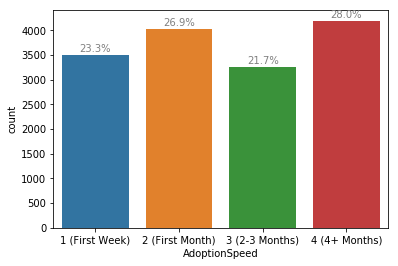

In [11]:
explore_target_variable(data_df, target_variable_name, target_value_order)

<a id="EDA_Categoricals"></a>
## Explore Categorical Variables
[Back to EDA](#EDA)

- Most of the categorical variables have a small number of distinct values (2-7).
- PetID is indeed an unique ID (# values = rows in data set)
- There are a lot of different breeds (176 primary, 135 secondary).  I wonder if this level of precision will be useful?  It would be tons of dummy variables.
- There are a lot of rescuers - simple average = 2.7 profiles per rescuer

In [12]:
print('Number of Unique Values\n')
print(data_df[categorical_features].nunique())
print()
print(data_df[['Breed1', 'Breed2', 'RescuerID', 'PetID']].nunique())

Number of Unique Values

Type            2
Gender          3
Color1          7
Color2          7
Color3          6
MaturitySize    4
FurLength       3
Vaccinated      3
Dewormed        3
Sterilized      3
Health          3
DescLanguage    4
dtype: int64

Breed1         176
Breed2         135
RescuerID     5595
PetID        14993
dtype: int64


### General Distribution of Values

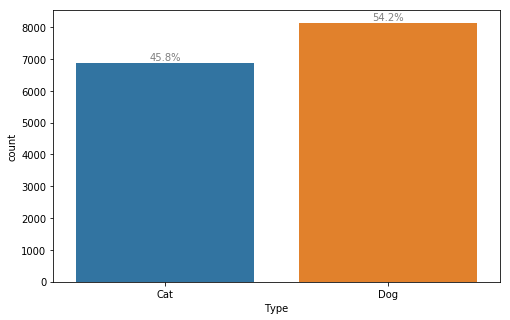

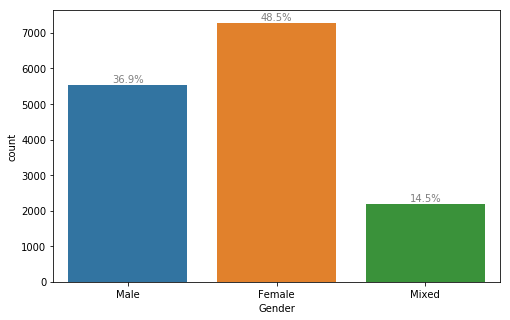

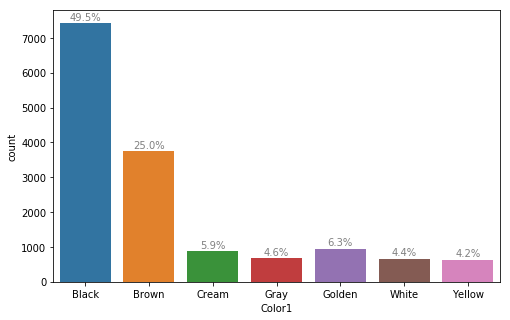

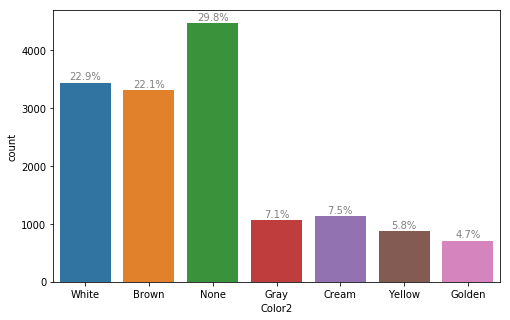

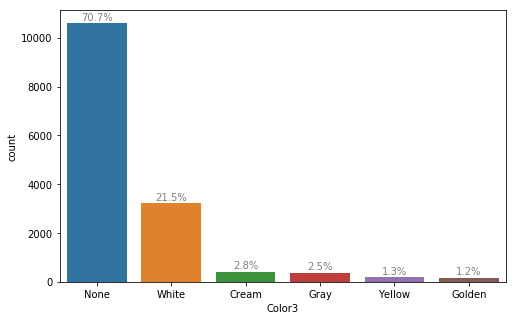

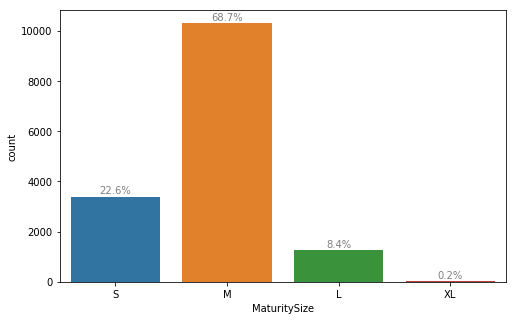

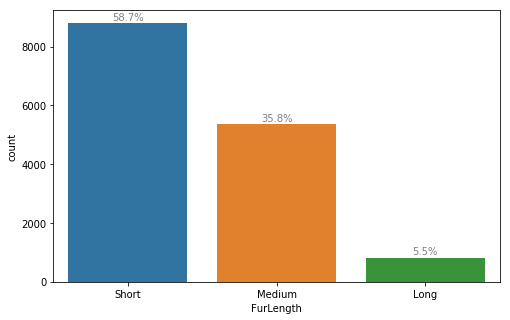

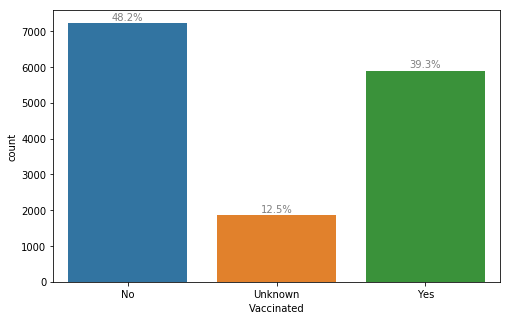

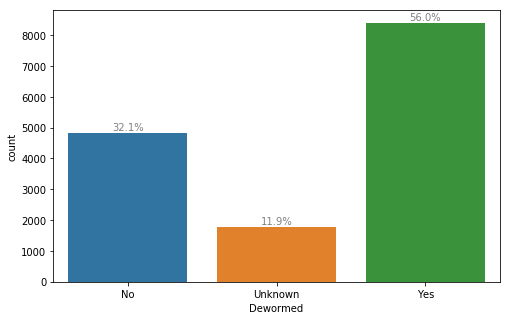

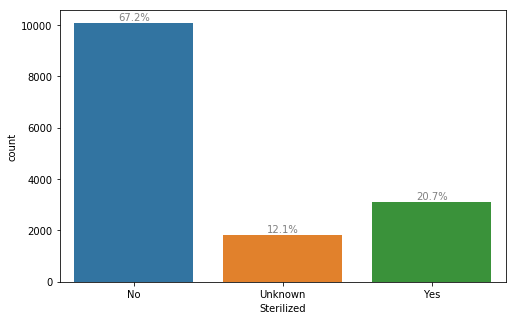

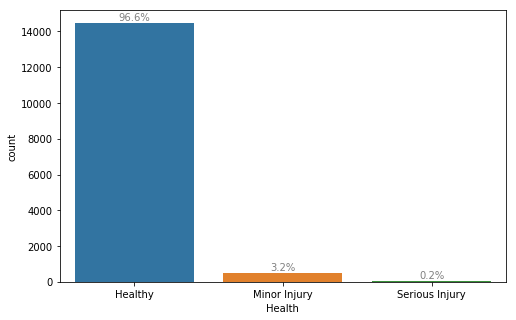

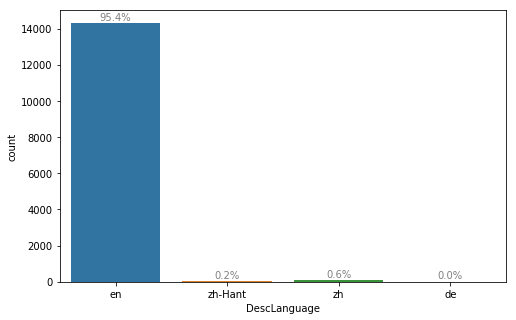

In [13]:
for col_name in categorical_features:
    plt.figure(figsize=(8,5))
    countplot_by_X(data_df, col_name)

#### Explore Breeds 1 and Breed 2

In [14]:
data_df['Type'].value_counts()

Dog    8132
Cat    6861
Name: Type, dtype: int64

In [15]:
print("Dog: Most Common Breed 1 and Breed 2\n")
print(data_df[data_df.Type=='Dog']['Breed1'].value_counts().head(15))
print()
print(data_df[data_df.Type=='Dog']['Breed2'].value_counts().head(10))

Dog: Most Common Breed 1 and Breed 2

Mixed Breed             5923
Labrador Retriever       205
Shih Tzu                 189
Poodle                   167
Terrier                  161
Golden Retriever         151
German Shepherd Dog       98
Beagle                    90
Spitz                     89
Rottweiler                88
Schnauzer                 69
Miniature Pinscher        67
Jack Russell Terrier      64
Doberman Pinscher         62
Cocker Spaniel            41
Name: Breed1, dtype: int64

None                   5627
Mixed Breed            1727
Terrier                  90
Labrador Retriever       86
German Shepherd Dog      55
Spitz                    49
Rottweiler               40
Golden Retriever         39
Poodle                   38
Shih Tzu                 32
Name: Breed2, dtype: int64


In [16]:
print("Cat: Most Common Breed 1 and Breed 2\n")
print(data_df[data_df.Type=='Cat']['Breed1'].value_counts().head(15))
print()
print(data_df[data_df.Type=='Cat']['Breed2'].value_counts().head(10))

Cat: Most Common Breed 1 and Breed 2

Domestic Short Hair     3634
Domestic Medium Hair    1258
Tabby                    342
Domestic Long Hair       296
Siamese                  264
Persian                  221
Calico                   105
American Shorthair        94
Oriental Short Hair       73
Bengal                    71
Tuxedo                    56
Tortoiseshell             42
British Shorthair         34
Maine Coon                34
Abyssinian                28
Name: Breed1, dtype: int64

None                    5135
Domestic Short Hair      599
Domestic Medium Hair     321
Tabby                    138
Domestic Long Hair       125
Siamese                  105
Persian                   78
Calico                    42
Bengal                    39
American Shorthair        30
Name: Breed2, dtype: int64


##### New Feature - PureBred - 0/1
Let's make a new feature to identify if pet is a pure bred or not.  If there is not a designated Breed2 or it is identical to Breed1 and pet is not identified as a 'Mixed Breed', then call the pet a pure bred.

In [17]:
data_df['PureBred'] = ((data_df.Breed1!='Mixed Breed') & 
                        ((data_df.Breed2=='None') | (data_df.Breed1==data_df.Breed2))).astype(int)

data_df['PureBred'].value_counts()

0    8259
1    6734
Name: PureBred, dtype: int64

##### New Feature - PrimaryBreed
There are a lot of breeds that represent <1% of the pet profiles.  Let's keep the most popular breeds and mark everything else as 'Other'.

This will consolidate the 176 breed values to 21 values (10 dog, 10 cat breeds and Other).

In [18]:
# The top 10 breeds for dogs and cats each represent at least 1% of the pet species.
most_common_dog_breeds = data_df[data_df.Type=='Dog']['Breed1'].value_counts().head(10).index.values
most_common_cat_breeds = data_df[data_df.Type=='Cat']['Breed1'].value_counts().head(10).index.values

# set PrimaryBreed = Breed1, when it is one of the most common breeds.
# otherwise set value to 'Other'

data_df['PrimaryBreed'] = None
data_df['PrimaryBreed'] = \
    data_df[(((data_df.Type=='Dog') 
             & (data_df['Breed1'].isin(most_common_dog_breeds)))
            |
            ((data_df.Type=='Cat') 
             & (data_df['Breed1'].isin(most_common_cat_breeds))))
           ].Breed1

data_df['PrimaryBreed'].fillna('Other', inplace=True)

In [19]:
categorical_features.append('PureBred')
categorical_features.append('PrimaryBreed')

<a id="EDA_Categoricals_Target"></a>
### Breakdown Categorical Variables by Target Variable
[Back to EDA](#EDA)

In [22]:
# code came from ...
# https://www.kaggle.com/artgor/exploration-of-data-step-by-step

main_count = data_df[target_variable_name].value_counts(normalize=True).sort_index()
def prepare_plot_dict(df, col, main_count):
    """
    Preparing dictionary with data for plotting.
    
    I want to show how much higher/lower are the rates of Adoption speed for the current column comparing to base values (as described higher),
    At first I calculate base rates, then for each category in the column I calculate rates of Adoption speed and find difference with the base rates.
    """
    main_count = dict(main_count)
    plot_dict = {}
    for i in df[col].unique():
        val_count = dict(df.loc[df[col] == i, target_variable_name].value_counts().sort_index())

        for k, v in main_count.items():
            if k in val_count:
                plot_dict[val_count[k]] = ((val_count[k] / sum(val_count.values())) / main_count[k]) * 100 - 100
            else:
                plot_dict[0] = 0

    return plot_dict

def make_count_plot(df, x, 
                    hue=target_variable_name, hue_order=target_value_order,
                    main_count=main_count):
    """
    Plotting countplot with correct annotations.
    """
    g = sns.countplot(x=x, data=df, hue=hue, hue_order=hue_order);
    plt.title(f'{target_variable_name} by {x}');
    ax = g.axes

    plot_dict = prepare_plot_dict(df, x, main_count)

    for p in ax.patches:
        h = p.get_height() if str(p.get_height()) != 'nan' else 0
        text = f"{plot_dict[h]:.0f}%" if plot_dict[h] < 0 else f"+{plot_dict[h]:.0f}%"
        ax.annotate(text, (p.get_x() + p.get_width() / 2., h),
             ha='center', va='center', fontsize=11, 
                    color='green' if plot_dict[h] > 0 else 'red', 
                    rotation=0, xytext=(0, 10),
             textcoords='offset points')  

In [23]:
def crosstab_prop(df, cat_feature_name, target_name):
    xtab_data = pd.crosstab(df[cat_feature_name], df[target_name])
    xtab_data_prop = xtab_data.divide(xtab_data.sum(axis=1), axis=0)
    print(xtab_data_prop)

#### Explanation of AdoptionSpeed by {Feature} Output

- First, the crosstab shows the proportion of the feature/value associated with each AdoptionSpeed class.  Summing across the row = 1 (or 100%)
- Second, the chart shows for each value of the feature (feature = Type (of animal) and values=Cat or Dog) the frequency broken out by the AdoptionSpeed class.  And also, notes if each bar is above or below the expected rate for the given adoption speed class.

For example, let's look at Cats adopted in the First Week.
- The cross tab indicates 27.6% of the cats are adopted in the first week.  
- As noted above (in the Explore Target Variable section), the base rate is 23.3% of all pets are adopted in the first week.  
- If we apply that base rate for the adoption class to cats, we would expect about 1600 cats to be adopted in the first week.
- However, 27.6% of the cats is almost 1900 cats out the door in the first week!
- The 300 additional cats is about an 18% increase over the expected rate.  Therefore, cats are adopted more than expected in the first week.

So, cats look to be adopted more quickly and dogs more slowly.

AdoptionSpeed  1 (First Week)  2 (First Month)  3 (2-3 Months)  4 (4+ Months)
Type                                                                         
Cat                  0.276199         0.272992        0.190934       0.259875
Dog                  0.197368         0.266109        0.239670       0.296852


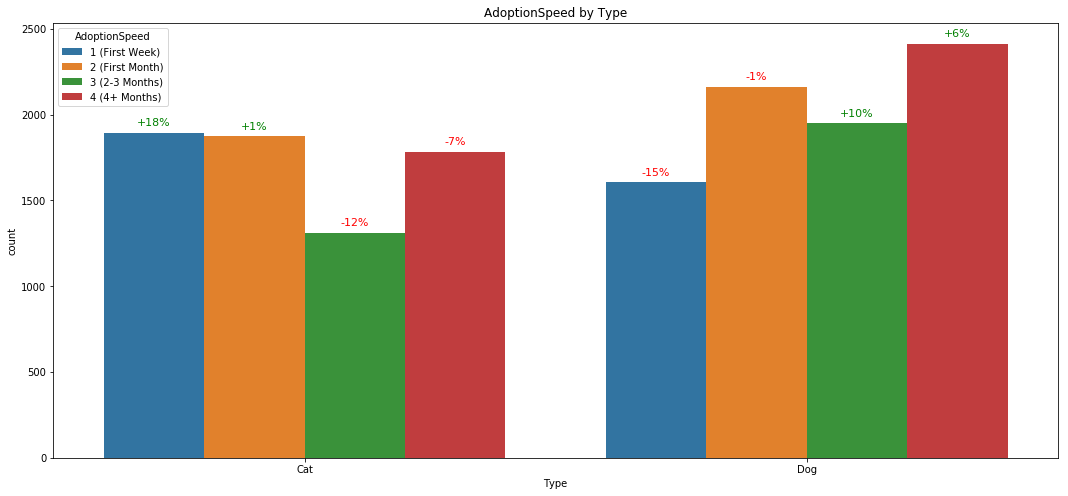

In [24]:
col_name = categorical_features[0]

crosstab_prop(data_df, col_name, target_variable_name)

plt.figure(figsize=(18, 8));
make_count_plot(df=data_df, x=col_name)

AdoptionSpeed  1 (First Week)  2 (First Month)  3 (2-3 Months)  4 (4+ Months)
Gender                                                                       
Female               0.215748         0.262608        0.229628       0.292016
Male                 0.260658         0.285043        0.200325       0.253974
Mixed                0.223394         0.251376        0.219725       0.305505


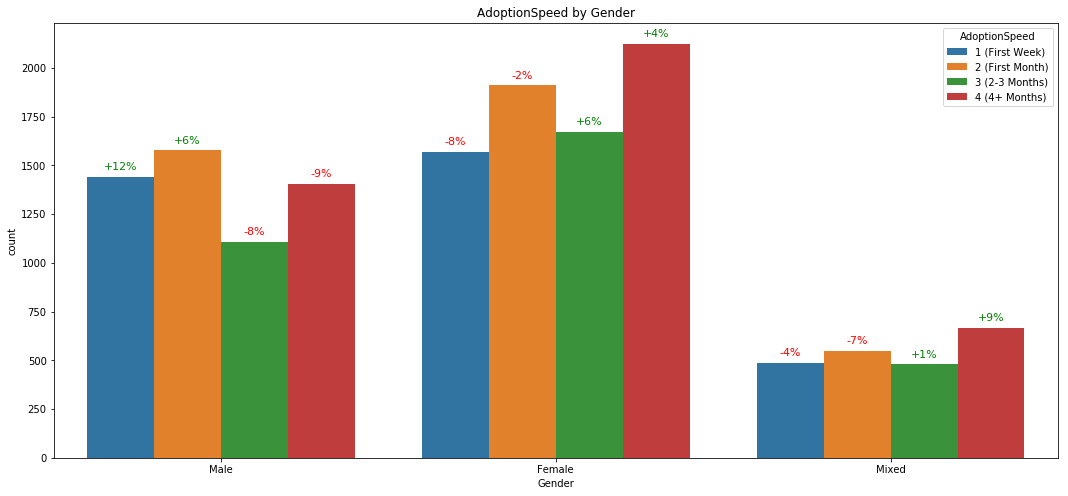

In [25]:
col_name = categorical_features[1]

crosstab_prop(data_df, col_name, target_variable_name)

plt.figure(figsize=(18, 8));
make_count_plot(df=data_df, x=col_name)

AdoptionSpeed  1 (First Week)  2 (First Month)  3 (2-3 Months)  4 (4+ Months)
Color1                                                                       
Black                0.224990         0.274135        0.219873       0.281002
Brown                0.215467         0.254933        0.227733       0.301867
Cream                0.287330         0.269231        0.209276       0.234163
Golden               0.253432         0.300950        0.194298       0.251320
Gray                 0.270468         0.285088        0.194444       0.250000
White                0.283358         0.272864        0.187406       0.256372
Yellow               0.241325         0.228707        0.228707       0.301262


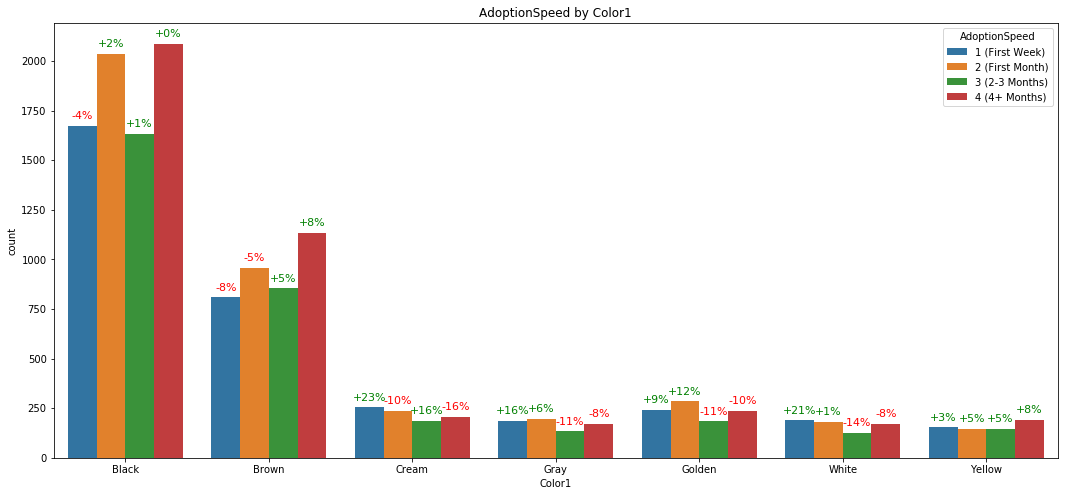

In [26]:
col_name = categorical_features[2]

crosstab_prop(data_df, col_name, target_variable_name)

plt.figure(figsize=(18, 8));
make_count_plot(df=data_df, x=col_name)

AdoptionSpeed  1 (First Week)  2 (First Month)  3 (2-3 Months)  4 (4+ Months)
Color2                                                                       
Brown                0.206158         0.284938        0.229701       0.279203
Cream                0.248227         0.280142        0.212766       0.258865
Golden               0.246479         0.247887        0.221127       0.284507
Gray                 0.285042         0.269050        0.192850       0.253057
None                 0.230821         0.257660        0.210467       0.301051
White                0.246364         0.267888        0.227167       0.258581
Yellow               0.206897         0.278161        0.200000       0.314943


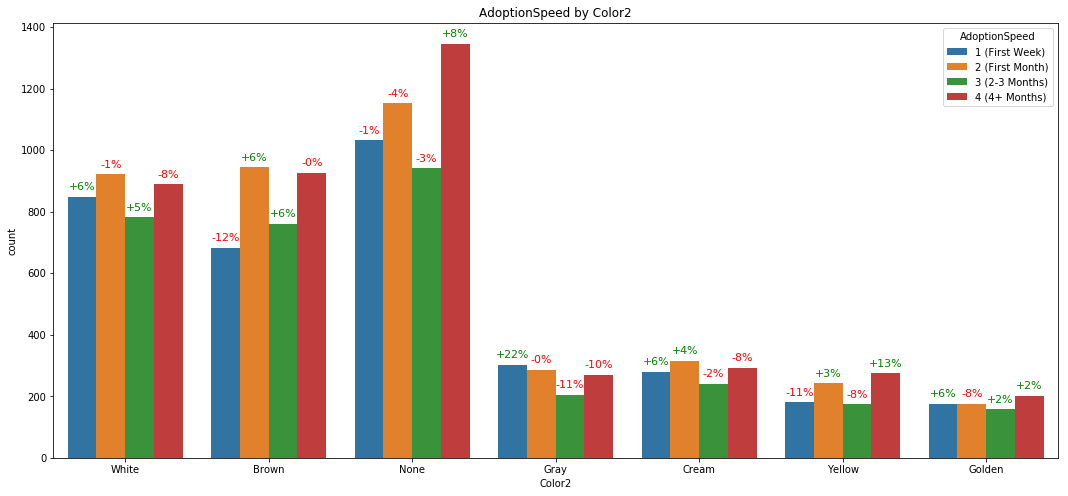

In [27]:
col_name = categorical_features[3]

crosstab_prop(data_df, col_name, target_variable_name)

plt.figure(figsize=(18, 8));
make_count_plot(df=data_df, x=col_name)

AdoptionSpeed  1 (First Week)  2 (First Month)  3 (2-3 Months)  4 (4+ Months)
MaturitySize                                                                 
L                    0.275397         0.242063        0.196825       0.285714
M                    0.207181         0.275303        0.229015       0.288501
S                    0.297202         0.260383        0.188807       0.253608
XL                   0.272727         0.333333        0.303030       0.090909


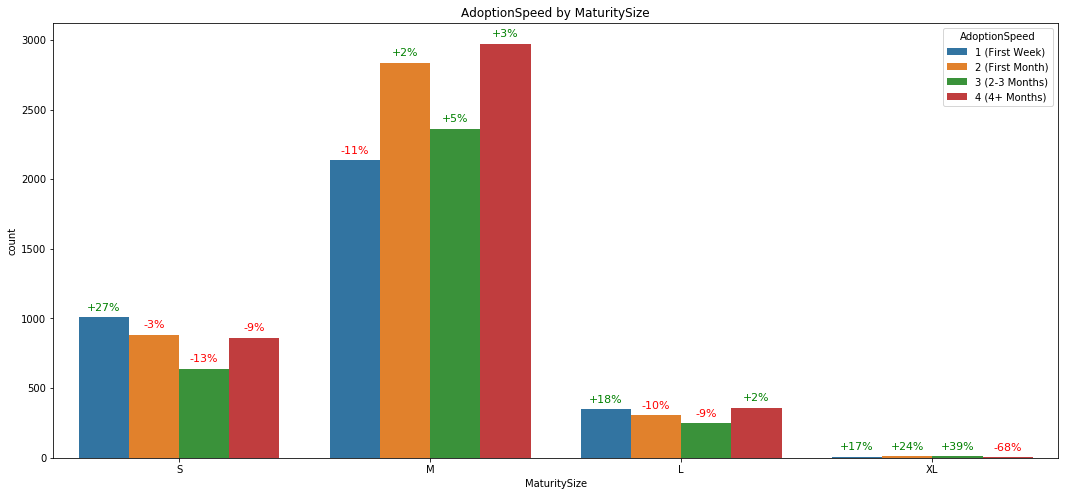

In [28]:
col_name = categorical_features[5]

crosstab_prop(data_df, col_name, target_variable_name)

plt.figure(figsize=(18, 8));
make_count_plot(df=data_df, x=col_name)

AdoptionSpeed  1 (First Week)  2 (First Month)  3 (2-3 Months)  4 (4+ Months)
FurLength                                                                    
Long                 0.376214         0.268204        0.186893       0.168689
Medium               0.251259         0.269353        0.207237       0.272151
Short                0.209242         0.269301        0.226385       0.295073


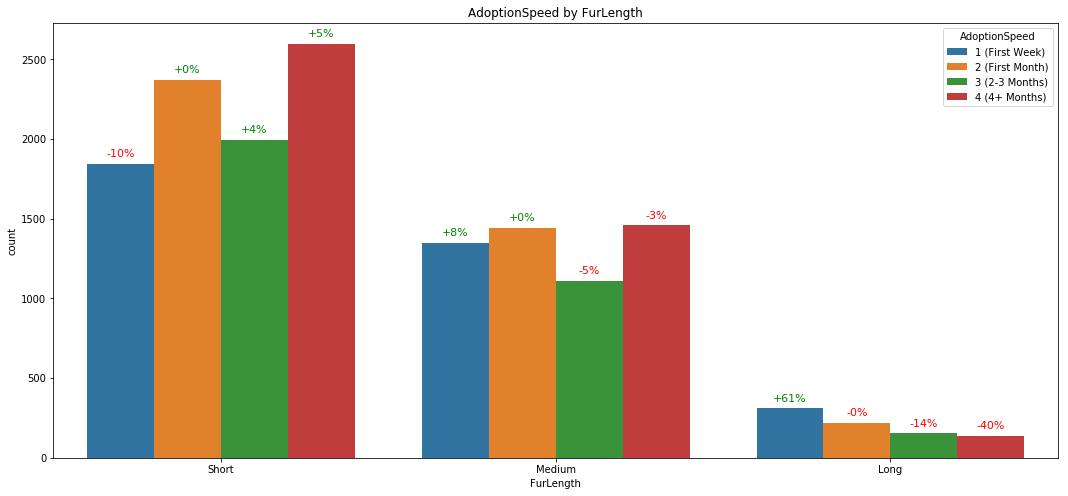

In [29]:
col_name = categorical_features[6]

crosstab_prop(data_df, col_name, target_variable_name)

plt.figure(figsize=(18, 8));
make_count_plot(df=data_df, x=col_name)

AdoptionSpeed  1 (First Week)  2 (First Month)  3 (2-3 Months)  4 (4+ Months)
Vaccinated                                                                   
No                   0.274388         0.292237        0.201882       0.231493
Unknown              0.217345         0.241970        0.203961       0.336724
Yes                  0.188369         0.249746        0.240590       0.321295


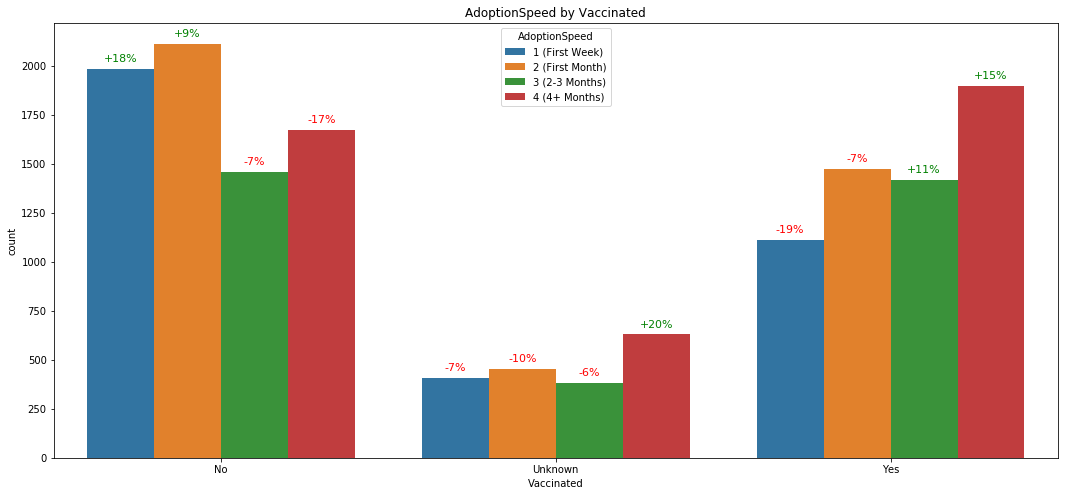

In [30]:
col_name = categorical_features[7]

crosstab_prop(data_df, col_name, target_variable_name)

plt.figure(figsize=(18, 8));
make_count_plot(df=data_df, x=col_name)

AdoptionSpeed  1 (First Week)  2 (First Month)  3 (2-3 Months)  4 (4+ Months)
Dewormed                                                                     
No                   0.277051         0.279751        0.189823       0.253375
Unknown              0.218417         0.234138        0.200449       0.346996
Yes                  0.211623         0.270692        0.236751       0.280934


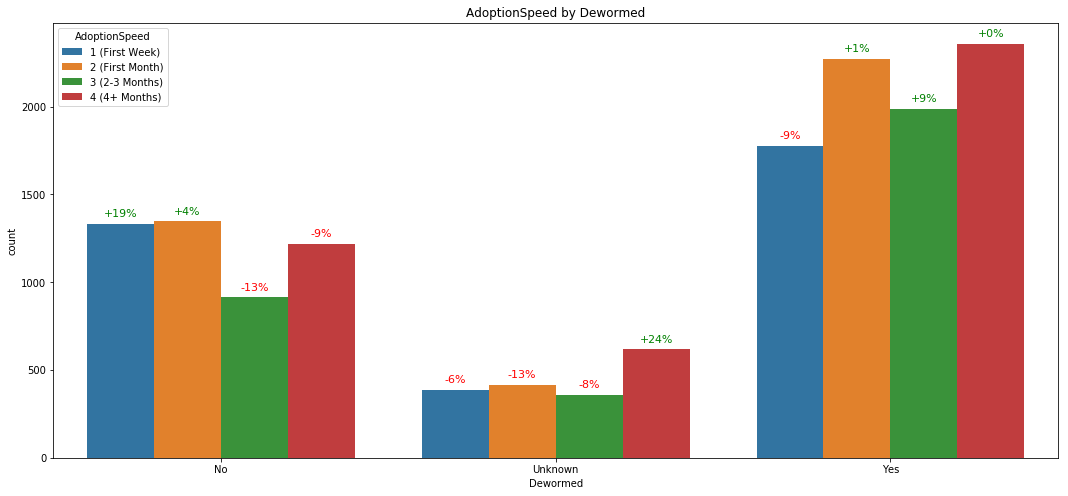

In [31]:
col_name = categorical_features[8]

crosstab_prop(data_df, col_name, target_variable_name)

plt.figure(figsize=(18, 8));
make_count_plot(df=data_df, x=col_name)

AdoptionSpeed  1 (First Week)  2 (First Month)  3 (2-3 Months)  4 (4+ Months)
Sterilized                                                                   
No                   0.262777         0.299891        0.223380       0.213953
Unknown              0.230303         0.197796        0.158678       0.413223
Yes                  0.139955         0.211545        0.232183       0.416317


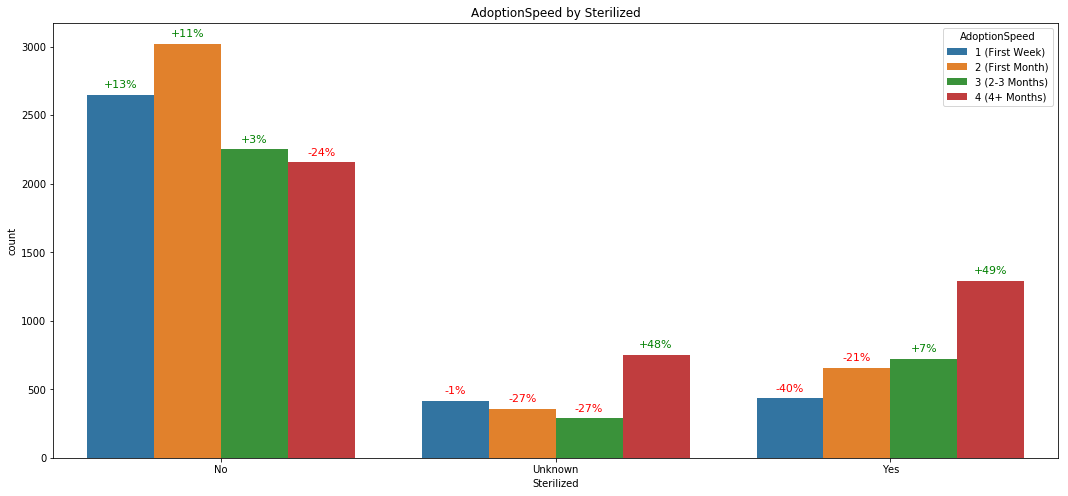

In [32]:
col_name = categorical_features[9]

crosstab_prop(data_df, col_name, target_variable_name)

plt.figure(figsize=(18, 8));
make_count_plot(df=data_df, x=col_name)

AdoptionSpeed   1 (First Week)  2 (First Month)  3 (2-3 Months)  4 (4+ Months)
Health                                                                        
Healthy               0.234217         0.271101        0.217571       0.277110
Minor Injury          0.220374         0.220374        0.203742       0.355509
Serious Injury        0.088235         0.176471        0.323529       0.411765


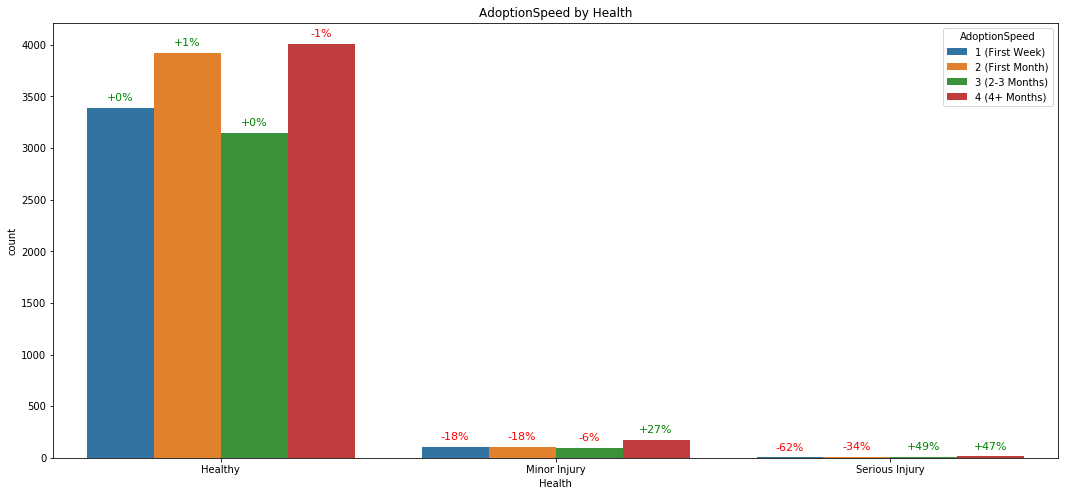

In [33]:
col_name = categorical_features[10]

crosstab_prop(data_df, col_name, target_variable_name)

plt.figure(figsize=(18, 8));
make_count_plot(df=data_df, x=col_name)

AdoptionSpeed  1 (First Week)  2 (First Month)  3 (2-3 Months)  4 (4+ Months)
DescLanguage                                                                 
de                   1.000000         0.000000        0.000000       0.000000
en                   0.231602         0.271088        0.220560       0.276749
zh                   0.157895         0.200000        0.136842       0.505263
zh-Hant              0.055556         0.222222        0.194444       0.527778


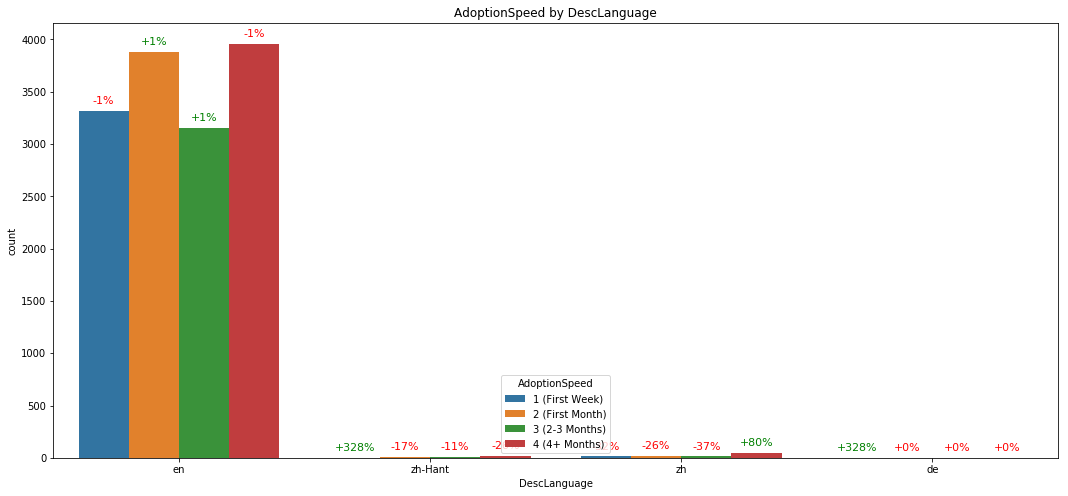

In [34]:
col_name = categorical_features[11]

crosstab_prop(data_df, col_name, target_variable_name)

plt.figure(figsize=(18, 8));
make_count_plot(df=data_df, x=col_name)

AdoptionSpeed  1 (First Week)  2 (First Month)  3 (2-3 Months)  4 (4+ Months)
PureBred                                                                     
0                    0.194697         0.266981        0.238043       0.300278
1                    0.280962         0.272052        0.192011       0.254975


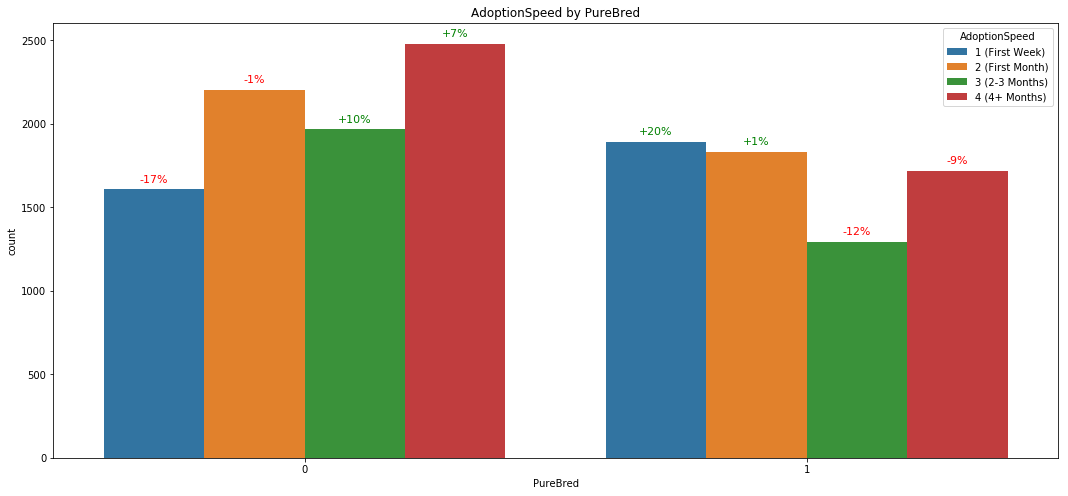

In [35]:
col_name = categorical_features[12]

crosstab_prop(data_df, col_name, target_variable_name)

plt.figure(figsize=(18, 8));
make_count_plot(df=data_df, x=col_name)

In [36]:
col_name = categorical_features[13]

crosstab_prop(data_df, col_name, target_variable_name)

#plt.figure(figsize=(18, 8));
#make_count_plot(df=data_df, x=col_name)

AdoptionSpeed         1 (First Week)  2 (First Month)  3 (2-3 Months)  \
PrimaryBreed                                                            
American Shorthair          0.265957         0.191489        0.148936   
Beagle                      0.355556         0.166667        0.322222   
Bengal                      0.408451         0.253521        0.126761   
Calico                      0.266667         0.171429        0.190476   
Domestic Long Hair          0.391892         0.246622        0.185811   
Domestic Medium Hair        0.301272         0.270270        0.180445   
Domestic Short Hair         0.239956         0.284260        0.207210   
German Shepherd Dog         0.255102         0.357143        0.224490   
Golden Retriever            0.357616         0.284768        0.218543   
Labrador Retriever          0.248780         0.287805        0.297561   
Mixed Breed                 0.158703         0.265913        0.233159   
Oriental Short Hair         0.232877         0.1917

<a id="EDA_Numerics"></a>
## Explore Numeric Variables
[Back to EDA](#EDA)

##### New Feature - Number of Profiles per Rescuer
Count the number of pet profiles per rescuer and add as a feature called 'NbrProfiles'.  This is to assess whether the originator of the pet profile influences adoption speed (e.g., individuals, small or large shelters by number of pet profiles).

In [37]:
data_df['RescuerID'].value_counts().describe()

count    5595.000000
mean        2.679714
std        10.384820
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       459.000000
Name: RescuerID, dtype: float64

In [38]:
rescurer_profiles = data_df['RescuerID'].value_counts()

rescurer_profiles_df = pd.DataFrame({'RescuerID'  : rescurer_profiles.index,
                                     'NbrProfiles': rescurer_profiles.values})

#------------------------------------------------------------
# add the nbr of pet profiles per rescuer to the other tabular attributes 
#------------------------------------------------------------
data_df = pd.merge(data_df, rescurer_profiles_df, on='RescuerID', how='left')

In [39]:
numeric_features.append('NbrProfiles')

In [40]:
data_df[numeric_features].describe()

,Age,Quantity,Fee,VideoAmt,PhotoAmt,DescNbrSentences,DescSentimentScore,DescSentimentMagnitude,NbrProfiles
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14442.000000,14442.000000,14993.000000
mean,10.452078,1.576069,21.259988,0.056760,3.889215,4.927966,0.280951,2.127628,42.917295
std,18.155790,1.472477,78.414548,0.346185,3.487810,4.820526,0.276766,2.036914,96.482112
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.900000,0.000000,1.000000
25%,2.000000,1.000000,0.000000,0.000000,2.000000,2.000000,0.100000,0.800000,1.000000
50%,3.000000,1.000000,0.000000,0.000000,3.000000,4.000000,0.300000,1.600000,5.000000
75%,12.000000,1.000000,0.000000,0.000000,5.000000,6.000000,0.400000,2.800000,28.000000
max,255.000000,20.000000,3000.000000,8.000000,30.000000,84.000000,0.900000,32.000000,459.000000


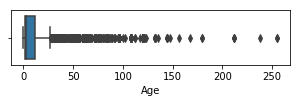

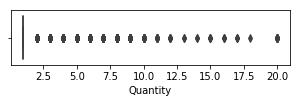

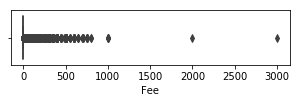

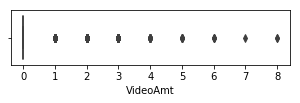

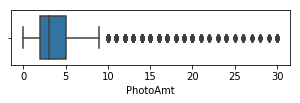

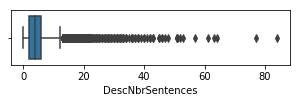

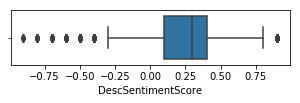

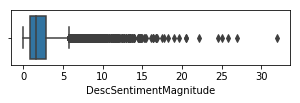

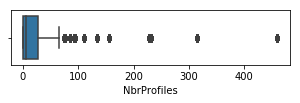

In [41]:
for col_name in numeric_features:
    plt.figure(figsize=(5,1))
    sns.boxplot(data=data_df, x=col_name, orient='h')

In [42]:
#data_df[numeric_features].plot(subplots=True, kind='box', figsize=(12,12), layout=(3,3))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e509b38>,
      dtype=object)

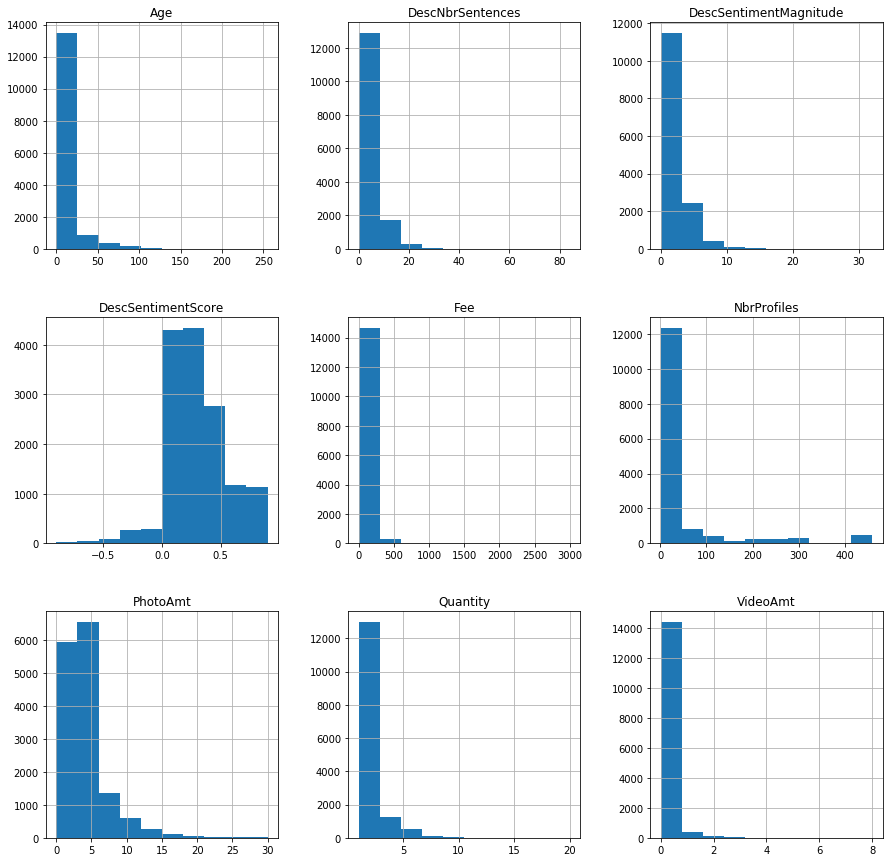

In [43]:
data_df[numeric_features].hist(figsize=(15,15))

<a id="EDA_Numerics_Target"></a>
### Breakdown of Numeric Variables by Target Variable
[Back to EDA](#EDA)

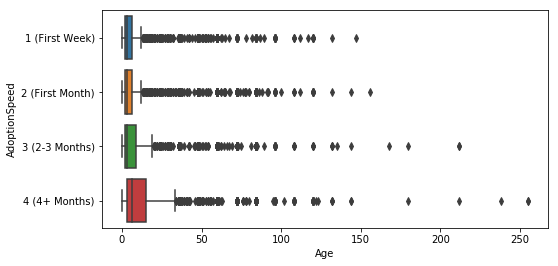

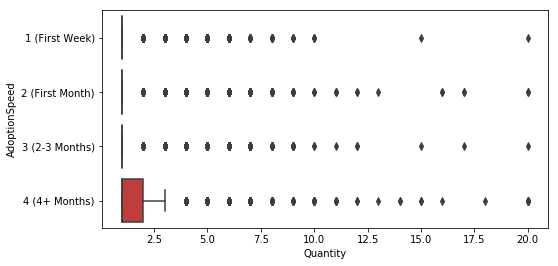

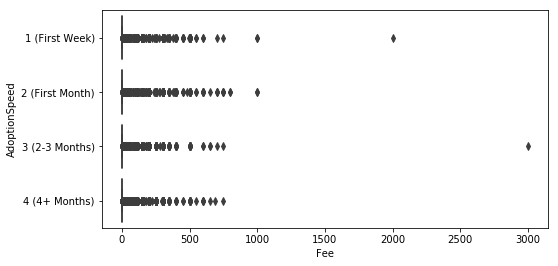

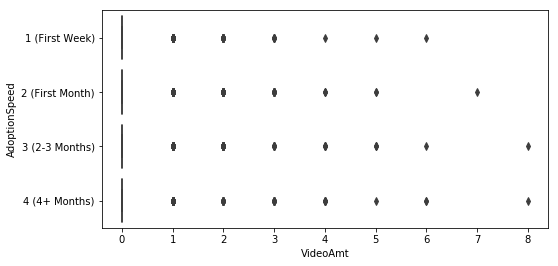

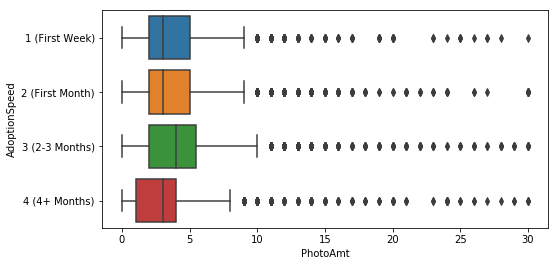

In [44]:
plt.figure(figsize=(8,4))
sns.boxplot(data=data_df, 
            x='Age', y='AdoptionSpeed', orient='h',
            order=target_value_order)

plt.figure(figsize=(8,4))
sns.boxplot(data=data_df, 
            x='Quantity', y='AdoptionSpeed', orient='h',
            order=target_value_order)

plt.figure(figsize=(8,4))
sns.boxplot(data=data_df, 
            x='Fee', y='AdoptionSpeed', orient='h',
            order=target_value_order)

plt.figure(figsize=(8,4))
sns.boxplot(data=data_df, 
            x='VideoAmt', y='AdoptionSpeed', orient='h',
            order=target_value_order)

plt.figure(figsize=(8,4))
sns.boxplot(data=data_df, 
            x='PhotoAmt', y='AdoptionSpeed', orient='h',
            order=target_value_order)

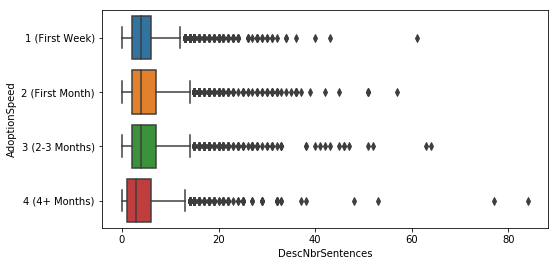

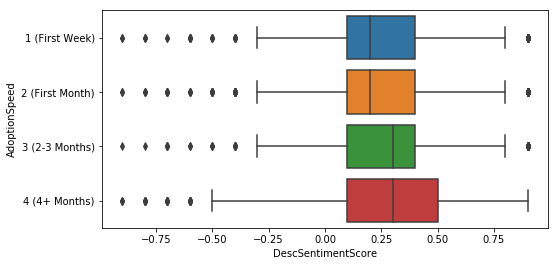

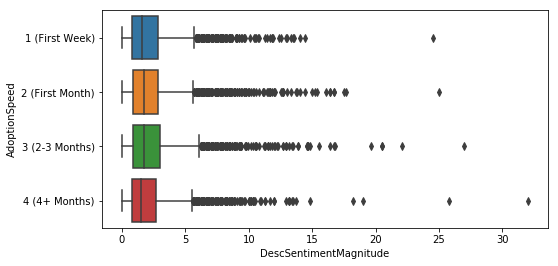

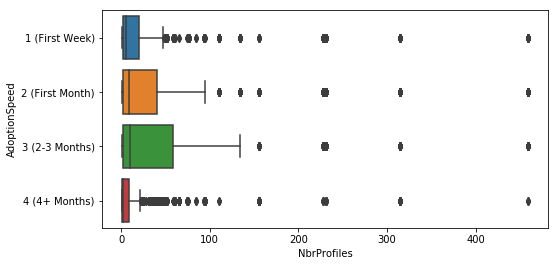

In [45]:
plt.figure(figsize=(8,4))
sns.boxplot(data=data_df, 
            x='DescNbrSentences', y='AdoptionSpeed', orient='h',
            order=target_value_order)

plt.figure(figsize=(8,4))
sns.boxplot(data=data_df, 
            x='DescSentimentScore', y='AdoptionSpeed', orient='h',
            order=target_value_order)

plt.figure(figsize=(8,4))
sns.boxplot(data=data_df, 
            x='DescSentimentMagnitude', y='AdoptionSpeed', orient='h',
            order=target_value_order)

plt.figure(figsize=(8,4))
sns.boxplot(data=data_df, 
            x='NbrProfiles', y='AdoptionSpeed', orient='h',
            order=target_value_order)

In [46]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# notes on variables to organize data preprocessing
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Target Variable
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# AdoptionSpeed               int64

# Categorical Variables
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Type                        int64
# 	PureBred     = 0/1
# 	PrimaryBreed = 21 values
# Gender                      int64
# Color1                      int64
# Color2                      int64	TBD
# Color3                      int64	TBD
# MaturitySize                int64
# FurLength                   int64
# Vaccinated                  int64
# Dewormed                    int64
# Sterilized                  int64
# Health                      int64	96.6% Healthy, 3.2 Minor Injury, 0.2 Serious Injury

# Numeric Variables
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Age                         int64	0-255 (20+ years), IQR 2-12 months
# Quantity                    int64	0-20   IQR 1-1
# Fee                         int64	0-3000 IQR 0-0
# VideoAmt                    int64	0-8    IQR 0-0
# PhotoAmt                  float64     0-30   IQR 2-5
# DescNbrSentences            int64	0-84   IQR 2-6, I set missing values = 0 sentences
# DescSentimentScore        float64 OK	-0.9 - 0.9 IQR 1-4,	551 missing
# DescSentimentMagnitude    float64 OK	0-32   IQR 0.8-2.8,	551 missing
# 	NbrProfiles = Replaces RescuerID   1-459  IQR 1-28


# TBD
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Decided not to use
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# PetID                      object		non-predictive, unique ID
# Description                object		12 missing, Replaced by sentiment analysis attributes
# State                       int64		The location in Malaysia not very meaningful for to me.
# Breed1                      int64		Lg # values 176, Replaced with PureBred, PrimaryBreed (21 values)
# Breed2                      int64		Lg # Values 135, Replaced with PureBred, PrimaryBreed (21 values)
# DescLanguage                object		551 missing, 95.4% = English
# RescuerID                  object		Lg # values 5595
# Name                       object		1257 missing - TBD - pet named? yes/no

<a id="Preprocess"></a>
# Data Preprocessing
[Table of Contents](#TOC)

- Target Variable
  - Move to first column in DataFrame
  - Convert classes from labels to numeric representation (e.g., 0,1,2,3)
- Drop Features
  - PetID - unique id for pet within dataset
  - Name - text field, not sure how this would be predictive
  - Description - using sentiment attributes from NLP API, instead of Description
  - State - not very meaning for to me.  States/location in Malaysia.
  - Breed1, Breed2 - large number of distinct values (too granular) - Replaced by PureBred, PrimaryBreed
  - RescuerID - almost a unique id - Replaced with NbrProfiles
  - DescLanguage - 95% is English, this does not seem useful.  Also 551 have missing values.
- Missing Values
  - DescSentimentScore, DescSentimentMagnitude - no information for 551 (3.7%). Replace with median.
- Initially, keep as is, but I may want to do more data prep at some point.
  - Health - 96.6% Healthy, 3.2 Minor Injury, 0.2 Serious Injury
      - Drop or keep as is?
  - Color1, 2, 3
      - keep all 3 color attributes or Replace with PrimaryColor & ColorStyle (=Solid, Two-Tone, Tri-Color)
  - Outliers - the numeric variables all have outliers - large, unusual values.
    - Age - 0-255 (20+ years), IQR 2-12 months
    - Quantity - 0-20, IQR 1-1
    - Fee - 0-3000, IQR 0-0
    - VideoAmt - 0-8,IQR 0-0
    - DescNbrSentences - 0-84,IQR 2-6
    - NbrProfiles - 1-459, IQR 1-28
- Categorical Features
  - Convert categorial features to dummy variables
- Continuous Features
  - Normalize to range of [0,1]

In [47]:
data_prepared_df = data_df

## Target Variable
- Move to first column in DataFrame
- Convert classes from labels to numeric representation (e.g., 0,1,2,3)

In [48]:
#------------------------------------------------------------
# move target variable to first column
#------------------------------------------------------------
move_target_variable(data_prepared_df, target_variable_name)
    
# confirm target variable is now in position 0 by slicing a few rows and columns
data_prepared_df.iloc[:3,:5]

,AdoptionSpeed,Type,Name,Age,Breed1
0,2 (First Month),Cat,Nibble,3,Tabby
1,1 (First Week),Cat,No Name Yet,1,Domestic Medium Hair
2,3 (2-3 Months),Dog,Brisco,1,Mixed Breed


In [49]:
#------------------------------------------------------------
# define mapping of categorical label/value and numeric value
#------------------------------------------------------------
target_mapping = {'1 (First Week)' :0,
                  '2 (First Month)':1,
                  '3 (2-3 Months)' :2,
                  '4 (4+ Months)'  :3}

#------------------------------------------------------------
# swap text label for numeric value
#------------------------------------------------------------
data_prepared_df[target_variable_name] = data_prepared_df[target_variable_name].map(target_mapping)

data_prepared_df.iloc[:3,:5]

,AdoptionSpeed,Type,Name,Age,Breed1
0,1,Cat,Nibble,3,Tabby
1,0,Cat,No Name Yet,1,Domestic Medium Hair
2,2,Dog,Brisco,1,Mixed Breed


## Drop Features
- PetID - unique id for pet within data set
- Name - text field, not sure how this would be predictive
- Description - using sentiment attributes from NLP API, instead of Description
- State - not very meaning for to me.  States/location in Malaysia.
- Breed1, Breed2 - large number of distinct values (too granular) - Replaced by PureBred, PrimaryBreed
- RescuerID - almost a unique id - Replaced with NbrProfiles
- DescLanguage - 95% is English, this does not seem useful.  Also 551 have missing values.

In [50]:
del data_prepared_df['PetID']
del data_prepared_df['Name']
del data_prepared_df['Description']
del data_prepared_df['State']
del data_prepared_df['Breed1']
del data_prepared_df['Breed2']
del data_prepared_df['RescuerID']
del data_prepared_df['DescLanguage']

## Impute Missing Values
- DescSentimentScore, DescSentimentMagnitude - no information for 551 (3.7%). Replace with median.

In [51]:
print("Missing Values Before Imputation\n")
missing_s = data_prepared_df.isnull().sum()
if ( missing_s.sum() == 0 ):
    print("No missing values detected")
else:
    print(missing_s[missing_s>0])

    
#------------------------------------------------------------
# DescSentimentScore
#------------------------------------------------------------
col_name = 'DescSentimentScore'
median_value = data_prepared_df[col_name].median()
data_prepared_df[col_name].fillna(median_value, inplace=True)

#------------------------------------------------------------
# DescSentimentMagnitude
#------------------------------------------------------------
col_name = 'DescSentimentMagnitude'
median_value = data_prepared_df[col_name].median()
data_prepared_df[col_name].fillna(median_value, inplace=True)


#------------------------------------------------------------
print()
print("Missing Values _AFTER_ Imputation\n")
missing_s = data_prepared_df.isnull().sum()
if ( missing_s.sum() == 0 ):
    print("No missing values detected")
else:
    print(missing_s[missing_s>0])

Missing Values Before Imputation

DescSentimentScore        551
DescSentimentMagnitude    551
dtype: int64

Missing Values _AFTER_ Imputation

No missing values detected


## Convert Categorical Features to Dummies
- Categorical Variables (12 + 1 binary indicator)
  - Type, Gender, Color1, Color2, Color3, MaturitySize, FurLength, Vaccinated, Dewormed, Sterilized, Health, PrimaryBreed
  - PureBred - binary indicator
- Numeric Variables (9)
  - Age, Quantity, Fee, VideoAmt, PhotoAmt, DescNbrSentences, DescSentimentScore, DescSentimentMagnitude, NbrProfiles

In [52]:
#------------------------------------------------------------
# save data in "prepared" state before converting categoricals 
# to dummy variables
#------------------------------------------------------------
data_prepared_df.to_csv("data_prepared_1.csv", index=False)

In [53]:
cursory_exploration(data_prepared_df, dtypes=True)

Shape:  (14993, 23)

Data Types:
AdoptionSpeed               int64
Type                       object
Age                         int64
Gender                     object
Color1                     object
Color2                     object
Color3                     object
MaturitySize               object
FurLength                  object
Vaccinated                 object
Dewormed                   object
Sterilized                 object
Health                     object
Quantity                    int64
Fee                         int64
VideoAmt                    int64
PhotoAmt                  float64
DescNbrSentences            int64
DescSentimentScore        float64
DescSentimentMagnitude    float64
PureBred                    int64
PrimaryBreed               object
NbrProfiles                 int64
dtype: object

Missing Values:
No missing values detected


In [54]:
data_prepared_dummy_df = data_prepared_df

# remove space from value, so we don't have spaces in feature names
data_prepared_dummy_df['Health']       = data_prepared_dummy_df['Health'].str.replace(' ', '')
data_prepared_dummy_df['PrimaryBreed'] = data_prepared_dummy_df['PrimaryBreed'].str.replace(' ', '')

data_prepared_dummy_df = convert_to_dummies(data_prepared_dummy_df)

In [55]:
data_prepared_dummy_df.columns

Index(['AdoptionSpeed', 'Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt',
       'DescNbrSentences', 'DescSentimentScore', 'DescSentimentMagnitude',
       'PureBred', 'NbrProfiles', 'Type_Cat', 'Type_Dog', 'Gender_Female',
       'Gender_Male', 'Gender_Mixed', 'Color1_Black', 'Color1_Brown',
       'Color1_Cream', 'Color1_Golden', 'Color1_Gray', 'Color1_White',
       'Color1_Yellow', 'Color2_Brown', 'Color2_Cream', 'Color2_Golden',
       'Color2_Gray', 'Color2_None', 'Color2_White', 'Color2_Yellow',
       'Color3_Cream', 'Color3_Golden', 'Color3_Gray', 'Color3_None',
       'Color3_White', 'Color3_Yellow', 'MaturitySize_L', 'MaturitySize_M',
       'MaturitySize_S', 'MaturitySize_XL', 'FurLength_Long',
       'FurLength_Medium', 'FurLength_Short', 'Vaccinated_No',
       'Vaccinated_Unknown', 'Vaccinated_Yes', 'Dewormed_No',
       'Dewormed_Unknown', 'Dewormed_Yes', 'Sterilized_No',
       'Sterilized_Unknown', 'Sterilized_Yes', 'Health_Healthy',
       'Health_MinorInjury', 'Heal

In [56]:
print(data_prepared_dummy_df.shape)
data_prepared_dummy_df.head()

(14993, 76)


,AdoptionSpeed,Age,Quantity,Fee,VideoAmt,PhotoAmt,DescNbrSentences,DescSentimentScore,DescSentimentMagnitude,PureBred,...,PrimaryBreed_OrientalShortHair,PrimaryBreed_Other,PrimaryBreed_Persian,PrimaryBreed_Poodle,PrimaryBreed_Rottweiler,PrimaryBreed_ShihTzu,PrimaryBreed_Siamese,PrimaryBreed_Spitz,PrimaryBreed_Tabby,PrimaryBreed_Terrier
0,1,3,1,100,0,1.0,6,0.3,2.4,1,...,0,0,0,0,0,0,0,0,1,0
1,0,1,1,0,0,2.0,2,-0.2,0.7,1,...,0,0,0,0,0,0,0,0,0,0
2,2,1,1,0,0,7.0,7,0.2,3.7,0,...,0,0,0,0,0,0,0,0,0,0
3,1,4,1,150,0,8.0,1,0.9,0.9,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,3.0,6,0.6,3.7,0,...,0,0,0,0,0,0,0,0,0,0


## Normalize Numeric Features
Normalize (rescale) features to a range of [0, 1]

In [57]:
# separate features (X) from class label (y) 
# and pull out np.array representation from Panda DataFrame/Series

features, target = data_prepared_dummy_df.iloc[:, 1:].values, data_prepared_dummy_df.iloc[:, 0].values
feature_labels   = data_prepared_dummy_df.columns[1:]

In [58]:
mm_scaler = preprocessing.MinMaxScaler()

features_norm = mm_scaler.fit_transform(features)

In [59]:
#------------------------------------------------------------
# re-create a DataFrame for convenience
#------------------------------------------------------------
features_norm_df = pd.DataFrame(features_norm, columns=feature_labels)
features_norm_df.iloc[:5, :]

,Age,Quantity,Fee,VideoAmt,PhotoAmt,DescNbrSentences,DescSentimentScore,DescSentimentMagnitude,PureBred,NbrProfiles,...,PrimaryBreed_OrientalShortHair,PrimaryBreed_Other,PrimaryBreed_Persian,PrimaryBreed_Poodle,PrimaryBreed_Rottweiler,PrimaryBreed_ShihTzu,PrimaryBreed_Siamese,PrimaryBreed_Spitz,PrimaryBreed_Tabby,PrimaryBreed_Terrier
0,0.011765,0.0,0.033333,0.0,0.033333,0.071429,0.666667,0.075000,1.0,0.015284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.003922,0.0,0.000000,0.0,0.066667,0.023810,0.388889,0.021875,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.003922,0.0,0.000000,0.0,0.233333,0.083333,0.611111,0.115625,0.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.015686,0.0,0.050000,0.0,0.266667,0.011905,1.000000,0.028125,0.0,0.106987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.003922,0.0,0.000000,0.0,0.100000,0.071429,0.833333,0.115625,0.0,0.290393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
#------------------------------------------------------------
# review normalization, looks OK
#------------------------------------------------------------

#(features_norm_df.iloc[:, 0:8]).describe()   # numeric features
#(features_norm_df.iloc[:, 8:9]).describe()   # pure bred binary 
#(features_norm_df.iloc[:, 9:10]).describe()  # nbr profiles
#(features_norm_df.iloc[:, 10:12]).describe() # type dummies
(features_norm_df.iloc[:, 12:15]).describe() # gender dummies
# ...

,Gender_Female,Gender_Male,Gender_Mixed
count,14993.000000,14993.000000,14993.000000
mean,0.485360,0.369239,0.145401
std,0.499802,0.482615,0.352517
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


<a id="Split"></a>
# Split Data into Training & Test Datasets
[Table of Contents](#TOC)

Using a 70/30 split. Of the 14,993 observations, 10,495 used for training the model and 4,498 held in reserve for testing/validation.

In [61]:
# split Train/Test = 70/30 split
features_train, features_test, target_train, target_test =\
    train_test_split(features_norm, target, 
                     test_size=0.30, stratify=target,
                     random_state=1203)

print("TRAINING")
print("-- Features shape: ", features_train.shape)
print("-- Target   shape: ", target_train.shape)
print("-- Class   counts: ", np.bincount(target_train))

print("\nTESTING")
print("-- Features shape: ", features_test.shape)
print("-- Target   shape: ", target_test.shape)
print("-- Class   counts: ", np.bincount(target_test))

TRAINING
-- Features shape:  (10495, 75)
-- Target   shape:  (10495,)
-- Class   counts:  [2450 2826 2281 2938]

TESTING
-- Features shape:  (4498, 75)
-- Target   shape:  (4498,)
-- Class   counts:  [1050 1211  978 1259]


In [62]:
#------------------------------------------------------------
# save results to a file so we can start here again as I work through different models
#------------------------------------------------------------

# np.savez('split_data', features_train, features_test, target_train, target_test, feature_labels.values)

<a id="models"></a>
# Models and Tuning
[Table of Contents](#TOC)

If a model is reasonably accurate in predicting how long each animal may take to adopt, then we could maximize the animals a shelter could care for given its resource constraints.

Incorrect predictions of the adoption speed hinders the ability of the shelter to operate efficiently with animals staying longer or shorter than predicted and messing up the organization's operational plans - managing its supply and demand.

**Being adopted more quickly** is a benefit to the pet.  Shelters are good temporary homes but a pet is much better off in a home with a family and spending the least amount of time possible in a shelter.  

For the shelter, if animals are adopted more quickly than expected the shelter may have idle capacity - empty cages.  That is, the shelter is thinking they would be full so they did not schedule a transport to accept more animals.  Ultimately, the shelter is not using all its available capacity and thus not helping as many animals as possible.

**Being adopted slower than expected** may mean the shelter implements a different plan of care and misses opportunities to benefit the pet in some way.  For example, I have shuttled shelter dogs to obedience training classes.  A better trained dog is more easily adopted and for the longer stay residents it is a good activity to help keep the dogs in good mental condition.  The longer stay residents (e.g., pit bull or large dog) are triaged first for the available slots.  So if you expected a dog to be adopted within the first month they are not a strong candidate for dog training.  But if the dog ends up at the shelter for 4+ months we have missed an opportunity to help the dog be more adoptable.

Also if pets are adopted slower than expected, then the shelter is not turning its inventory as quickly and ultimately helping fewer animals - a bottleneck or backlog condition.

The **more harmful condition** in my opinion, is when a pet takes longer to adopt and we predicted it would be adopted quickly. In this situation, we likely missed many opportunities to provide better care for that animal.  This would be **false negatives on the slower adoption speed classes** (2-3 months or 4+ months class).

Having an animal adopted more quickly is not an "error" from the pet's perspective and just causes more operational challenges for the shelter.  Each type of error presents operational challenges for the shelter and neither is particular better or worse than the other.  Each requires the shelter to juggle mismatches in supply and demand.



## Metrics to Assess Models
In assessing models, accuracy will be important.  If the model is not accurate it will not be very useful in managing the inventory (pets) of the shelter.  In addition to the standard measure of accuracy, I will also use Cohen's Kappa Score to measure agreement between the known adoption speed and the predicted class by the model.  I will also collect and review metrics by adoption speed class, given that some error conditions are more harmful than others.

- **Accuracy** - overall accuracy or total number of correct predictions.
- **Cohen's Kappa Score**
  - The Kaggle competition submissions were scored based on the quadratic weighted kappa.
  - *Cohen's Kappa measures the agreement between two ratings. This metric typically varies from 0 (random agreement between raters) to 1 (complete agreement between raters). In the event that there is less agreement between the raters than expected by chance, the metric may go below 0. The quadratic weighted kappa is calculated between the scores which are expected/known and the predicted scores.*
  - Looking at the leaderboard on the Kaggle competition it looks a Cohen's Kappa in the mid-to-upper 0.40s is a good goal.
- **Metrics by Class** *of Adoption Speed (0=1st Week, 1=1st Month, 2=2-3 Months, 3=4+ Months)*
  - True Positive Rate (TPR) or Recall
  - Positive Prediction Value (PPV) or Precision
  - Metrics from the Confusion Matrix
    - True Positive (TP)
    - False Positive (FP)
    - False Negative (FN)

## General Approach to Tuning
- I will start with the default values for all/most of the parameters for an algorithm
  - Fit/train the model on the whole training dataset and then assess the model on metrics described above.
  - I will use cross validation and look at variation across folds to assess overfitting
- Then I will tune some hyperparameters
  - I will make educated guesses/choices and/or perform Grid Searches 
  - When using Grid Search
    - I will examine at the performance metrics as I change the value of the hyperparameter(s) (i.e., CV mean/stds on training and/or test dataset across the folds).  This so I can determine if the "best" parameters really make sense or not.
    - Then for the "best" parameters, I will re-fit the model on the entire training dataset and assess on the test dataset.

*Links to Documentation*
- [Classification Metrics](https://scikit-learn.org/0.20/modules/model_evaluation.html#classification-metrics)
- [Cohen Kappa Score](https://scikit-learn.org/0.20/modules/generated/sklearn.metrics.cohen_kappa_score.html)
- [Wikipedia - Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix)
- [Scoring - Predefined Values](https://scikit-learn.org/0.20/modules/model_evaluation.html#common-cases-predefined-values)

<a id="model_decision_tree"></a>
# Decision Trees
[Table of Contents](#TOC)

Models/Tunings:
- [Default Values](#model_dt1)
- [Grid Search on max_features](#model_dt2) - limit features to consider at each split versus all 75 features
- [Grid Search on max_leaf_nodes](#model_dt3) - limit size of tree (by leaf_nodes)
- [Grid Search Pass 2 on max_leaf_nodes](#model_dt4)

*Links to Documentation*
- [Decision Trees](https://scikit-learn.org/0.20/modules/tree.html)
- [DecisionTreeClassifier](https://scikit-learn.org/0.20/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [4]:
model_results_dt = []

<a id="model_dt1"></a>
## Decision Tree 1 - Defaults
[Back to Decision Trees](#model_decision_tree)


Accuracy      : 35.37
Cohen's Kappa : 0.2278

Classification Report
              precision    recall  f1-score   support

           0       0.32      0.34      0.33      1050
           1       0.33      0.32      0.33      1211
           2       0.28      0.29      0.28       978
           3       0.47      0.45      0.46      1259

   micro avg       0.35      0.35      0.35      4498
   macro avg       0.35      0.35      0.35      4498
weighted avg       0.36      0.35      0.35      4498



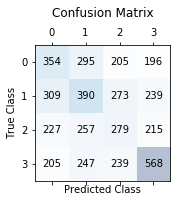


CV Accuracy: 36.160 +/- 0.760
Scores: [35.41 37.11 36.3  35.18 36.8 ]


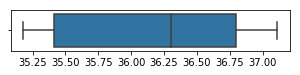


CV CohenKappa: 0.227 +/- 0.018
Scores: [0.221 0.254 0.241 0.201 0.218]


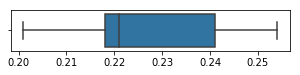

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Tree 1 (defaults),35.37,0.2278,33.71,32.2,28.53,45.12,"[32.33, 32.8, 28.01, 46.63]","[354, 390, 279, 568]","[741, 799, 717, 650]","[696, 821, 699, 691]","{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0,...","{'Accuracy': (36.16, 0.76), 'CohenKappa': (0.227, 0.018)}"


In [5]:
from sklearn.tree import DecisionTreeClassifier

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_dt1 = DecisionTreeClassifier(random_state=RANDOM_SEED)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_dt1
model_label        = 'Tree 1 (defaults)'
model_results_list = model_results_dt

dt_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
dt_results_df

**A note on the results output.**
- TPR_0 - 3 is the True Positive Rate (or Recall) for each AdoptionSpeed class
  - Class 0=1st Week
  - Class 1=1st Month
  - Class 2=2-3 Months
  - Class 3=4+ Months or 91+ days
- PPV - Positive Prediction Value (or Precision).  The entries in the list correspond to each class.
- TP, FP, FN - the lists contain the confusion matrix entries by class (e.g., the second entry of the FP list is the number of false positives for class 1).

#### Quick Thoughts on Results
- **Not so hot.** Accuracy poor at 35% (about 1/3 correct).  
- Cohen's Kappa ranges from 0 to 1, so this model is on the lower end of that metric.  *On the leaderboard for the Kaggle competition to top entry had a Cohen's Kappa of 0.466.  So that's a target to keep in mind.*
- There is some variation in the TPR for the different adoption speed classes.  The model does best on the longest duration (4+ months to be adopted) - 45%.  One week & one month are about the same - 33% recall. And the 2-3 month class we do the worst on at 29%.
- The errors by class FP & FN seem fairly balanced a fewer more on side of the other, but not a clear trend in which the model is consistently wrong.
- I debated the number of folds for CV.  The test dataset is small at a little under 4500 observations.  At CV=5, the test fold seems a little small (900 records).  But I will test on each fold and thought it would be more useful to have more data to train the model. 
  - CV3 = 3014 trng, 1484 test in each fold
  - CV4 = 3374 trng, 1124 test
  - CV5 = 3598 trng, 900 test
- The standard deviations in the CV results are not very large or concerning at this point.

In [6]:
#------------------------------------------------------------
# Explore Decision Tree
#------------------------------------------------------------
model = clf_dt1
print("Depth of Decision Tree  :", model.tree_.max_depth)
print("Nodes in Decision Tree  :", model.tree_.node_count) # internal + leaves
print("Leaves in Decision Tree :", int(np.round((model.tree_.node_count/2)+1,0)))
print("Max Features at Split   :", model.max_features_)

print("\n- - - - Top Features - - - -")
feature_importance_df = pd.DataFrame(model.feature_importances_, 
                                     index=feature_labels, columns=['Importance'])

feature_importance_df[feature_importance_df.Importance!=0] \
    .sort_values(by='Importance', ascending=False) \
    .head(10)

# info on the structure of the tree
#
# from sklearn.tree._tree import Tree
# help(Tree)

Depth of Decision Tree  : 37
Nodes in Decision Tree  : 8411
Leaves in Decision Tree : 4206
Max Features at Split   : 75

- - - - Top Features - - - -


,Importance
DescSentimentMagnitude,0.105771
NbrProfiles,0.100072
PhotoAmt,0.087934
Age,0.081850
DescSentimentScore,0.081028
DescNbrSentences,0.068271
Quantity,0.023319
Fee,0.020700
Color1_Brown,0.018971
Gender_Male,0.016591


#### Quick Thoughts on Results
- Explore a bit what the tree looks like: 37 levels deep & over 4200 leaf nodes.
- Top features include: 
  - Information about sentiment of the description in the pet profile (magnitude, score, length (nbr of sentences)).
  - NbrProfiles - is the number of profiles the rescuer has created - so an indication of an individual, small animal shelter or larger organization.
  - Amount of photos, Age of pet
- Just interesting, nothing hugely surprising.

<a id="model_dt2"></a>
## Decision Tree 2 - Grid Search Max Features
[Back to Decision Trees](#model_decision_tree)

An important aspect of Decision Trees is how many features are considered at each split as the tree is constructed.  Let's consider a range of options:  two standard parameter options are log2 and sqrt of total features (75 in this case).  As well, as larger slices of features 25, 50, 75%.  The default is all or 100% of the features are available.

The range of feature in this grid search should be: [6, 8, 18, 37, 56]

In [7]:
#------------------------------------------------------------
# create classifier
#------------------------------------------------------------
clf_dt2 = DecisionTreeClassifier(random_state=RANDOM_SEED)
model = clf_dt2

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 5-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------

param_grid  = {'max_features':['log2', 'sqrt', 0.25, 0.50, 0.75]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=5)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'max_features': 0.5}

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=114,
            splitter='best')


In [8]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
print('Params: ', gs.cv_results_['params'])
print('\nTest Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_test_CohenKappa'], 3))
print('Rank       :', gs.cv_results_['rank_test_CohenKappa'])

print('\nTrain Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_train_CohenKappa'], 3))

Params:  [{'max_features': 'log2'}, {'max_features': 'sqrt'}, {'max_features': 0.25}, {'max_features': 0.5}, {'max_features': 0.75}]

Test Results
Accuracy   : [33.7  34.68 35.6  35.54 36.11]
CohenKappa : [0.176 0.174 0.221 0.224 0.22 ]
Rank       : [4 5 2 1 3]

Train Results
Accuracy   : [99.78 99.78 99.78 99.78 99.78]
CohenKappa : [0.998 0.998 0.998 0.998 0.998]


#### Quick Thoughts on Results
- The results on the training folds are nearly perfect (99%) and dramatically worse on the test fold.  This is a sign the model is overfitting the training data.


Accuracy      : 35.02
Cohen's Kappa : 0.1971

Classification Report
              precision    recall  f1-score   support

           0       0.31      0.32      0.32      1050
           1       0.32      0.32      0.32      1211
           2       0.29      0.29      0.29       978
           3       0.46      0.45      0.45      1259

   micro avg       0.35      0.35      0.35      4498
   macro avg       0.35      0.35      0.35      4498
weighted avg       0.35      0.35      0.35      4498



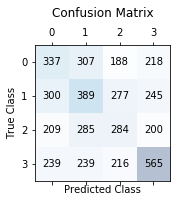


CV Accuracy: 35.540 +/- 0.720
Scores: [35.98 35.49 36.54 35.32 34.37]


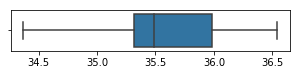


CV CohenKappa: 0.224 +/- 0.021
Scores: [0.216 0.223 0.263 0.202 0.215]


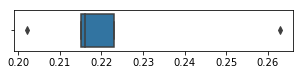

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Tree 1 (defaults),35.37,0.2278,33.71,32.20,28.53,45.12,"[32.33, 32.8, 28.01, 46.63]","[354, 390, 279, 568]","[741, 799, 717, 650]","[696, 821, 699, 691]","{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0,...","{'Accuracy': (36.16, 0.76), 'CohenKappa': (0.227, 0.018)}"
1,Tree 2 (max_features=50%),35.02,0.1971,32.10,32.12,29.04,44.88,"[31.06, 31.89, 29.43, 46.01]","[337, 389, 284, 565]","[748, 831, 681, 663]","[713, 822, 694, 694]","{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.5, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, ...","{'Accuracy': (35.54, 0.72), 'CohenKappa': (0.224, 0.021)}"


In [9]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
clf_dt2 = DecisionTreeClassifier(random_state=RANDOM_SEED, max_features=0.5)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_dt2
model_label        = 'Tree 2 (max_features=50%)'
model_results_list = model_results_dt

dt_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
dt_results_df

In [10]:
#------------------------------------------------------------
# Explore Decision Tree
#------------------------------------------------------------
model = clf_dt2
print("Depth of Decision Tree  :", model.tree_.max_depth)
print("Nodes in Decision Tree  :", model.tree_.node_count) # internal + leaves
print("Leaves in Decision Tree :", int(np.round((model.tree_.node_count/2)+1,0)))
print("Max Features at Split   :", model.max_features_)

print("\n- - - - Top Features - - - -")
feature_importance_df = pd.DataFrame(model.feature_importances_, 
                                     index=feature_labels, columns=['Importance'])

feature_importance_df[feature_importance_df.Importance!=0] \
    .sort_values(by='Importance', ascending=False) \
    .head(10)

Depth of Decision Tree  : 32
Nodes in Decision Tree  : 9415
Leaves in Decision Tree : 4708
Max Features at Split   : 37

- - - - Top Features - - - -


,Importance
DescSentimentMagnitude,0.110648
NbrProfiles,0.094880
PhotoAmt,0.082926
DescSentimentScore,0.076948
Age,0.071319
DescNbrSentences,0.063914
Quantity,0.028828
Fee,0.019755
Gender_Male,0.018512
Color2_White,0.017645


#### Quick Thoughts on Results
- The grid search identify using 50% of the features at each split.
- The model went backwards in almost every category - Accuracy, CohenKappa, TPR by Class, CV of CohenKappa has wider variation now.
- The size of the tree is not dramatically different: 32 levels deep and 4700 leaves (vs. 37 levels deep, over 4206 leaf nodes).  Fewer levels but more nodes.
- Not much difference in the top features.

<a id="model_dt3"></a>
## Decision Tree 3 - Grid Search - Max Leaf Nodes
[Back to Decision Trees](#model_decision_tree)

Let's try to reign in the size of the tree by limiting the number of leaf nodes.  I will also vary the features to consider at each split to the 2 values in the previous models 50% or 100% of the 75 features.

In [11]:
#------------------------------------------------------------
# create classifier
#------------------------------------------------------------
clf_dt3 = DecisionTreeClassifier(random_state=RANDOM_SEED)
model = clf_dt3

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 5-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------

param_grid  = {'max_leaf_nodes':[250, 500, 1000, 1500, 2500, 4000],
               'max_features'  :[0.5, None]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=5)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'max_features': None, 'max_leaf_nodes': 250}

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=250,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=114,
            splitter='best')


In [12]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
print('Params: ', gs.cv_results_['params'])
print('\nTest Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_test_CohenKappa'], 3))
print('Rank       :', gs.cv_results_['rank_test_CohenKappa'])

print('\nTrain Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_train_CohenKappa'], 3))

Params:  [{'max_features': 0.5, 'max_leaf_nodes': 250}, {'max_features': 0.5, 'max_leaf_nodes': 500}, {'max_features': 0.5, 'max_leaf_nodes': 1000}, {'max_features': 0.5, 'max_leaf_nodes': 1500}, {'max_features': 0.5, 'max_leaf_nodes': 2500}, {'max_features': 0.5, 'max_leaf_nodes': 4000}, {'max_features': None, 'max_leaf_nodes': 250}, {'max_features': None, 'max_leaf_nodes': 500}, {'max_features': None, 'max_leaf_nodes': 1000}, {'max_features': None, 'max_leaf_nodes': 1500}, {'max_features': None, 'max_leaf_nodes': 2500}, {'max_features': None, 'max_leaf_nodes': 4000}]

Test Results
Accuracy   : [38.6  38.52 38.07 37.88 36.88 35.5  39.17 38.52 38.25 37.54 36.47 35.86]
CohenKappa : [0.295 0.281 0.272 0.264 0.241 0.218 0.299 0.284 0.276 0.26  0.237 0.219]
Rank       : [ 2  4  6  7  9 12  1  3  5  8 10 11]

Train Results
Accuracy   : [51.13 57.96 67.86 75.74 89.37 99.78 52.31 59.75 70.98 78.62 92.1  99.78]
CohenKappa : [0.429 0.508 0.622 0.714 0.877 0.998 0.45  0.525 0.656 0.748 0.907 0.9

#### Quick Thoughts on Results
- Training folds are much more inline with Test fold results (less likely overfitting training data)
- The first 6 result are for max_features=50% and next 6 for max_feature=100%.  In most cases, the result with max_features unconstrained are better than limiting to 50% of features.
- And much smaller trees have somewhat better result than larger trees (in Test results CohenKappa close to 0.30 with small trees and decrease as trees grow to a value around (or 0.21))


Accuracy      : 38.24
Cohen's Kappa : 0.3133

Classification Report
              precision    recall  f1-score   support

           0       0.37      0.38      0.37      1050
           1       0.31      0.35      0.33      1211
           2       0.30      0.16      0.21       978
           3       0.48      0.59      0.53      1259

   micro avg       0.38      0.38      0.38      4498
   macro avg       0.37      0.37      0.36      4498
weighted avg       0.37      0.38      0.37      4498



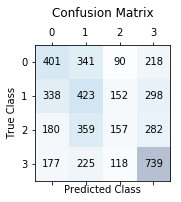


CV Accuracy: 39.170 +/- 0.710
Scores: [38.03 39.07 39.78 40.04 38.94]


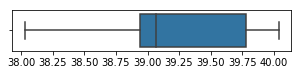


CV CohenKappa: 0.299 +/- 0.024
Scores: [0.257 0.314 0.32  0.289 0.318]


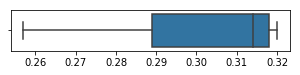

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Tree 1 (defaults),35.37,0.2278,33.71,32.20,28.53,45.12,"[32.33, 32.8, 28.01, 46.63]","[354, 390, 279, 568]","[741, 799, 717, 650]","[696, 821, 699, 691]","{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0,...","{'Accuracy': (36.16, 0.76), 'CohenKappa': (0.227, 0.018)}"
1,Tree 2 (max_features=50%),35.02,0.1971,32.10,32.12,29.04,44.88,"[31.06, 31.89, 29.43, 46.01]","[337, 389, 284, 565]","[748, 831, 681, 663]","[713, 822, 694, 694]","{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.5, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, ...","{'Accuracy': (35.54, 0.72), 'CohenKappa': (0.224, 0.021)}"
2,"Tree 3 (max_leaf=250, max_features=all)",38.24,0.3133,38.19,34.93,16.05,58.70,"[36.59, 31.38, 30.37, 48.08]","[401, 423, 157, 739]","[695, 925, 360, 798]","[649, 788, 821, 520]","{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 250, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, ...","{'Accuracy': (39.17, 0.71), 'CohenKappa': (0.299, 0.024)}"


In [13]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
clf_dt3 = DecisionTreeClassifier(random_state=RANDOM_SEED, max_features=None, max_leaf_nodes=250)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_dt3
model_label        = 'Tree 3 (max_leaf=250, max_features=all)'
model_results_list = model_results_dt

dt_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
dt_results_df

#### Quick Thoughts on Results
- Yay! Progress!  **A nice jump in CohenKappa (0.31** from 0.22 (model 1))
- TPR better in most classes (3-59%, 1-38% (from 33), 2-up a little, but 3 (2-3 months) declines sharply 16% (from 29).
  - for Class 2 - a lot more FN (821) than FP (360).  
  - for Class 1 & 3 - more FP than FN. 
  - Class 0 balanced in FP & FN
- In CV results, std (variance) is creeping up on CohenKappa (mean=0.299, std=0.024)

In [14]:
#------------------------------------------------------------
# Explore Decision Tree
#------------------------------------------------------------
model = clf_dt3
print("Depth of Decision Tree  :", model.tree_.max_depth)
print("Nodes in Decision Tree  :", model.tree_.node_count) # internal + leaves
print("Leaves in Decision Tree :", int(np.round((model.tree_.node_count/2)+1,0)))
print("Max Features at Split   :", model.max_features_)

print("\n- - - - Top Features - - - -")
feature_importance_df = pd.DataFrame(model.feature_importances_, 
                                     index=feature_labels, columns=['Importance'])

feature_importance_df[feature_importance_df.Importance!=0] \
    .sort_values(by='Importance', ascending=False) \
    .head(10)

Depth of Decision Tree  : 15
Nodes in Decision Tree  : 499
Leaves in Decision Tree : 250
Max Features at Split   : 75

- - - - Top Features - - - -


,Importance
NbrProfiles,0.208279
Age,0.162966
PhotoAmt,0.097034
DescSentimentMagnitude,0.078039
PrimaryBreed_MixedBreed,0.073261
DescNbrSentences,0.045678
PrimaryBreed_DomesticShortHair,0.031075
Sterilized_No,0.027778
DescSentimentScore,0.027225
Type_Cat,0.026495


#### Quick Thoughts on Results
- Tree is 15 levels depth and grew to the constraint of 250 leaf nodes.
- Now we start to see a different mix of important features
  - Still include NbrProfile (by rescuer), Age, Photos, sentiment around the text description in profile.
  - But now breed info - most common breeds (MixedBreed for dogs, DomesticShortHair for cats).
  - And whether animal is intact (Sterilized_No).

<a id="model_dt4"></a>
## Decision Tree 4 - Grid Search Pass 2 - Max Leaf Nodes
[Back to Decision Trees](#model_decision_tree)

We hit the lower limit of the range I provided for max_leaf_nodes.  Let's do a second pass with smaller values to see if we can find an even better constraint on the size of the tree.  We will continue allow all (100%) of the features to be considered at each split as the tree is constructed.

In [15]:
#------------------------------------------------------------
# create classifier
#------------------------------------------------------------
clf_dt4 = DecisionTreeClassifier(random_state=RANDOM_SEED, max_features=None)
model = clf_dt4

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 5-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------

param_grid  = {'max_leaf_nodes':[5, 25, 50, 75, 100, 150, 200, 225]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=5)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'max_leaf_nodes': 150}

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=150,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=114,
            splitter='best')


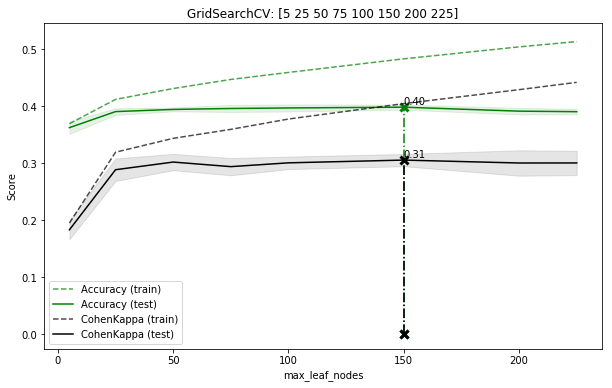

In [16]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
param_name = 'max_leaf_nodes'
plt.figure(figsize=(10,6))
plot_grid_search_results(grid_search_results=gs.cv_results_, 
                         param_name=param_name, 
                         plot_dataset='Both')

In [17]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
#print('Params: ', gs.cv_results_['params'])
print('Params     :', gs.cv_results_['param_'+param_name].data)

print('\nTest Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_test_CohenKappa'], 3))
print('Rank       :', gs.cv_results_['rank_test_CohenKappa'])

print('\nTrain Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_train_CohenKappa'], 3))


Params     : [5 25 50 75 100 150 200 225]

Test Results
Accuracy   : [36.25 39.07 39.45 39.61 39.7  39.84 39.14 39.05]
CohenKappa : [0.183 0.289 0.302 0.294 0.301 0.306 0.3   0.3  ]
Rank       : [8 7 2 6 3 1 5 4]

Train Results
Accuracy   : [36.94 41.21 43.11 44.71 45.94 48.33 50.43 51.36]
CohenKappa : [0.195 0.319 0.344 0.359 0.378 0.405 0.429 0.442]



Accuracy      : 39.28
Cohen's Kappa : 0.3258

Classification Report
              precision    recall  f1-score   support

           0       0.39      0.34      0.37      1050
           1       0.32      0.41      0.36      1211
           2       0.32      0.13      0.19       978
           3       0.48      0.62      0.54      1259

   micro avg       0.39      0.39      0.39      4498
   macro avg       0.38      0.38      0.36      4498
weighted avg       0.38      0.39      0.38      4498



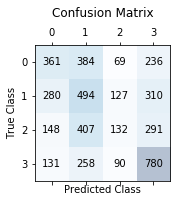


CV Accuracy: 39.840 +/- 0.450
Scores: [38.98 39.88 40.11 40.28 39.94]


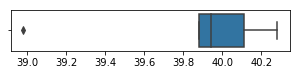


CV CohenKappa: 0.306 +/- 0.011
Scores: [0.286 0.315 0.31  0.302 0.315]


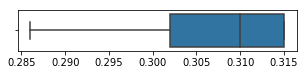

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Tree 1 (defaults),35.37,0.2278,33.71,32.20,28.53,45.12,"[32.33, 32.8, 28.01, 46.63]","[354, 390, 279, 568]","[741, 799, 717, 650]","[696, 821, 699, 691]","{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0,...","{'Accuracy': (36.16, 0.76), 'CohenKappa': (0.227, 0.018)}"
1,Tree 2 (max_features=50%),35.02,0.1971,32.10,32.12,29.04,44.88,"[31.06, 31.89, 29.43, 46.01]","[337, 389, 284, 565]","[748, 831, 681, 663]","[713, 822, 694, 694]","{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.5, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, ...","{'Accuracy': (35.54, 0.72), 'CohenKappa': (0.224, 0.021)}"
2,"Tree 3 (max_leaf=250, max_features=all)",38.24,0.3133,38.19,34.93,16.05,58.70,"[36.59, 31.38, 30.37, 48.08]","[401, 423, 157, 739]","[695, 925, 360, 798]","[649, 788, 821, 520]","{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 250, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, ...","{'Accuracy': (39.17, 0.71), 'CohenKappa': (0.299, 0.024)}"
3,"Tree 4 (max_leaf=150, max_features=all)",39.28,0.3258,34.38,40.79,13.50,61.95,"[39.24, 32.02, 31.58, 48.24]","[361, 494, 132, 780]","[559, 1049, 286, 837]","[689, 717, 846, 479]","{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 150, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, ...","{'Accuracy': (39.84, 0.45), 'CohenKappa': (0.306, 0.011)}"


In [18]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
clf_dt4 = DecisionTreeClassifier(random_state=RANDOM_SEED, max_features=None, max_leaf_nodes=150)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_dt4
model_label        = 'Tree 4 (max_leaf=150, max_features=all)'
model_results_list = model_results_dt

dt_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
dt_results_df

#### Quick Thoughts on Results
- A smaller tree (150 leaf nodes) is a little better than 250 leaves.
- Both Accuracy and CohenKappa improve.
- There is a shift in TPR by class - Class 1 & 3 improve and Class 0 & 2 decline.
- There is low variation in the CV results, so less likely overfitting the data.

In [19]:
#------------------------------------------------------------
# Explore Decision Tree
#------------------------------------------------------------
model = clf_dt4
print("Depth of Decision Tree  :", model.tree_.max_depth)
print("Nodes in Decision Tree  :", model.tree_.node_count) # internal + leaves
print("Leaves in Decision Tree :", int(np.round((model.tree_.node_count/2)+1,0)))
print("Max Features at Split   :", model.max_features_)

print("\n- - - - Top Features - - - -")
feature_importance_df = pd.DataFrame(model.feature_importances_, 
                                     index=feature_labels, columns=['Importance'])

feature_importance_df[feature_importance_df.Importance!=0] \
    .sort_values(by='Importance', ascending=False) \
    .head(10)

Depth of Decision Tree  : 13
Nodes in Decision Tree  : 299
Leaves in Decision Tree : 150
Max Features at Split   : 75

- - - - Top Features - - - -


,Importance
NbrProfiles,0.225732
Age,0.181151
PhotoAmt,0.100944
PrimaryBreed_MixedBreed,0.089787
DescSentimentMagnitude,0.060478
DescNbrSentences,0.046907
Type_Cat,0.033361
Sterilized_No,0.032071
PrimaryBreed_DomesticShortHair,0.028296
Gender_Male,0.021205


#### Quick Thoughts on Results
- The Tree is a little smaller at 13 levels deep and grew to the constraint of 150 leaf nodes.
- The important features are generally the same set.

In [20]:
dt_results_df.to_csv('results_dt.csv', index=False)

## Thoughts on Decision Trees

None of the Decision Tree models appear to be great at this point.  Accuracy varies between 35-40%.  The models are definitely above chance but do not have a great Cohen Kappa score (a range of 0.20 - 0.33).  But it is encouraging to see improvement with smaller trees.  The models are consistently best at predicting the animals that will take the longest to adopt (TPR 45-61%) and struggles to identify the animals that take 2-3 months to be adopted.  As the models are tuned the TPR of Class 2 (2-3 months) declines.  PPV for the classes is not great - the model is correct in its adoption speed prediction 31-48% of the time.

Tree 4 is the best version of the Decision Tree models.

<a id="model_knn"></a>
# KNN
[Table of Contents](#TOC)

Models/Tunings:
- [Default Values](#model_knn1)
- [Change distance metric](#model_knn2) - manhattan distance
- [Grid Search - Number of Neighbors](#model_knn3) k=[3, 7, 9] using manhattan distance

*Links to Documentation*
- [Nearest Neighbors Clasification](https://scikit-learn.org/0.20/modules/neighbors.html#nearest-neighbors-classification)
- [KNeighborsClassifier](https://scikit-learn.org/0.20/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [24]:
model_results_knn = []

<a id="model_knn1"></a>
## KNN 1 - Defaults
[Back to KNN](#model_knn)

Notable Default Values:
- n_neighbors = 5
- metric='minkowski'
- p=2 (euclidean distance)


Accuracy      : 31.95
Cohen's Kappa : 0.1747

Classification Report
              precision    recall  f1-score   support

           0       0.31      0.40      0.35      1050
           1       0.29      0.33      0.31      1211
           2       0.26      0.20      0.23       978
           3       0.41      0.34      0.37      1259

   micro avg       0.32      0.32      0.32      4498
   macro avg       0.32      0.32      0.31      4498
weighted avg       0.32      0.32      0.32      4498



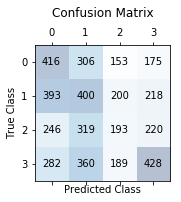


CV Accuracy: 32.630 +/- 0.420
Scores: [32.6  32.21 33.16 33.03 32.13]


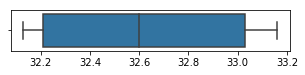


CV CohenKappa: 0.177 +/- 0.016
Scores: [0.164 0.202 0.188 0.16  0.17 ]


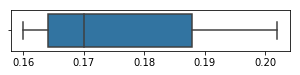

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,KNN 1 (defaults),31.95,0.1747,39.62,33.03,19.73,34.0,"[31.11, 28.88, 26.26, 41.11]","[416, 400, 193, 428]","[921, 985, 542, 613]","[634, 811, 785, 831]","{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}","{'Accuracy': (32.63, 0.42), 'CohenKappa': (0.177, 0.016)}"


In [26]:
from sklearn.neighbors import KNeighborsClassifier

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_knn1 = KNeighborsClassifier()

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_knn1
model_label        = 'KNN 1 (defaults)'
model_results_list = model_results_knn

knn_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
knn_results_df

#### Quick Thoughts on Results
- The initial KNN model is worse than any of the Decision Tree models - lower Accuracy, CohenKappa
- KNN 1 does best on Class 0 but only finds 40% of the pets that will be adopted in the first week.

<a id="model_knn2"></a>
## KNN 2 - Manhattan Distance
[Back to KNN](#model_knn)

Let's try Manhattan as the distance measurement vs. the default of Euclidean.


Accuracy      : 32.28
Cohen's Kappa : 0.1809

Classification Report
              precision    recall  f1-score   support

           0       0.32      0.41      0.36      1050
           1       0.29      0.33      0.31      1211
           2       0.26      0.19      0.22       978
           3       0.42      0.34      0.37      1259

   micro avg       0.32      0.32      0.32      4498
   macro avg       0.32      0.32      0.32      4498
weighted avg       0.33      0.32      0.32      4498



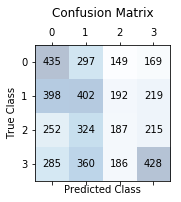


CV Accuracy: 32.650 +/- 0.430
Scores: [32.27 32.3  33.44 32.7  32.55]


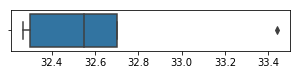


CV CohenKappa: 0.176 +/- 0.023
Scores: [0.156 0.215 0.186 0.151 0.171]


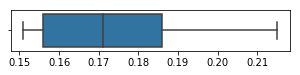

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,KNN 1 (defaults),31.95,0.1747,39.62,33.03,19.73,34.0,"[31.11, 28.88, 26.26, 41.11]","[416, 400, 193, 428]","[921, 985, 542, 613]","[634, 811, 785, 831]","{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}","{'Accuracy': (32.63, 0.42), 'CohenKappa': (0.177, 0.016)}"
1,KNN 2 (manhat. dist.),32.28,0.1809,41.43,33.20,19.12,34.0,"[31.75, 29.07, 26.19, 41.51]","[435, 402, 187, 428]","[935, 981, 527, 603]","[615, 809, 791, 831]","{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}","{'Accuracy': (32.65, 0.43), 'CohenKappa': (0.176, 0.023)}"


In [29]:
#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_knn2 = KNeighborsClassifier(p=1)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_knn2
model_label        = 'KNN 2 (manhat. dist.)'
model_results_list = model_results_knn

knn_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
knn_results_df

#### Quick Thoughts on Results
- Manhattan distance is a tiny bit better with 5 neighbors.  But still worse than any of the Decision Tree models.

<a id="model_knn3"></a>
## KNN 3 - Grid Search on Number of Neighbors
[Back to KNN](#model_knn)

Grid search on n_neighbors [3, 7, 9] using manhattan distance.  I have info on n_neighbors=5 from model above (KNN 2).  Let's keep Manhattan as the distance measurement vs. the default of Euclidean.

In [30]:
#------------------------------------------------------------
# create classifier
#------------------------------------------------------------
clf_knn3 = KNeighborsClassifier(p=1)
model = clf_knn3

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 5-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------
param_grid  = {'n_neighbors':[3, 7, 9]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=5)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'n_neighbors': 9}

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=1,
           weights='uniform')


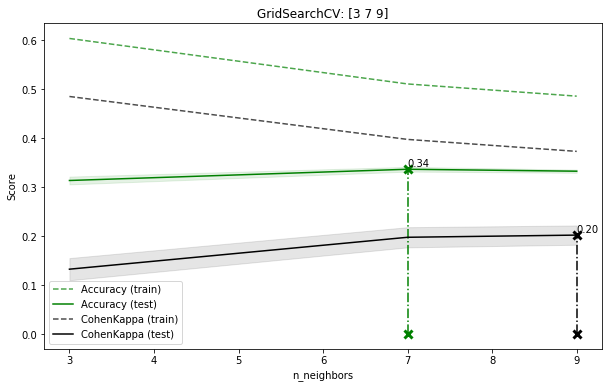

In [31]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
param_name = 'n_neighbors'
plt.figure(figsize=(10,6))
plot_grid_search_results(grid_search_results=gs.cv_results_, 
                         param_name=param_name, 
                         plot_dataset='Both')

In [32]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
#print('Params: ', gs.cv_results_['params'])
print('Params     :', gs.cv_results_['param_'+param_name].data)
print('\nTest Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_test_CohenKappa'], 3))
print('Rank       :', gs.cv_results_['rank_test_CohenKappa'])

print('\nTrain Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_train_CohenKappa'], 3))

Params     : [3 7 9]

Test Results
Accuracy   : [31.34 33.64 33.23]
CohenKappa : [0.132 0.198 0.202]
Rank       : [3 2 1]

Train Results
Accuracy   : [60.32 51.04 48.55]
CohenKappa : [0.485 0.397 0.373]


#### Try a few more values, since the best is at the range boundary

In [33]:
#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 5-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------
param_grid  = {'n_neighbors':[11, 13, 15]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=5)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'n_neighbors': 15}

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=1,
           weights='uniform')


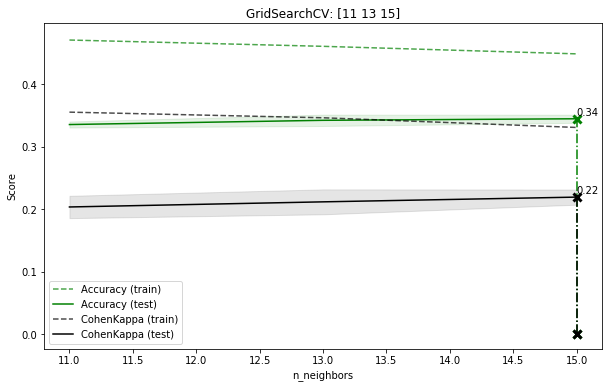

Params     : [11 13 15]

Test Results
Accuracy   : [33.53 34.21 34.45]
CohenKappa : [0.203 0.212 0.219]
Rank       : [3 2 1]

Train Results
Accuracy   : [47.05 46.05 44.84]
CohenKappa : [0.355 0.346 0.331]


In [35]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
param_name = 'n_neighbors'
plt.figure(figsize=(10,6))
plot_grid_search_results(grid_search_results=gs.cv_results_, 
                         param_name=param_name, 
                         plot_dataset='Both')

#print('Params: ', gs.cv_results_['params'])
print('Params     :', gs.cv_results_['param_'+param_name].data)
print('\nTest Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_test_CohenKappa'], 3))
print('Rank       :', gs.cv_results_['rank_test_CohenKappa'])

print('\nTrain Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_train_CohenKappa'], 3))

#### Again, try a few more values, since the best is at the range boundary

In [36]:
#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 5-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------
param_grid  = {'n_neighbors':[19, 23, 31]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=5)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'n_neighbors': 31}

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=31, p=1,
           weights='uniform')


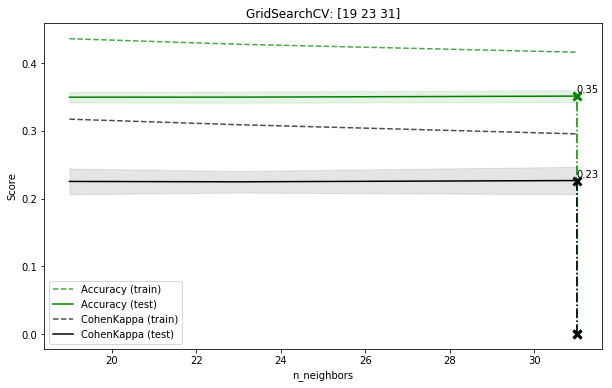

Params     : [19 23 31]

Test Results
Accuracy   : [35.   35.01 35.16]
CohenKappa : [0.226 0.225 0.227]
Rank       : [2 3 1]

Train Results
Accuracy   : [43.64 42.82 41.65]
CohenKappa : [0.318 0.309 0.296]


In [37]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
param_name = 'n_neighbors'
plt.figure(figsize=(10,6))
plot_grid_search_results(grid_search_results=gs.cv_results_, 
                         param_name=param_name, 
                         plot_dataset='Both')

#print('Params: ', gs.cv_results_['params'])
print('Params     :', gs.cv_results_['param_'+param_name].data)
print('\nTest Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_test_CohenKappa'], 3))
print('Rank       :', gs.cv_results_['rank_test_CohenKappa'])

print('\nTrain Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_train_CohenKappa'], 3))

#### Quick Thoughts on Results
- More neighbors improve performance, but not dramatically. Accuracy is in the mid-30s and CohenKappa at 0.23.
- Let's move on with k=31.


Accuracy      : 35.59
Cohen's Kappa : 0.2348

Classification Report
              precision    recall  f1-score   support

           0       0.35      0.37      0.36      1050
           1       0.30      0.35      0.32      1211
           2       0.32      0.14      0.20       978
           3       0.42      0.51      0.46      1259

   micro avg       0.36      0.36      0.36      4498
   macro avg       0.35      0.34      0.34      4498
weighted avg       0.35      0.36      0.34      4498



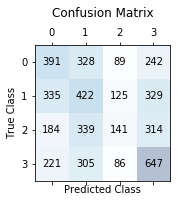


CV Accuracy: 35.160 +/- 0.880
Scores: [34.32 34.06 36.4  35.84 35.18]


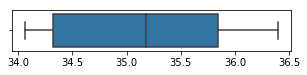


CV CohenKappa: 0.227 +/- 0.020
Scores: [0.213 0.24  0.26  0.207 0.214]


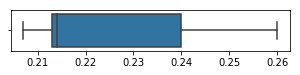

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,KNN 1 (defaults),31.95,0.1747,39.62,33.03,19.73,34.00,"[31.11, 28.88, 26.26, 41.11]","[416, 400, 193, 428]","[921, 985, 542, 613]","[634, 811, 785, 831]","{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}","{'Accuracy': (32.63, 0.42), 'CohenKappa': (0.177, 0.016)}"
1,KNN 2 (manhat. dist.),32.28,0.1809,41.43,33.20,19.12,34.00,"[31.75, 29.07, 26.19, 41.51]","[435, 402, 187, 428]","[935, 981, 527, 603]","[615, 809, 791, 831]","{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}","{'Accuracy': (32.65, 0.43), 'CohenKappa': (0.176, 0.023)}"
2,"KNN3 (k=31, manhat. dist.)",35.59,0.2348,37.24,34.85,14.42,51.39,"[34.57, 30.27, 31.97, 42.23]","[391, 422, 141, 647]","[740, 972, 300, 885]","[659, 789, 837, 612]","{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 31, 'p': 1, 'weights': 'uniform'}","{'Accuracy': (35.16, 0.88), 'CohenKappa': (0.227, 0.02)}"


In [38]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
clf_knn3 = KNeighborsClassifier(p=1, n_neighbors=31)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_knn3
model_label        = 'KNN3 (k=31, manhat. dist.)'
model_results_list = model_results_knn

knn_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
knn_results_df

#### Quick Thoughts on Results
- Improvement! But still poor results Accuracy 36%, CohenKappa=0.23.

In [39]:
knn_results_df.to_csv('results_knn.csv', index=False)

## Thoughts on KNN

Generally, poor results: Accuracy 32-36% and CohenKappa 0.18-0.23.  There was improvement with a large number of neighbors (31).  Perhaps even more neighbors might help, but we have a long way to go and the Decision Trees were generally better.

<a id="model_random_forest"></a>
# Random Forests
[Table of Contents](#TOC)

Models/Tunings:
- [Default Values](#model_rf1)
- [Use OOB to Select Nbr Trees and Features](#model_rf2)
- [Grid Search on max_leaf_nodes](#model_rf3) - limit size of tree (by leaf_nodes)

*Links to Documentation*
- [Random Forest](https://scikit-learn.org/0.20/modules/ensemble.html#forests-of-randomized-trees)
- [RandomForestClassifier](https://scikit-learn.org/0.20/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [4]:
model_results_rf = []

<a id="model_rf1"></a>
## Random Forest 1 - Default Values
[Back to Random Forests](#model_random_forest)

I set the number of trees to 100 which is the default in version 0.22 (vs. the current default of 10 trees, which is kind of small).


Accuracy      : 43.53
Cohen's Kappa : 0.3724

Classification Report
              precision    recall  f1-score   support

           0       0.41      0.42      0.41      1050
           1       0.37      0.36      0.36      1211
           2       0.37      0.24      0.29       978
           3       0.52      0.68      0.59      1259

   micro avg       0.44      0.44      0.44      4498
   macro avg       0.42      0.42      0.41      4498
weighted avg       0.42      0.44      0.42      4498



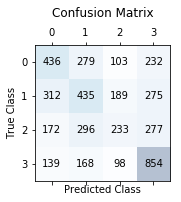


CV Accuracy: 43.710 +/- 0.990
Scores: [43.41 42.97 45.35 44.23 42.56]


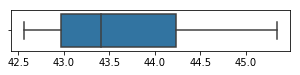


CV CohenKappa: 0.350 +/- 0.026
Scores: [0.347 0.373 0.386 0.317 0.327]


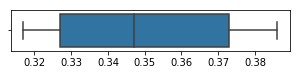

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Forest 1 (defaults),43.53,0.3724,41.52,35.92,23.82,67.83,"[41.17, 36.93, 37.4, 52.14]","[436, 435, 233, 854]","[623, 743, 390, 784]","[614, 776, 745, 405]","{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight...","{'Accuracy': (43.71, 0.99), 'CohenKappa': (0.35, 0.026)}"


In [5]:
from sklearn.ensemble import RandomForestClassifier

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_rf1 = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_rf1
model_label        = 'Forest 1 (defaults)'
model_results_list = model_results_rf

rf_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
rf_results_df

In [8]:
#------------------------------------------------------------
# Explore Forest
#------------------------------------------------------------
model = clf_rf1
print("Nbr of Trees:", len(model.estimators_))

print("\n- - - - Top Features - - - -")
feature_importance_df = pd.DataFrame(model.feature_importances_, 
                                     index=feature_labels, columns=['Importance'])

feature_importance_df[feature_importance_df.Importance!=0] \
    .sort_values(by='Importance', ascending=False) \
    .head(10)

Nbr of Trees: 100

- - - - Top Features - - - -


,Importance
NbrProfiles,0.088490
DescSentimentMagnitude,0.088374
PhotoAmt,0.076869
Age,0.076849
DescSentimentScore,0.069584
DescNbrSentences,0.068687
Quantity,0.025491
Fee,0.022838
Color1_Black,0.018850
Gender_Female,0.016640


#### Quick Thoughts on Results
- **The best results so far!**  Accuracy 44%, CohenKappa 0.37, Class 3 TPR 68%, Class 1 TPR 36%, higher PPVs as well.
- Also not too much variation in CV results.
- Similar Top Features as with Decision Trees

<a id="model_rf2"></a>
## Random Forest 2 - Use OOB to Select Number of Trees & Features
[Back to Random Forests](#model_random_forest)

Look at OOB error to determine when additional trees stops/slows a decline in the error rate.  Here I also consider 3 approaches to the number of features (sqrt, log2 and max/all features) to consider at each split.

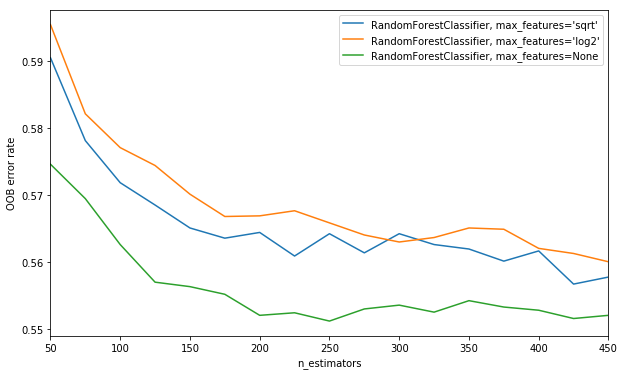

OrderedDict([("RandomForestClassifier, max_features='sqrt'", [(50, 0.5904716531681753), (75, 0.5780848022868033), (100, 0.571796093377799), (125, 0.5684611719866604), (150, 0.5650309671272034), (175, 0.5635064316341114), (200, 0.5643639828489757), (225, 0.5608384945212006), (250, 0.5641734159123393), (275, 0.5613149118627918), (300, 0.5641734159123393), (325, 0.562553596950929), (350, 0.5618866126727013), (375, 0.5600762267746546), (400, 0.5616007622677466), (425, 0.5566460219151976), (450, 0.5576941400666984)]), ("RandomForestClassifier, max_features='log2'", [(50, 0.5954263935207241), (75, 0.5820867079561696), (100, 0.5770366841353025), (125, 0.5743687470223916), (150, 0.5700809909480705), (175, 0.5667460695569319), (200, 0.5668413530252501), (225, 0.567603620771796), (250, 0.5657932348737493), (275, 0.5639828489757027), (300, 0.562934730824202), (325, 0.5636017151024297), (350, 0.5650309671272034), (375, 0.5648404001905669), (400, 0.5619818961410195), (425, 0.5612196283944735), (450

In [12]:
# code from ...
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py
X, y = features_train, target_train

from collections import OrderedDict

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_SEED)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_SEED)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_SEED))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators  = 50
max_estimators  = 450
step_estimators = 25

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators+1, step_estimators):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
plt.figure(figsize=(10,6))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

print(error_rate)

#### Quick Thoughts on Results
- Having all features available at each split has a lower error rate (vs limiting to log2 or sqrt of the 75 features).
- Lowest error is at 250 trees.


Accuracy      : 43.37
Cohen's Kappa : 0.3744

Classification Report
              precision    recall  f1-score   support

           0       0.41      0.41      0.41      1050
           1       0.36      0.36      0.36      1211
           2       0.37      0.26      0.30       978
           3       0.53      0.66      0.59      1259

   micro avg       0.43      0.43      0.43      4498
   macro avg       0.42      0.42      0.42      4498
weighted avg       0.42      0.43      0.42      4498



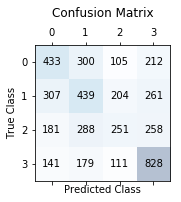


CV Accuracy: 44.740 +/- 0.640
Scores: [44.55 45.02 45.59 43.66 44.85]


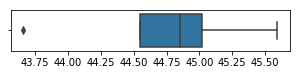


CV CohenKappa: 0.369 +/- 0.034
Scores: [0.343 0.403 0.404 0.318 0.374]


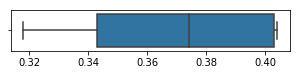

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Forest 1 (defaults),43.53,0.3724,41.52,35.92,23.82,67.83,"[41.17, 36.93, 37.4, 52.14]","[436, 435, 233, 854]","[623, 743, 390, 784]","[614, 776, 745, 405]","{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight...","{'Accuracy': (43.71, 0.99), 'CohenKappa': (0.35, 0.026)}"
1,"Forest 2 (250 trees, max_features)",43.37,0.3744,41.24,36.25,25.66,65.77,"[40.77, 36.4, 37.41, 53.11]","[433, 439, 251, 828]","[629, 767, 420, 731]","[617, 772, 727, 431]","{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_f...","{'Accuracy': (44.74, 0.64), 'CohenKappa': (0.369, 0.034)}"


In [13]:
#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_rf2 = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=250, max_features=None)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_rf2
model_label        = 'Forest 2 (250 trees, max_features)'
model_results_list = model_results_rf

rf_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
rf_results_df

#### Quick Thoughts on Results
- Significantly more trees in the forest (250 vs. 100) produces very similar results, so no need for so many more trees.

<a id="model_rf3"></a>
## Random Forest 3 - Grid Search - Max Leaf Nodes
[Back to Random Forests](#model_random_forest)

Results improved by limiting the size of individual Decision Trees.  Let's explore tree size within the Random Forest.  I will return to configuration for Forest 1 with 100 trees.

In [14]:
#------------------------------------------------------------
# create classifier
#------------------------------------------------------------
clf_rf3 = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, max_features=None)
model = clf_rf3

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 5-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------

param_grid  = {'max_leaf_nodes':[5, 25, 50, 100, 150, 200, 250, 300]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=5)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'max_leaf_nodes': 300}

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=300,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=114, verbose=0, warm_start=False)


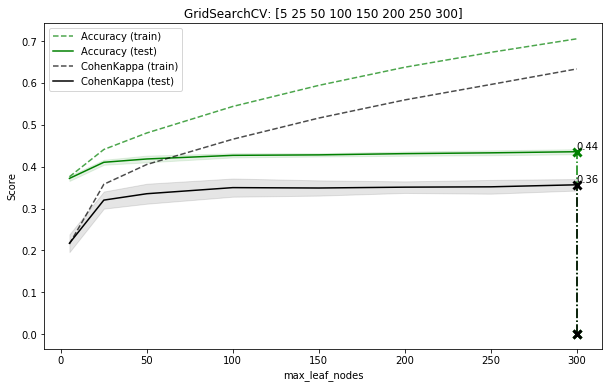

Params     : [5 25 50 100 150 200 250 300]

Test Results
Accuracy   : [37.2  41.05 41.84 42.71 42.82 43.12 43.31 43.57]
CohenKappa : [0.217 0.32  0.335 0.35  0.349 0.351 0.352 0.357]
Rank       : [8 7 6 4 5 3 2 1]

Train Results
Accuracy   : [37.6  44.11 48.05 54.39 59.42 63.76 67.32 70.55]
CohenKappa : [0.215 0.358 0.405 0.466 0.516 0.559 0.596 0.634]


In [15]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
param_name = 'max_leaf_nodes'
plt.figure(figsize=(10,6))
plot_grid_search_results(grid_search_results=gs.cv_results_, 
                         param_name=param_name, 
                         plot_dataset='Both')

#print('Params: ', gs.cv_results_['params'])
print('Params     :', gs.cv_results_['param_'+param_name].data)
print('\nTest Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_test_CohenKappa'], 3))
print('Rank       :', gs.cv_results_['rank_test_CohenKappa'])

print('\nTrain Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_train_CohenKappa'], 3))

#### Quick Thoughts on Results
- Improvement starts to level off at trees with a max of 100 leaf nodes.  Let's use that value.


Accuracy      : 42.13
Cohen's Kappa : 0.3599

Classification Report
              precision    recall  f1-score   support

           0       0.39      0.43      0.41      1050
           1       0.34      0.33      0.34      1211
           2       0.40      0.17      0.24       978
           3       0.49      0.70      0.58      1259

   micro avg       0.42      0.42      0.42      4498
   macro avg       0.41      0.41      0.39      4498
weighted avg       0.41      0.42      0.40      4498



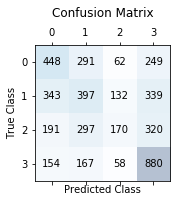


CV Accuracy: 42.710 +/- 0.500
Scores: [43.03 43.54 42.31 42.42 42.23]


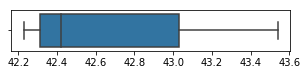


CV CohenKappa: 0.350 +/- 0.022
Scores: [0.355 0.383 0.357 0.317 0.339]


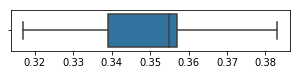

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Forest 1 (defaults),43.53,0.3724,41.52,35.92,23.82,67.83,"[41.17, 36.93, 37.4, 52.14]","[436, 435, 233, 854]","[623, 743, 390, 784]","[614, 776, 745, 405]","{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight...","{'Accuracy': (43.71, 0.99), 'CohenKappa': (0.35, 0.026)}"
1,"Forest 2 (250 trees, max_features)",43.37,0.3744,41.24,36.25,25.66,65.77,"[40.77, 36.4, 37.41, 53.11]","[433, 439, 251, 828]","[629, 767, 420, 731]","[617, 772, 727, 431]","{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_f...","{'Accuracy': (44.74, 0.64), 'CohenKappa': (0.369, 0.034)}"
2,"Forest 3 (default, max_leaf=100)",42.13,0.3599,42.67,32.78,17.38,69.90,"[39.44, 34.46, 40.28, 49.22]","[448, 397, 170, 880]","[688, 755, 252, 908]","[602, 814, 808, 379]","{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fr...","{'Accuracy': (42.71, 0.5), 'CohenKappa': (0.35, 0.022)}"


In [16]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
clf_rf3 = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, max_features=None, max_leaf_nodes=100)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_rf3
model_label        = 'Forest 3 (default, max_leaf=100)'
model_results_list = model_results_rf

rf_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
rf_results_df

#### Quick Thoughts on Results
- Constraining the size of the tree (to 100 leaves) made the results a tiny bit worse.  There was just a slight switch in which classes the model predicts correctly or misses.

In [18]:
rf_results_df.to_csv('results_rf.csv', index=False)

## Thoughts on Random Forests

It was encouraging to see the **best results so far** with the default values (and 100 trees) in a Random Forest.  Tuning the number of trees, features to consider at each split and the size of the trees (by max_leaf_nodes) did not move the needle much.  Forest 2 is technically the best (highest Cohen Kappa score), but the tiny improvement (2/1000) is not worth 2.5 times as many trees in the forest.  

I declare **Forest 1 the best Random Forest approach and leading model so far**.  

*(In 2nd place, is Tree 4 (max_leaf=150) with a Cohen Kappa of 0.3258 vs. 0.3724 and Accuracy of 39% vs. 43.5%)*

<a id="model_extra_trees"></a>
# Extremely Randomized Trees
[Table of Contents](#TOC)

Models/Tunings:
- [Default Values](#model_xt1)
- [Use OOB to Select Nbr Trees and Features](#model_xt2)
- [Grid Search on max_leaf_nodes](#model_xt3) - limit size of tree (by leaf_nodes)

*Links to Documentation*
- [Extremely Randomized Trees](https://scikit-learn.org/0.20/modules/ensemble.html#extremely-randomized-trees)
- [ExtraTreesClassifier](https://scikit-learn.org/0.20/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)

In [5]:
model_results_xt = []

<a id="model_xt1"></a>
## Extra Trees 1 - Default Values
[Back to Extremely Randomized Trees](#model_extra_trees)

I set the number of trees to 100 which is the default in version 0.22 (vs. the current default of 10 tree which is kind of small).


Accuracy      : 38.57
Cohen's Kappa : 0.2813

Classification Report
              precision    recall  f1-score   support

           0       0.37      0.39      0.38      1050
           1       0.34      0.36      0.35      1211
           2       0.31      0.24      0.27       978
           3       0.48      0.52      0.50      1259

   micro avg       0.39      0.39      0.39      4498
   macro avg       0.38      0.38      0.37      4498
weighted avg       0.38      0.39      0.38      4498



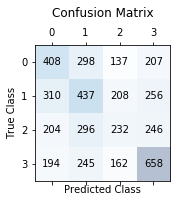


CV Accuracy: 38.940 +/- 0.830
Scores: [37.98 38.26 39.26 40.32 38.89]


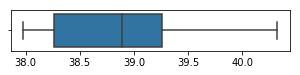


CV CohenKappa: 0.273 +/- 0.016
Scores: [0.25  0.291 0.292 0.267 0.267]


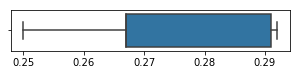

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,XTree 1 (defaults),38.57,0.2813,38.86,36.09,23.72,52.26,"[36.56, 34.25, 31.39, 48.13]","[408, 437, 232, 658]","[708, 839, 507, 709]","[642, 774, 746, 601]","{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weigh...","{'Accuracy': (38.94, 0.83), 'CohenKappa': (0.273, 0.016)}"


In [6]:
from sklearn.ensemble import ExtraTreesClassifier

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_xt1 = ExtraTreesClassifier(random_state=RANDOM_SEED, n_estimators=100)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_xt1
model_label        = 'XTree 1 (defaults)'
model_results_list = model_results_xt

xt_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
xt_results_df

In [7]:
#------------------------------------------------------------
# Explore Forest of Extra Trees
#------------------------------------------------------------
model = clf_xt1
print("Nbr of Trees:", len(model.estimators_))

print("\n- - - - Top Features - - - -")
feature_importance_df = pd.DataFrame(model.feature_importances_, 
                                     index=feature_labels, columns=['Importance'])

feature_importance_df[feature_importance_df.Importance!=0] \
    .sort_values(by='Importance', ascending=False) \
    .head(10)

Nbr of Trees: 100

- - - - Top Features - - - -


,Importance
NbrProfiles,0.082265
DescSentimentMagnitude,0.076122
PhotoAmt,0.075726
Age,0.073953
DescSentimentScore,0.069378
DescNbrSentences,0.068559
Quantity,0.028495
Fee,0.026571
Color1_Black,0.019613
Color1_Brown,0.017675


#### Quick Thoughts on Results
- Not as strong as Random Forests, but an improvement over the initial untuned Decision Trees.
- There is some variation in CV results.
- Similar Top Features as with all the other Tree methods.

#### <a id="model_xt2"></a>
## Extra Trees 2 - Use OOB to Select Number of Trees & Features
[Back to Extremely Randomized Trees](#model_extra_trees)

Look at OOB error to determine when additional trees stops/slows a decline in the error rate.  Here I also consider four approaches to the number of features (sqrt, 25%, 67%, and max/all features) to consider at each split.

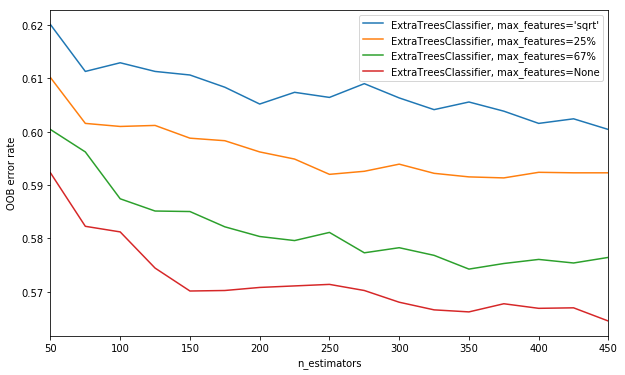

OrderedDict([("ExtraTreesClassifier, max_features='sqrt'", [(50, 0.6200095283468319), (75, 0.611243449261553), (100, 0.6128632682229633), (125, 0.611243449261553), (150, 0.6105764649833254), (175, 0.6082896617436875), (200, 0.6051453072891853), (225, 0.6073368270605051), (250, 0.6063839923773225), (275, 0.6089566460219151), (300, 0.6062887089090043), (325, 0.6040971891376846), (350, 0.6055264411624584), (375, 0.6038113387327299), (400, 0.6015245354930919), (425, 0.6023820867079561), (450, 0.600381133873273)]), ('ExtraTreesClassifier, max_features=25%', [(50, 0.6101000476417342), (75, 0.6015245354930919), (100, 0.6009528346831825), (125, 0.6011434016198189), (150, 0.5987613149118628), (175, 0.5982848975702715), (200, 0.5961886612672701), (225, 0.5948546927108147), (250, 0.5919961886612672), (275, 0.5925678894711768), (300, 0.5939018580276322), (325, 0.5921867555979038), (350, 0.591519771319676), (375, 0.5913292043830396), (400, 0.5923773225345403), (425, 0.592282039066222), (450, 0.5922

In [9]:
# code from ...
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py
X, y = features_train, target_train

from collections import OrderedDict

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.

ensemble_clfs = [
    ("ExtraTreesClassifier, max_features='sqrt'",
        ExtraTreesClassifier(n_estimators=100,
                               warm_start=True, oob_score=True, bootstrap=True,
                               max_features="sqrt",
                               random_state=RANDOM_SEED)),
    ("ExtraTreesClassifier, max_features=25%",
        ExtraTreesClassifier(n_estimators=100,
                               warm_start=True, max_features=0.25,
                               oob_score=True, bootstrap=True,
                               random_state=RANDOM_SEED)),
    ("ExtraTreesClassifier, max_features=67%",
        ExtraTreesClassifier(n_estimators=100,
                               warm_start=True, max_features=0.67,
                               oob_score=True, bootstrap=True,
                               random_state=RANDOM_SEED)),
    ("ExtraTreesClassifier, max_features=None",
        ExtraTreesClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               oob_score=True, bootstrap=True,
                               random_state=RANDOM_SEED))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators  = 50
max_estimators  = 450
step_estimators = 25

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators+1, step_estimators):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
plt.figure(figsize=(10,6))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

print(error_rate)

#### Quick Thoughts on Results
- The best results consider all features at each split.  And within the given parameter range (50-450), the lowest OOB error with 450 trees in the ensemble.


Accuracy      : 40.97
Cohen's Kappa : 0.3254

Classification Report
              precision    recall  f1-score   support

           0       0.38      0.39      0.39      1050
           1       0.36      0.37      0.36      1211
           2       0.33      0.26      0.29       978
           3       0.51      0.59      0.55      1259

   micro avg       0.41      0.41      0.41      4498
   macro avg       0.40      0.40      0.40      4498
weighted avg       0.40      0.41      0.40      4498



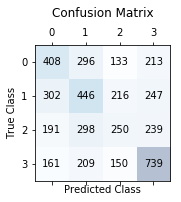


CV Accuracy: 41.520 +/- 1.020
Scores: [40.27 42.12 42.93 41.85 40.42]


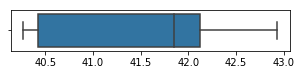


CV CohenKappa: 0.323 +/- 0.020
Scores: [0.303 0.35  0.344 0.305 0.312]


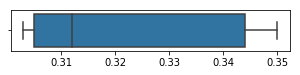

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,XTree 1 (defaults),38.57,0.2813,38.86,36.09,23.72,52.26,"[36.56, 34.25, 31.39, 48.13]","[408, 437, 232, 658]","[708, 839, 507, 709]","[642, 774, 746, 601]","{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weigh...","{'Accuracy': (38.94, 0.83), 'CohenKappa': (0.273, 0.016)}"
1,"XTree 2 (450 trees, max_features)",40.97,0.3254,38.86,36.83,25.56,58.70,"[38.42, 35.71, 33.38, 51.39]","[408, 446, 250, 739]","[654, 803, 499, 699]","[642, 765, 728, 520]","{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_...","{'Accuracy': (41.52, 1.02), 'CohenKappa': (0.323, 0.02)}"


In [12]:
#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_xt2 = ExtraTreesClassifier(random_state=RANDOM_SEED, n_estimators=450, max_features=None)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_xt2
model_label        = 'XTree 2 (450 trees, max_features)'
model_results_list = model_results_xt

xt_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
xt_results_df

#### Quick Thoughts on Results
- There is some improvement.  But the results are comparable to the tuned individual Decision Trees so no real advantage to use an ensemble of so many randomized trees.
- The documentation mentions Extra Trees usually reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.  I'm not getting strong result (high bias) and variance is on par with other techniques.

<a id="model_xt3"></a>
## Extra Trees 3 - Grid Search - Max Leaf Nodes
[Back to Extremely Randomized Trees](#model_extra_trees)

Results improved by limiting the size of individual Decision Trees.  Let's explore smaller trees with Extra Trees.  I will return to configuration for XTree 1 with 100 trees.

In [13]:
#------------------------------------------------------------
# create classifier
#------------------------------------------------------------
clf_xt3 = ExtraTreesClassifier(random_state=RANDOM_SEED, n_estimators=100)
model = clf_xt3

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 5-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------

param_grid  = {'max_leaf_nodes':[5, 25, 50, 100, 150, 200, 250, 300]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=5)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'max_leaf_nodes': 250}

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=250,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=114, verbose=0, warm_start=False)


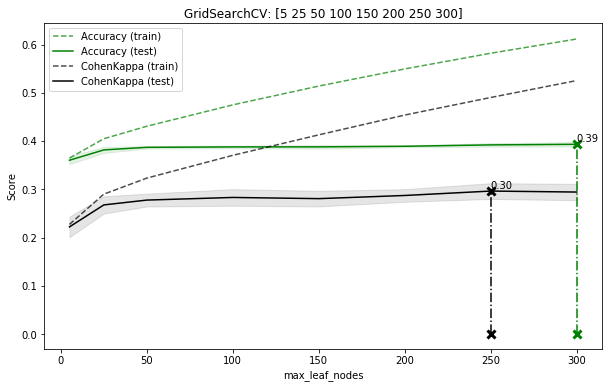

Params     : [5 25 50 100 150 200 250 300]

Test Results
Accuracy   : [36.02 38.16 38.69 38.78 38.79 38.91 39.2  39.32]
CohenKappa : [0.222 0.268 0.278 0.283 0.281 0.287 0.296 0.294]
Rank       : [8 7 6 4 5 3 1 2]

Train Results
Accuracy   : [36.46 40.48 43.06 47.49 51.39 54.94 58.19 61.14]
CohenKappa : [0.227 0.29  0.323 0.37  0.413 0.454 0.49  0.525]


In [14]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
param_name = 'max_leaf_nodes'
plt.figure(figsize=(10,6))
plot_grid_search_results(grid_search_results=gs.cv_results_, 
                         param_name=param_name, 
                         plot_dataset='Both')

#print('Params: ', gs.cv_results_['params'])
print('Params     :', gs.cv_results_['param_'+param_name].data)
print('\nTest Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_test_CohenKappa'], 3))
print('Rank       :', gs.cv_results_['rank_test_CohenKappa'])

print('\nTrain Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_train_CohenKappa'], 3))


Accuracy      : 39.68
Cohen's Kappa : 0.2991

Classification Report
              precision    recall  f1-score   support

           0       0.37      0.42      0.40      1050
           1       0.33      0.41      0.36      1211
           2       0.47      0.10      0.17       978
           3       0.47      0.59      0.52      1259

   micro avg       0.40      0.40      0.40      4498
   macro avg       0.41      0.38      0.36      4498
weighted avg       0.41      0.40      0.37      4498



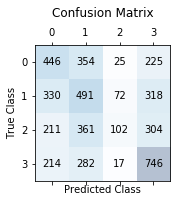


CV Accuracy: 39.200 +/- 0.370
Scores: [38.7  38.92 39.4  39.23 39.75]


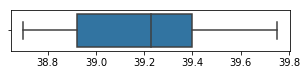


CV CohenKappa: 0.296 +/- 0.016
Scores: [0.271 0.299 0.312 0.286 0.314]


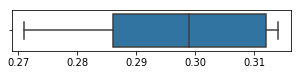

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,XTree 1 (defaults),38.57,0.2813,38.86,36.09,23.72,52.26,"[36.56, 34.25, 31.39, 48.13]","[408, 437, 232, 658]","[708, 839, 507, 709]","[642, 774, 746, 601]","{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weigh...","{'Accuracy': (38.94, 0.83), 'CohenKappa': (0.273, 0.016)}"
1,"XTree 2 (450 trees, max_features)",40.97,0.3254,38.86,36.83,25.56,58.70,"[38.42, 35.71, 33.38, 51.39]","[408, 446, 250, 739]","[654, 803, 499, 699]","[642, 765, 728, 520]","{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_...","{'Accuracy': (41.52, 1.02), 'CohenKappa': (0.323, 0.02)}"
2,"XTree 3 (default, max_leaf=250)",39.68,0.2991,42.48,40.55,10.43,59.25,"[37.14, 33.0, 47.22, 46.83]","[446, 491, 102, 746]","[755, 997, 114, 847]","[604, 720, 876, 513]","{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': 250, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight...","{'Accuracy': (39.2, 0.37), 'CohenKappa': (0.296, 0.016)}"


In [15]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
clf_xt3 = ExtraTreesClassifier(random_state=RANDOM_SEED, n_estimators=100, max_leaf_nodes=250)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_xt3
model_label        = 'XTree 3 (default, max_leaf=250)'
model_results_list = model_results_xt

xt_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
xt_results_df

#### Quick Thoughts on Results
- Limiting the size of the trees to 100 leaf nodes is a marginal improvement over the XTree 1, where tree size is not constrained.

In [17]:
xt_results_df.to_csv('results_xt.csv', index=False)

## Thoughts on Extremely Randomized Trees

The best Extra Tree Model is XTree 2 which uses 450 trees in the ensemble.  But those results are comparable with the tuned individual Decision Trees so there is no value in the ensemble.

<a id="model_svm_linear"></a>
# Support Vector Machine - Linear
[Table of Contents](#TOC)

Models/Tunings:
- [Default Values](#model_svml1)
- [Squared Hinge Loss Function](#model_svml2)
- [Grid Search on C](#model_svml3)

*Links to Documentation*
- [Support Vector Machines](https://scikit-learn.org/0.20/modules/svm.html)
- [LinearSVC](https://scikit-learn.org/0.20/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
- [SVC](https://scikit-learn.org/0.20/modules/generated/sklearn.svm.SVC.html)

In [4]:
model_results_svml = []

<a id="model_svml1"></a>
## SVM Linear 1 - Default Values
[Back to SVM Linear](#model_svm_linear)

Use LinearSVC (instead of SVC), set the loss function to 'hinge' to match approach used in SVC, and use default values for remaining parameters.


Accuracy      : 26.92
Cohen's Kappa : 0.1188

Classification Report
              precision    recall  f1-score   support

           0       0.32      0.26      0.29      1050
           1       0.25      0.24      0.24      1211
           2       0.21      0.43      0.28       978
           3       0.46      0.18      0.26      1259

   micro avg       0.27      0.27      0.27      4498
   macro avg       0.31      0.28      0.27      4498
weighted avg       0.31      0.27      0.27      4498



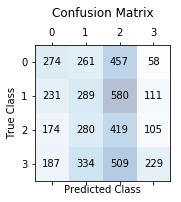


CV Accuracy: 31.590 +/- 1.550
Scores: [31.98 28.68 31.63 32.41 33.22]


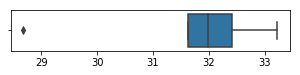


CV CohenKappa: 0.138 +/- 0.036
Scores: [0.12  0.117 0.097 0.161 0.197]


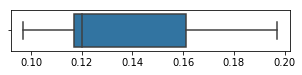

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,SVM-L 1 (defaults),26.92,0.1188,26.1,23.86,42.84,18.19,"[31.64, 24.83, 21.32, 45.53]","[274, 289, 419, 229]","[592, 875, 1546, 274]","[776, 922, 559, 1030]","{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 114, 'tol': 0.0001, 'verbose': 0}","{'Accuracy': (31.59, 1.55), 'CohenKappa': (0.138, 0.036)}"


In [5]:
from sklearn.svm import LinearSVC

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_svml1 = LinearSVC(random_state=RANDOM_SEED, loss='hinge')

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_svml1
model_label        = 'SVM-L 1 (defaults)'
model_results_list = model_results_svml

svml_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
svml_results_df

#### Plot the Weight of the Coefficients by Class

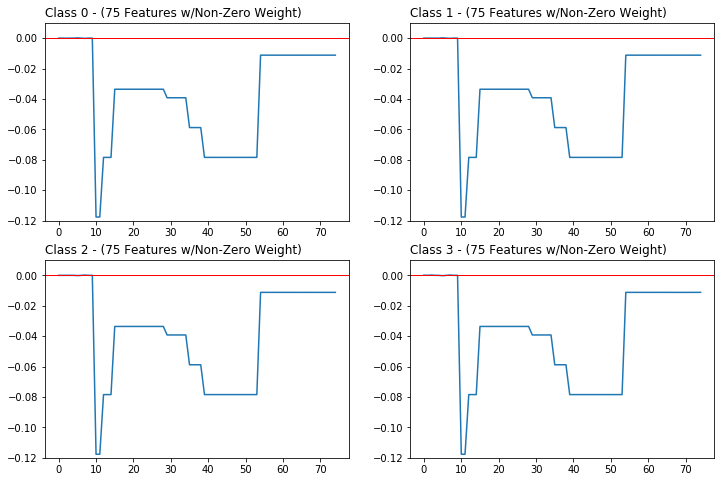

In [6]:
clfmulti_plot_coefficients(model.coef_, y_limits=(-0.12,0.01))

#### Quick Thoughts on Results
- **Awful results!** Accuracy 27%, Cohen Kappa just 0.119 approaching random chance.
- However, this model is the strongest on Class 2 (2-3 months), where all the other models have struggled.
- The coefficient weights are small (range from -0.12 to 0.01).  The actual weights very a tiny bit for each class but the general shape (as plotted above) are nearly identical. 

<a id="model_svml2"></a>
## SVM Linear 2 - Squared Hinge Loss Function
[Back to SVM Linear](#model_svm_linear)

Let's try the default value for the loss function ('squared_hinge') versus 'hinge' that I used to match SVC.


Accuracy      : 39.46
Cohen's Kappa : 0.2795

Classification Report
              precision    recall  f1-score   support

           0       0.38      0.38      0.38      1050
           1       0.34      0.29      0.31      1211
           2       0.41      0.19      0.26       978
           3       0.43      0.67      0.53      1259

   micro avg       0.39      0.39      0.39      4498
   macro avg       0.39      0.38      0.37      4498
weighted avg       0.39      0.39      0.38      4498



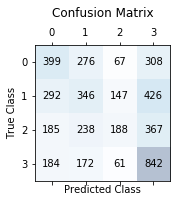


CV Accuracy: 38.930 +/- 1.500
Scores: [39.27 39.49 41.11 36.56 38.23]


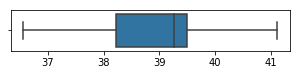


CV CohenKappa: 0.266 +/- 0.021
Scores: [0.249 0.293 0.29  0.243 0.256]


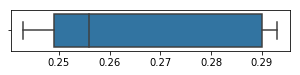

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,SVM-L 1 (defaults),26.92,0.1188,26.1,23.86,42.84,18.19,"[31.64, 24.83, 21.32, 45.53]","[274, 289, 419, 229]","[592, 875, 1546, 274]","[776, 922, 559, 1030]","{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 114, 'tol': 0.0001, 'verbose': 0}","{'Accuracy': (31.59, 1.55), 'CohenKappa': (0.138, 0.036)}"
1,SVM-L 2 (sq_hinge loss fn),39.46,0.2795,38.0,28.57,19.22,66.88,"[37.64, 33.53, 40.6, 43.34]","[399, 346, 188, 842]","[661, 686, 275, 1101]","[651, 865, 790, 417]","{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 114, 'tol': 0.0001, 'verbose': 0}","{'Accuracy': (38.93, 1.5), 'CohenKappa': (0.266, 0.021)}"


In [7]:
#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_svml2 = LinearSVC(random_state=RANDOM_SEED, loss='squared_hinge')

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_svml2
model_label        = 'SVM-L 2 (sq_hinge loss fn)'
model_results_list = model_results_svml

svml_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
svml_results_df

#### Plot the Weight of the Coefficients by Class

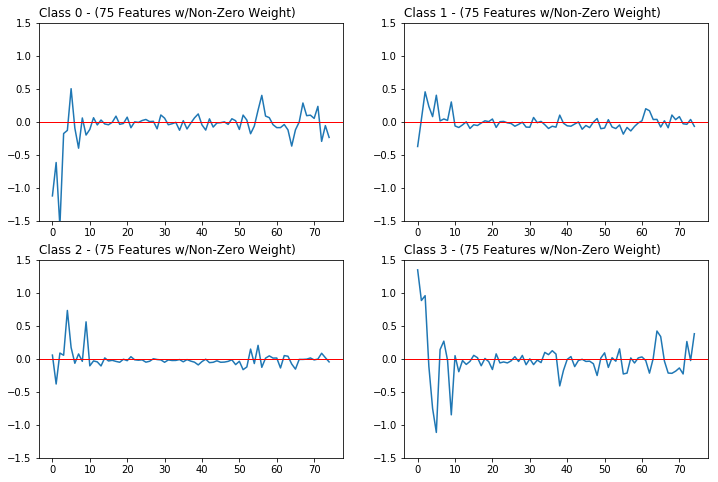

In [8]:
clfmulti_plot_coefficients(model.coef_, y_limits=(-1.5,1.5))

#### Quick Thoughts on Results
- **A change in the loss function makes a big difference!**  These results are more typical of what I am able to achieve with the other models.
- The weights of the coefficients have a wider range (-1.5, 1.5).  And the weights vary a lot more across the classes.  The plots are more of what I would expect than nearly identical plots with SVM Linear 2 above.

<a id="model_svml3"></a>
## SVM Linear 3 - Grid Search on C
[Back to SVM Linear](#model_svm_linear)

Let's try tuning the C parameter to adjust the misclassification penalty. Large values of C correspond to a large error penalty and smaller values of C mean we are less strict about misclassification errors.

I will try range [0.01, 0.1, 0.5, 1.25, 1.5, 2, 2.5].  (Model 2 provides info about C=1.0)

In [9]:
#------------------------------------------------------------
# create classifier
#------------------------------------------------------------
clf_svml3 = LinearSVC(random_state=RANDOM_SEED, loss='squared_hinge')
model = clf_svml3

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 5-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------
param_grid  = {'C':[0.01, 0.1, 0.5, 1.25, 1.5, 2, 2.5]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=5)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'C': 1.5}

LinearSVC(C=1.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=114, tol=0.0001,
     verbose=0)


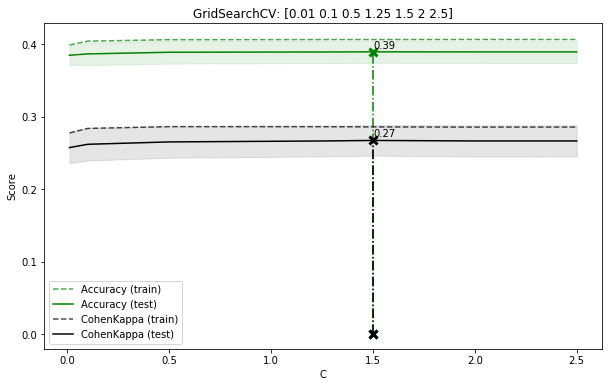

Params     : [0.01 0.1 0.5 1.25 1.5 2 2.5]

Test Results
Accuracy   : [38.51 38.69 38.92 38.96 38.98 38.97 38.97]
CohenKappa : [0.258 0.262 0.265 0.267 0.267 0.267 0.267]
Rank       : [7 6 5 4 1 3 2]

Train Results
Accuracy   : [39.93 40.45 40.66 40.67 40.68 40.69 40.69]
CohenKappa : [0.278 0.284 0.286 0.286 0.286 0.286 0.286]


In [10]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
param_name = 'C'
plt.figure(figsize=(10,6))
plot_grid_search_results(grid_search_results=gs.cv_results_, 
                         param_name=param_name, 
                         plot_dataset='Both')

#print('Params: ', gs.cv_results_['params'])
print('Params     :', gs.cv_results_['param_'+param_name].data)
print('\nTest Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_test_CohenKappa'], 3))
print('Rank       :', gs.cv_results_['rank_test_CohenKappa'])

print('\nTrain Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_train_CohenKappa'], 3))


Accuracy      : 39.44
Cohen's Kappa : 0.2788

Classification Report
              precision    recall  f1-score   support

           0       0.38      0.38      0.38      1050
           1       0.33      0.28      0.31      1211
           2       0.41      0.19      0.26       978
           3       0.43      0.67      0.53      1259

   micro avg       0.39      0.39      0.39      4498
   macro avg       0.39      0.38      0.37      4498
weighted avg       0.39      0.39      0.38      4498



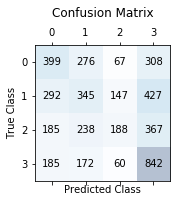


CV Accuracy: 38.980 +/- 1.510
Scores: [39.22 39.49 41.21 36.56 38.42]


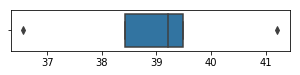


CV CohenKappa: 0.267 +/- 0.021
Scores: [0.249 0.293 0.292 0.245 0.258]


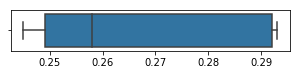

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,SVM-L 1 (defaults),26.92,0.1188,26.1,23.86,42.84,18.19,"[31.64, 24.83, 21.32, 45.53]","[274, 289, 419, 229]","[592, 875, 1546, 274]","[776, 922, 559, 1030]","{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 114, 'tol': 0.0001, 'verbose': 0}","{'Accuracy': (31.59, 1.55), 'CohenKappa': (0.138, 0.036)}"
1,SVM-L 2 (sq_hinge loss fn),39.46,0.2795,38.0,28.57,19.22,66.88,"[37.64, 33.53, 40.6, 43.34]","[399, 346, 188, 842]","[661, 686, 275, 1101]","[651, 865, 790, 417]","{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 114, 'tol': 0.0001, 'verbose': 0}","{'Accuracy': (38.93, 1.5), 'CohenKappa': (0.266, 0.021)}"
2,"SVM-L 3 (sq_hinge, C=1.5)",39.44,0.2788,38.0,28.49,19.22,66.88,"[37.61, 33.46, 40.69, 43.31]","[399, 345, 188, 842]","[662, 686, 274, 1102]","[651, 866, 790, 417]","{'C': 1.5, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 114, 'tol': 0.0001, 'verbose': 0}","{'Accuracy': (38.98, 1.51), 'CohenKappa': (0.267, 0.021)}"


In [11]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
clf_svml3 = LinearSVC(random_state=RANDOM_SEED, loss='squared_hinge', C=1.5)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_svml3
model_label        = 'SVM-L 3 (sq_hinge, C=1.5)'
model_results_list = model_results_svml

svml_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
svml_results_df

#### Plot the Weight of the Coefficients by Class

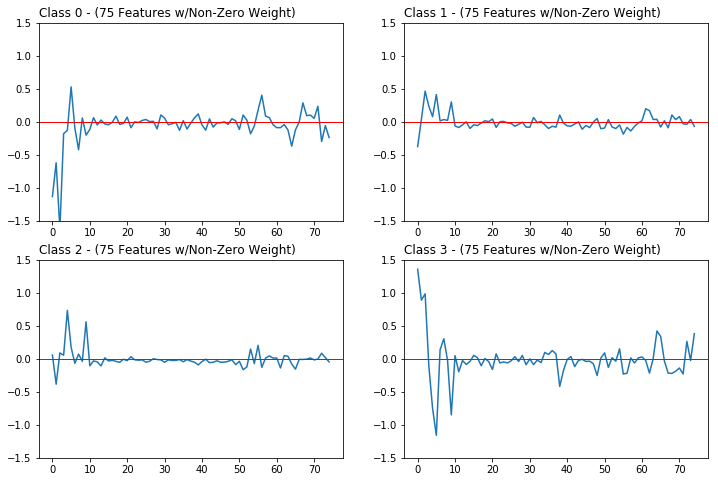

In [12]:
clfmulti_plot_coefficients(model.coef_, y_limits=(-1.5,1.5))

#### Quick Thoughts on Results
- Increasing the misclassification penalty did not make much difference.  The results are nearly identical and the plots of coefficient weights are not noticeably different.
- When I tried larger penalties (5) the model did not converge.  So I'm not sure larger penalties are applicable here.  But maybe I need would need to adjust the default max_iter to greater than 1000.

In [20]:
svml_results_df.to_csv('results_svml.csv', index=False)

## Thoughts on SVM Linear

I tried the LinearSVC class instead of SVC.  It was more efficient in training models.  Setting the loss function to 'hinge' to match the SVC implement produced the worst results so far.  I then shifted back to the default loss function for LinearSVC (squared_hinge) which produced more typical results.  But nothing special.  A SVM-Linear approach was better than KNN, but worst than the tree/forest methods.

<a id="model_svm_rbf"></a>
# Support Vector Machine - RBF
[Table of Contents](#TOC)

Models/Tunings:
- [Default Values](#model_svmr1)
- [Grid Search on C & Gamma](#model_svmr2)

*Links to Documentation*
- [Support Vector Machines](https://scikit-learn.org/0.20/modules/svm.html)
- [SVC](https://scikit-learn.org/0.20/modules/generated/sklearn.svm.SVC.html)

In [10]:
model_results_svmr = []

<a id="model_svmr1"></a>
## SVM RBF 1 - Default Values
[Back to SVM RBF](#model_svm_rbf)

Use Radial Basis Function (RBF) kernel on SVC and use default values for remaining parameters.

I also set gamma='scale' which is the default value in v0.22.

*Current default is ‘auto’ which uses 1 / n_features, if gamma='scale' is passed then it uses 1 / (n_features * X.var()) as value of gamma. The current default of gamma, ‘auto’, will change to ‘scale’ in version 0.22.*

- gamma='auto' = 0.013
- gamma='scale' = 0.095

In [8]:
print("gamma='auto'  :", np.round(1 / (features_test.shape[1]),3))
print("gamma='scale' :", np.round(1 / (features_test.shape[1] * features_test.var()),3))

gamma='auto'  : 0.013
gamma='scale' : 0.095



Accuracy      : 38.37
Cohen's Kappa : 0.2788

Classification Report
              precision    recall  f1-score   support

           0       0.37      0.41      0.39      1050
           1       0.32      0.44      0.37      1211
           2       0.43      0.10      0.17       978
           3       0.46      0.53      0.49      1259

   micro avg       0.38      0.38      0.38      4498
   macro avg       0.39      0.37      0.35      4498
weighted avg       0.39      0.38      0.36      4498



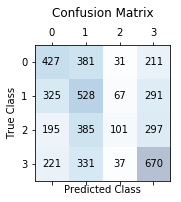


CV Accuracy: 37.280 +/- 0.870
Scores: [36.6  37.64 38.83 36.84 36.51]


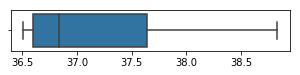


CV CohenKappa: 0.260 +/- 0.020
Scores: [0.228 0.272 0.289 0.256 0.255]


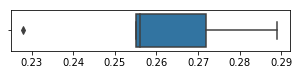

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,SVM-R 1 (defaults),38.37,0.2788,40.67,43.6,10.33,53.22,"[36.56, 32.49, 42.8, 45.61]","[427, 528, 101, 670]","[741, 1097, 135, 799]","[623, 683, 877, 589]","{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 114, 'shrinking': True, 'tol': 0.001, 'verbo...","{'Accuracy': (37.28, 0.87), 'CohenKappa': (0.26, 0.02)}"


In [11]:
from sklearn.svm import SVC

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_svmr1 = SVC(random_state=RANDOM_SEED, kernel='rbf', gamma='scale')

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_svmr1
model_label        = 'SVM-R 1 (defaults)'
model_results_list = model_results_svmr

svmr_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
svmr_results_df

#### Quick Thoughts on Results
- On par with the best results of SVM-Linear, but not great.

<a id="model_svmr2"></a>
## SVM RBF 2 - Grid Search on C & Gamma
[Back to SVM RBF](#model_svm_rbf)

Now let's tune the C & gamma parameters.

*The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.*

I think I want a low C.  It seems unlikely we are not going to get every training example correct with this dataset.  Perhaps a larger gamma may be useful.  I got better results with larger number of neigbors in KNN, or larger numbers of trees in RandomForest/Extra Trees.

In [14]:
#------------------------------------------------------------
# create classifier
#------------------------------------------------------------
clf_svmr2 = SVC(random_state=RANDOM_SEED, kernel='rbf', gamma='scale')
model = clf_svmr2

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 3-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------
param_grid  = {'C'    :[0.001, 0.01, 0.1, 1],           # default       => 1
               'gamma':['auto', 'scale', 1, 1.50, 2]}   # 'scale' value => ~ 0.095

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=3)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'C': 1, 'gamma': 'scale'}

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=114, shrinking=True,
  tol=0.001, verbose=False)


In [23]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
pd.DataFrame({'Params'     : gs.cv_results_['params'],
              'CohenKappa' : np.round(gs.cv_results_['mean_test_CohenKappa'], 3),
              'Accuracy'   : np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2),
              'Rank'       : gs.cv_results_['rank_test_CohenKappa']})

,Params,CohenKappa,Accuracy,Rank
0,"{'C': 0.001, 'gamma': 'auto'}",0.000,27.99,11
1,"{'C': 0.001, 'gamma': 'scale'}",0.000,27.99,11
2,"{'C': 0.001, 'gamma': 1}",0.000,27.99,11
3,"{'C': 0.001, 'gamma': 1.5}",0.000,27.99,11
4,"{'C': 0.001, 'gamma': 2}",0.000,27.99,11
5,"{'C': 0.01, 'gamma': 'auto'}",0.000,27.99,11
6,"{'C': 0.01, 'gamma': 'scale'}",0.000,27.99,10
7,"{'C': 0.01, 'gamma': 1}",0.000,27.99,11
8,"{'C': 0.01, 'gamma': 1.5}",0.000,27.99,11
9,"{'C': 0.01, 'gamma': 2}",0.000,27.99,11


#### Quick Thoughts on Results
- The best parameters found by the Grid Search are the parameter values I used in the first model C=1.0 and gamma='scale'

In [24]:
svmr_results_df.to_csv('results_svmr.csv', index=False)

## Thoughts on SVM RBF

The RBF kernel does not help on this problem.  The results are on par with the best SVM Linear model.  Tuning C and gamma results in the default values.  So SVM RBF is a bust.

<a id="model_sgd"></a>
# Stochastic Gradient Descent
[Table of Contents](#TOC)

Models/Tunings:

- [Default Values](#model_sgd1)
- [Squared Hinge Loss Function](#model_sgd2)
- [Grid Search on alpha for L2 penalty](#model_sgd3)
- [Grid Search on alpha for L1 penalty](#model_sgd4)

*Links to Documentation*
- [Stochastic Gradient Descent](https://scikit-learn.org/0.20/modules/sgd.html)
- [SGDClassifier](https://scikit-learn.org/0.20/modules/generated/sklearn.linear_model.SGDClassifier.html)

In [4]:
model_results_sgd = []

<a id="model_sgd1"></a>
## SGD 1 - Default Values
[Back to SGD](#model_sgd)

Again, let's start with the default values.  To suppress warnings, I set values for max_iter & tolerance (tol) which will change behavior in v0.19

The notable default values include:
- loss='hinge' (soft-margin linearSVM)
- penalty='l2'
- alpha=0.0001
- max_iter=1000 & tol=1e-3
- learning_rate='optimal'

In [5]:
# FYI: Tips on values from documentation

# # Range for regularization alpha
# 10.0**-np.arange(1,7)
# # array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])

# # max_iter
# np.ceil(10**6 / features_train.shape[0])
# # 96.0


Accuracy      : 34.70
Cohen's Kappa : 0.2263

Classification Report
              precision    recall  f1-score   support

           0       0.31      0.52      0.39      1050
           1       0.29      0.16      0.21      1211
           2       0.30      0.28      0.29       978
           3       0.48      0.43      0.45      1259

   micro avg       0.35      0.35      0.35      4498
   macro avg       0.34      0.35      0.34      4498
weighted avg       0.35      0.35      0.34      4498



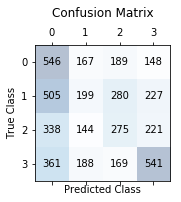


CV Accuracy: 35.860 +/- 1.180
Scores: [34.6  36.68 35.54 37.7  34.75]


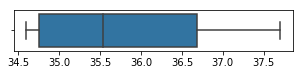


CV CohenKappa: 0.213 +/- 0.022
Scores: [0.202 0.22  0.196 0.253 0.197]


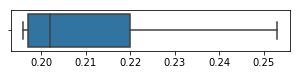

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,SGD 1 (defaults),34.7,0.2263,52.0,16.43,28.12,42.97,"[31.2, 28.51, 30.12, 47.58]","[546, 199, 275, 541]","[1204, 499, 638, 596]","[504, 1012, 703, 718]","{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter': None, 'n_iter_no_cha...","{'Accuracy': (35.86, 1.18), 'CohenKappa': (0.213, 0.022)}"


In [6]:
from sklearn.linear_model import SGDClassifier

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_sgd1 = SGDClassifier(random_state=RANDOM_SEED, 
                         loss='hinge', 
                         max_iter=1000, tol=1e-3)


#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_sgd1
model_label        = 'SGD 1 (defaults)'
model_results_list = model_results_sgd

sgd_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
sgd_results_df

#### Plot the Weight of the Coefficients by Class

Iterations to reach stopping criterion:  78


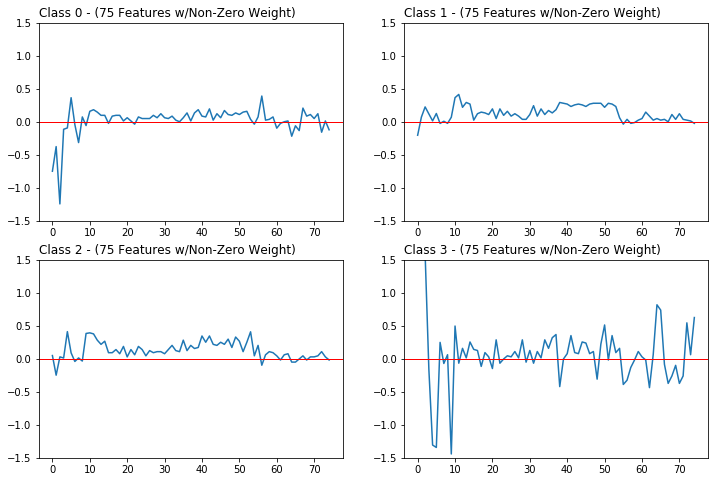

In [7]:
print("Iterations to reach stopping criterion: ", model.n_iter_)

clfmulti_plot_coefficients(model.coef_, y_limits=(-1.5,1.5))

#### Quick Thoughts on Results
- **Poor results.** Accuracy 35% and CohenKappa just 0.23.  *(Reminder: The best so far (Forest 1) has CohenKappa=0.37 and Accuracy 43.5%).*
- This model does well on Class 0 (adopted in 1st week) - TPR 52%, although PPV low at 31.2%.  The best across the other models is a TPR 42%.
- There is some variation in the weights of the coefficients.  Adjusting regularization may be useful.

<a id="model_sgd2"></a>
## SGD 2 - Squared Hinge Loss Function
[Back to SGD](#model_sgd)

Let's try the 'squared_hinge' loss function.  I got better results with squared hinge for LinearSVC (Model SVM-L 2)

The notable default values include:
- penalty='l2'
- alpha=0.0001
- max_iter=1000 & tol=1e-3
- learning_rate='optimal'


Accuracy      : 32.35
Cohen's Kappa : 0.1501

Classification Report
              precision    recall  f1-score   support

           0       0.30      0.27      0.28      1050
           1       0.30      0.60      0.40      1211
           2       0.30      0.14      0.19       978
           3       0.49      0.25      0.33      1259

   micro avg       0.32      0.32      0.32      4498
   macro avg       0.34      0.31      0.30      4498
weighted avg       0.35      0.32      0.31      4498



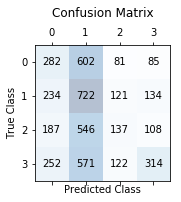


CV Accuracy: 32.500 +/- 1.790
Scores: [33.03 30.49 30.82 35.46 32.7 ]


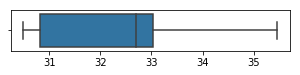


CV CohenKappa: 0.181 +/- 0.029
Scores: [0.171 0.152 0.153 0.223 0.207]


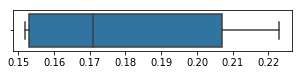

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,SGD 1 (defaults),34.70,0.2263,52.00,16.43,28.12,42.97,"[31.2, 28.51, 30.12, 47.58]","[546, 199, 275, 541]","[1204, 499, 638, 596]","[504, 1012, 703, 718]","{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter': None, 'n_iter_no_cha...","{'Accuracy': (35.86, 1.18), 'CohenKappa': (0.213, 0.022)}"
1,SGD 2 (sq_hinge),32.35,0.1501,26.86,59.62,14.01,24.94,"[29.53, 29.58, 29.72, 48.99]","[282, 722, 137, 314]","[673, 1719, 324, 327]","[768, 489, 841, 945]","{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'max_iter': 1000, 'n_iter': None, 'n_ite...","{'Accuracy': (32.5, 1.79), 'CohenKappa': (0.181, 0.029)}"


In [8]:
#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_sgd2 = SGDClassifier(random_state=RANDOM_SEED, 
                         loss='squared_hinge', 
                         max_iter=1000, tol=1e-3)


#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_sgd2
model_label        = 'SGD 2 (sq_hinge)'
model_results_list = model_results_sgd

sgd_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
sgd_results_df

#### Quick Thoughts on Results
- The squared hinge loss function is **awful** in the SGD implementation - CohenKappa just 0.15.  Squared hinge on LinearSVC had a CohenKappa of 0.28.  *I wonder what accounts for the difference.*

<a id="model_sgd3"></a>
## SGD 3 - Grid Search on alpha for L2 penalty
[Back to SGD](#model_sgd)

Since the magnitude of the coefficients do vary, so let's tune the alpha (penalty) and see if shrinking/regularizing the coefficients improves performance

*Tips from the documentation indicated a good range for regularization alpha is 10.0**-np.arange(1,7)*

In [9]:
#------------------------------------------------------------
# create classifier
#------------------------------------------------------------
clf_sgd3 = SGDClassifier(random_state=RANDOM_SEED, 
                         loss='hinge', 
                         max_iter=1000, tol=1e-3)
model = clf_sgd3

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 5-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------

param_grid  = {'alpha':[0.0000001, 0.000001, 0.00001, 
                        0.0001,
                        0.001, 0.01, 0.1]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=5)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'alpha': 0.01}

SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=114, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)


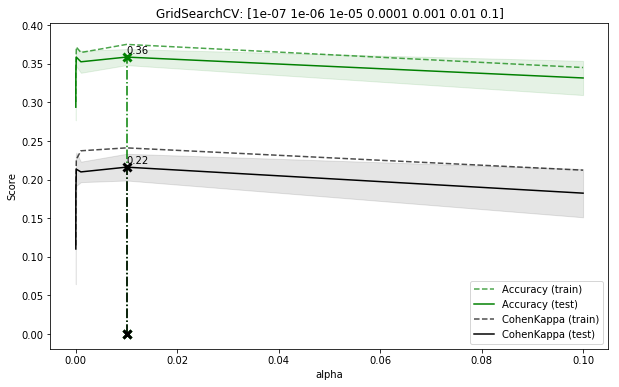

Params     : [1e-07 1e-06 1e-05 0.0001 0.001 0.01 0.1]

Test Results
Accuracy   : [29.38 30.43 33.77 35.86 35.25 35.86 33.16]
CohenKappa : [0.11  0.139 0.185 0.213 0.21  0.216 0.182]
Rank       : [7 6 4 2 3 1 5]

Train Results
Accuracy   : [30.04 31.11 34.31 37.17 36.46 37.51 34.51]
CohenKappa : [0.115 0.136 0.189 0.226 0.237 0.241 0.212]


In [10]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
param_name = 'alpha'
plt.figure(figsize=(10,6))
plot_grid_search_results(grid_search_results=gs.cv_results_, 
                         param_name=param_name, 
                         plot_dataset='Both')

#print('Params: ', gs.cv_results_['params'])
print('Params     :', gs.cv_results_['param_'+param_name].data)
print('\nTest Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_test_CohenKappa'], 3))
print('Rank       :', gs.cv_results_['rank_test_CohenKappa'])

print('\nTrain Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_train_CohenKappa'], 3))

# pd.DataFrame({'Params'     : gs.cv_results_['params'],
#               'CohenKappa' : np.round(gs.cv_results_['mean_test_CohenKappa'], 3),
#               'Accuracy'   : np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2),
#               'Rank'       : gs.cv_results_['rank_test_CohenKappa']})


Accuracy      : 36.82
Cohen's Kappa : 0.2660

Classification Report
              precision    recall  f1-score   support

           0       0.41      0.14      0.21      1050
           1       0.30      0.66      0.42      1211
           2       0.38      0.10      0.15       978
           3       0.49      0.48      0.48      1259

   micro avg       0.37      0.37      0.37      4498
   macro avg       0.40      0.35      0.32      4498
weighted avg       0.40      0.37      0.33      4498



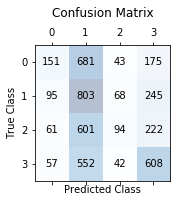


CV Accuracy: 35.860 +/- 1.040
Scores: [34.36 36.21 37.45 36.13 35.18]


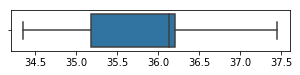


CV CohenKappa: 0.216 +/- 0.017
Scores: [0.207 0.193 0.238 0.208 0.235]


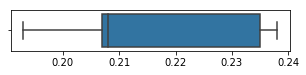

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,SGD 1 (defaults),34.70,0.2263,52.00,16.43,28.12,42.97,"[31.2, 28.51, 30.12, 47.58]","[546, 199, 275, 541]","[1204, 499, 638, 596]","[504, 1012, 703, 718]","{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter': None, 'n_iter_no_cha...","{'Accuracy': (35.86, 1.18), 'CohenKappa': (0.213, 0.022)}"
1,SGD 2 (sq_hinge),32.35,0.1501,26.86,59.62,14.01,24.94,"[29.53, 29.58, 29.72, 48.99]","[282, 722, 137, 314]","[673, 1719, 324, 327]","[768, 489, 841, 945]","{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'max_iter': 1000, 'n_iter': None, 'n_ite...","{'Accuracy': (32.5, 1.79), 'CohenKappa': (0.181, 0.029)}"
2,"SGD 3 (L2, alpha=0.01)",36.82,0.2660,14.38,66.31,9.61,48.29,"[41.48, 30.45, 38.06, 48.64]","[151, 803, 94, 608]","[213, 1834, 153, 642]","[899, 408, 884, 651]","{'alpha': 0.01, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter': None, 'n_iter_no_chang...","{'Accuracy': (35.86, 1.04), 'CohenKappa': (0.216, 0.017)}"


In [11]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
clf_sgd3 = SGDClassifier(random_state=RANDOM_SEED, 
                         loss='hinge', 
                         alpha=0.01,
                         max_iter=1000, tol=1e-3)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_sgd3
model_label        = 'SGD 3 (L2, alpha=0.01)'
model_results_list = model_results_sgd

sgd_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
sgd_results_df

#### Plot the Weight of the Coefficients by Class

Iterations to reach stopping criterion:  12


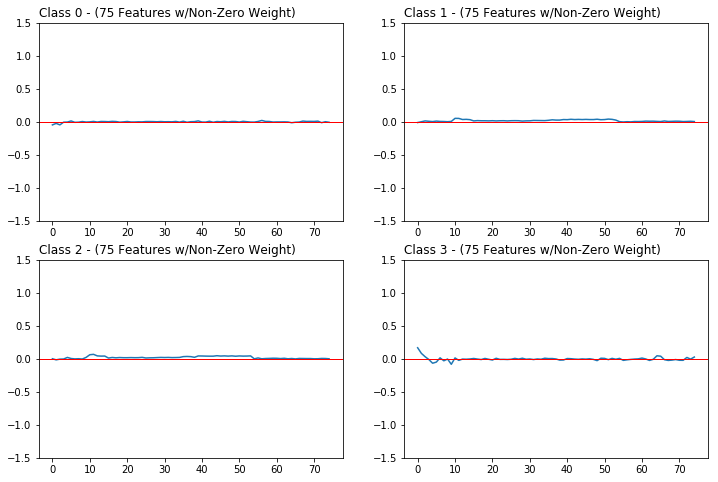

In [12]:
print("Iterations to reach stopping criterion: ", model.n_iter_)

clfmulti_plot_coefficients(model.coef_, y_limits=(-1.5,1.5))

#### Quick Thoughts on Results
- A larger alpha (0.01 versus the default of 0.0001) substantially shrinks the weight of the coefficients.
- Overall performance improves a bit over SGD 1 (Accuracy 36.8% vs. 34.7%, CohenKappa 0.266 vs. 0.226).
- There is a big change in the TPR by class.  Class 1 (1st Month) dramatically improves, Class 0 & 2 are significantly worse.

<a id="model_sgd4"></a>
## SGD 4 - Grid Search on alpha for L1 penalty
[Back to SGD](#model_sgd)

Let's try an L1 penalty and search for the best alpha (penalty value).

*Tips from the documentation indicated a good range for regularization alpha is 10.0**-np.arange(1,7)*

In [13]:
#------------------------------------------------------------
# create classifier
#------------------------------------------------------------
clf_sgd4 = SGDClassifier(random_state=RANDOM_SEED, 
                         loss='hinge', penalty='l1',
                         max_iter=1000, tol=1e-3)
model = clf_sgd4

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 5-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------

param_grid  = {'alpha':[0.0000001, 0.000001, 0.00001, 
                        0.0001,
                        0.001, 0.01, 0.1]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=5)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'alpha': 0.0001}

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=114, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)


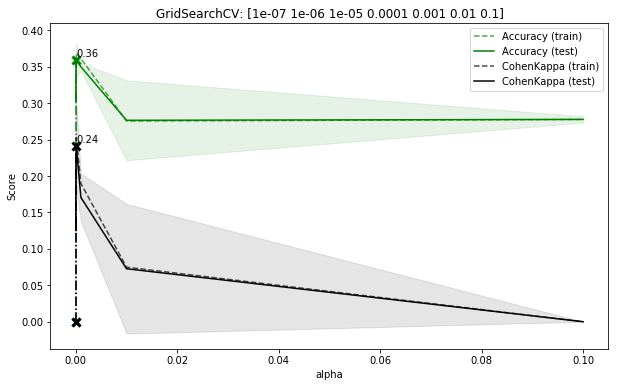

Params     : [1e-07 1e-06 1e-05 0.0001 0.001 0.01 0.1]

Test Results
Accuracy   : [31.23 30.25 32.65 35.99 35.01 27.66 27.78]
CohenKappa : [0.143 0.125 0.187 0.241 0.171 0.073 0.   ]
Rank       : [4 5 2 1 3 6 7]

Train Results
Accuracy   : [31.48 30.94 33.34 36.88 36.15 27.56 27.78]
CohenKappa : [0.143 0.135 0.186 0.253 0.19  0.075 0.   ]


In [14]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
param_name = 'alpha'
plt.figure(figsize=(10,6))
plot_grid_search_results(grid_search_results=gs.cv_results_, 
                         param_name=param_name, 
                         plot_dataset='Both')

#print('Params: ', gs.cv_results_['params'])
print('Params     :', gs.cv_results_['param_'+param_name].data)
print('\nTest Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_test_CohenKappa'], 3))
print('Rank       :', gs.cv_results_['rank_test_CohenKappa'])

print('\nTrain Results')
print('Accuracy   :', np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2))
print('CohenKappa :', np.round(gs.cv_results_['mean_train_CohenKappa'], 3))

# pd.DataFrame({'Params'     : gs.cv_results_['params'],
#               'CohenKappa' : np.round(gs.cv_results_['mean_test_CohenKappa'], 3),
#               'Accuracy'   : np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2),
#               'Rank'       : gs.cv_results_['rank_test_CohenKappa']})


Accuracy      : 38.91
Cohen's Kappa : 0.2835

Classification Report
              precision    recall  f1-score   support

           0       0.37      0.40      0.39      1050
           1       0.31      0.19      0.24      1211
           2       0.35      0.19      0.24       978
           3       0.43      0.73      0.54      1259

   micro avg       0.39      0.39      0.39      4498
   macro avg       0.37      0.38      0.35      4498
weighted avg       0.37      0.39      0.36      4498



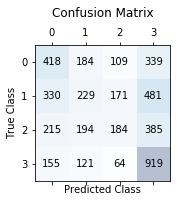


CV Accuracy: 35.990 +/- 2.280
Scores: [31.65 38.11 36.06 37.46 36.65]


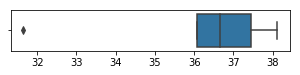


CV CohenKappa: 0.241 +/- 0.060
Scores: [0.136 0.318 0.269 0.237 0.245]


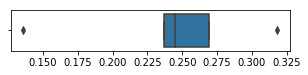

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,SGD 1 (defaults),34.70,0.2263,52.00,16.43,28.12,42.97,"[31.2, 28.51, 30.12, 47.58]","[546, 199, 275, 541]","[1204, 499, 638, 596]","[504, 1012, 703, 718]","{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter': None, 'n_iter_no_cha...","{'Accuracy': (35.86, 1.18), 'CohenKappa': (0.213, 0.022)}"
1,SGD 2 (sq_hinge),32.35,0.1501,26.86,59.62,14.01,24.94,"[29.53, 29.58, 29.72, 48.99]","[282, 722, 137, 314]","[673, 1719, 324, 327]","[768, 489, 841, 945]","{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'max_iter': 1000, 'n_iter': None, 'n_ite...","{'Accuracy': (32.5, 1.79), 'CohenKappa': (0.181, 0.029)}"
2,"SGD 3 (L2, alpha=0.01)",36.82,0.2660,14.38,66.31,9.61,48.29,"[41.48, 30.45, 38.06, 48.64]","[151, 803, 94, 608]","[213, 1834, 153, 642]","[899, 408, 884, 651]","{'alpha': 0.01, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter': None, 'n_iter_no_chang...","{'Accuracy': (35.86, 1.04), 'CohenKappa': (0.216, 0.017)}"
3,"SGD 4 (L1, alpha=0.0001)",38.91,0.2835,39.81,18.91,18.81,72.99,"[37.39, 31.46, 34.85, 43.27]","[418, 229, 184, 919]","[700, 499, 344, 1205]","[632, 982, 794, 340]","{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter': None, 'n_iter_no_cha...","{'Accuracy': (35.99, 2.28), 'CohenKappa': (0.241, 0.06)}"


In [15]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
clf_sgd4 = SGDClassifier(random_state=RANDOM_SEED, 
                         loss='hinge', penalty='l1',
                         alpha=0.0001,
                         max_iter=1000, tol=1e-3)


#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_sgd4
model_label        = 'SGD 4 (L1, alpha=0.0001)'
model_results_list = model_results_sgd

sgd_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
sgd_results_df

#### Quick Thoughts on Results
- Using the default L1 penalty (vs. a larger L2 penalty) improve results a bit.  Accuracy 39% and CohenKappa 0.28 are better scores, but not the best.
- The model achieves the best TPR for Class 3 (4+ months to adopt) - 73% with PPV of 43%.  But poor results on Class 1 & 2 (18-19%).
- In the plots of the coefficient weights below the L2 regularize does eliminate some feature for each class (see note in the title of the sub-plot).  
  - Class 1 & 2 are limited to 15 features, but we have the poor TPR.  Maybe we elminated too many features (penalty too high).
  - Class 0 keeps 28 of the 75 features
  - Class 3 retains the most 44 of 75 features - and has the best TPR.
- There is some variation/outliers in the cross validation.

#### Plot the Weight of the Coefficients by Class

Iterations to reach stopping criterion:  61


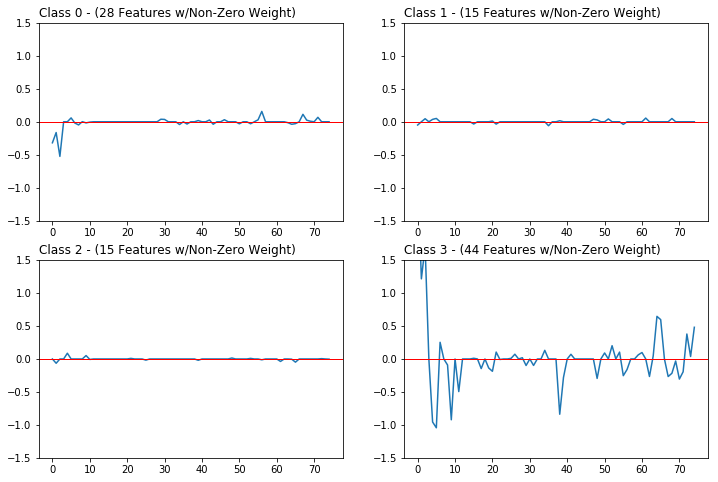

In [16]:
print("Iterations to reach stopping criterion: ", model.n_iter_)
clfmulti_plot_coefficients(model.coef_, y_limits=(-1.5,1.5))

### FYI:  Top 10 Weighted Coefficients by Class

In [29]:
for class_idx in range(model.coef_.shape[0]):
    print('\nClass {}'.format(class_idx))
    coef_df = pd.DataFrame(model.coef_[class_idx], index=feature_labels, columns=['coef'])
    coef_df['abs_coef'] = np.abs(coef_df.coef)
    print(
        coef_df[coef_df.abs_coef!=0] \
            .sort_values(by='abs_coef', ascending=False) \
            .head(10)
    )


Class 0
                             coef  abs_coef
Fee                     -0.525677  0.525677
Age                     -0.319418  0.319418
Quantity                -0.163559  0.163559
PrimaryBreed_Bengal      0.156919  0.156919
PrimaryBreed_Persian     0.113108  0.113108
PrimaryBreed_Siamese     0.067356  0.067356
DescNbrSentences         0.058479  0.058479
DescSentimentMagnitude  -0.048324  0.048324
Color3_Yellow           -0.041790  0.041790
PrimaryBreed_MixedBreed -0.038288  0.038288

Class 1
                                    coef  abs_coef
MaturitySize_L                 -0.060270  0.060270
PrimaryBreed_GermanShepherdDog  0.055875  0.055875
DescNbrSentences                0.050502  0.050502
Age                            -0.049824  0.049824
PrimaryBreed_Poodle             0.049133  0.049133
Fee                             0.046064  0.046064
Health_Healthy                  0.042784  0.042784
PrimaryBreed_Beagle            -0.040155  0.040155
Dewormed_Yes                    0.03814

In [30]:
sgd_results_df.to_csv('results_sgd.csv', index=False)

## Thoughts on Stochastic Gradient Descent

The SGD models are mostly middle of the road in terms of performance.  The SGD 2 model, where I tried the squared_hinge loss function, was a big flop (really low CohenKappa 0.15).  I am not sure why the squared_hinge loss function was a better choice with LinearSVC and dismal with SGD.

Interestingly, each of the good SGD models had stellar results for one particular class.
- Class 0 - SGD 1 (defaults), TPR = 52%, PPV 31%
- Class 1 - SGD 3 (L2, alpha=0.01), TPR = 66%, PPV 30%
- Class 3 - SGD 4 (L1, alpha=0.0001), TPR = 73%, PPV 43%

<a id="model_bagclf"></a>
# Bagging Classifier
[Table of Contents](#TOC)

Models/Tunings:
- [SVM-Linear, Default Values for Bagging](#model_bag1)
- [SVM-Linear, Grid Search on n_estimators, max_samples, max_features](#model_bag2)
- [SGD, Default Values for Bagging](#model_bag3)
- [SGD, Grid Search on n_estimators, max_samples, max_features](#model_bag4)

*Links to Documentation*
- [Bagging Meta-Estimators](https://scikit-learn.org/0.20/modules/ensemble.html#bagging)
- [BaggingClassifier](https://scikit-learn.org/0.20/modules/generated/sklearn.ensemble.BaggingClassifier.html)

In [4]:
model_results_bag = []

<a id="model_bag1"></a>
## Bagging Classifier 1 - SVM L 2
[Back to Bagging Classifier](#model_bagclf)

For the base estimator, I will start with Model SVM-L 2 (LinearSVC using the squared_hinge loss function) which achieved the following results (Accuracy 39%, CohenKappa 0.2795)

Notable Default Values:
- n_estimators = 10
- max_samples = 1.0 (all)
- max_features = 1.0 (all)


Accuracy      : 39.46
Cohen's Kappa : 0.2793

Classification Report
              precision    recall  f1-score   support

           0       0.38      0.38      0.38      1050
           1       0.34      0.29      0.31      1211
           2       0.41      0.19      0.26       978
           3       0.43      0.67      0.53      1259

   micro avg       0.39      0.39      0.39      4498
   macro avg       0.39      0.38      0.37      4498
weighted avg       0.39      0.39      0.38      4498



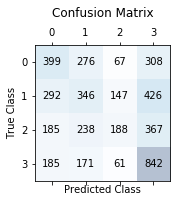


CV Accuracy: 38.930 +/- 1.500
Scores: [39.27 39.49 41.11 36.56 38.23]


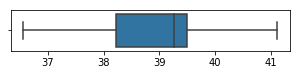


CV CohenKappa: 0.266 +/- 0.021
Scores: [0.249 0.293 0.29  0.243 0.256]


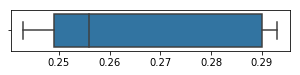

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Bag 1 (SVM-L 2 (sq_hinge)),39.46,0.2793,38.0,28.57,19.22,66.88,"[37.61, 33.56, 40.6, 43.34]","[399, 346, 188, 842]","[662, 685, 275, 1101]","[651, 865, 790, 417]","{'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': True, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__loss': 'squared_hinge', 'base_estimator__max_iter': 100...","{'Accuracy': (38.93, 1.5), 'CohenKappa': (0.266, 0.021)}"


In [6]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier

#------------------------------------------------------------
# create base classifier
#------------------------------------------------------------
base_clf = LinearSVC(random_state=RANDOM_SEED, loss='squared_hinge')

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_bag1 = BaggingClassifier(random_state=RANDOM_SEED, base_estimator=base_clf)


#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_bag1
model_label        = 'Bag 1 (SVM-L 2 (sq_hinge))'
model_results_list = model_results_bag

bag_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
bag_results_df

#### Quick Thoughts on Results
- Bagging 10 classifiers with all data and all features produces results nearly identical to just the single instance of the classifier.

<a id="model_bag2"></a>
## Bagging Classifier 2 - [SVM L 2] Grid Search on n_estimators, max_samples, max_features
[Back to Bagging Classifier](#model_bagclf)

Let's do a grid search on key parameters for the bagging classifier (n_estimators, max_samples, max_features)

In [7]:
#------------------------------------------------------------
# create base classifier
#------------------------------------------------------------
base_clf = LinearSVC(random_state=RANDOM_SEED, loss='squared_hinge')

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_bag2 = BaggingClassifier(random_state=RANDOM_SEED, base_estimator=base_clf)
model    = clf_bag2

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 3-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------
param_grid  = {'n_estimators':[10, 25, 50], 
               'max_samples' :[0.25, 0.33, 0.50, 0.66, 0.75, 1.0],
               'max_features':[0.25, 0.33, 0.50, 0.66, 0.75, 1.0]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=3)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'max_features': 0.75, 'max_samples': 0.25, 'n_estimators': 10}

BaggingClassifier(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=114, tol=0.0001,
     verbose=0),
         bootstrap=True, bootstrap_features=False, max_features=0.75,
         max_samples=0.25, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=114, verbose=0, warm_start=False)


In [18]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
results_df = pd.DataFrame({'Params'     : gs.cv_results_['params'],
              'CohenKappa' : np.round(gs.cv_results_['mean_test_CohenKappa'], 3),
              'Accuracy'   : np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2),
              'Rank'       : gs.cv_results_['rank_test_CohenKappa']})

# results_df[  :18] # max_features 0.25
# results_df[18:36] # max_features 0.33
# results_df[36:54] # max_features 0.50
# results_df[54:72] # max_features 0.66
results_df[72:90] # max_features 0.75
# results_df[90:]   # max_features 1.00

,Params,CohenKappa,Accuracy,Rank
72,"{'max_features': 0.75, 'max_samples': 0.25, 'n_estimators': 10}",0.271,38.54,1
73,"{'max_features': 0.75, 'max_samples': 0.25, 'n_estimators': 25}",0.268,38.70,19
74,"{'max_features': 0.75, 'max_samples': 0.25, 'n_estimators': 50}",0.268,38.75,13
75,"{'max_features': 0.75, 'max_samples': 0.33, 'n_estimators': 10}",0.271,38.54,1
76,"{'max_features': 0.75, 'max_samples': 0.33, 'n_estimators': 25}",0.268,38.70,19
77,"{'max_features': 0.75, 'max_samples': 0.33, 'n_estimators': 50}",0.268,38.75,13
78,"{'max_features': 0.75, 'max_samples': 0.5, 'n_estimators': 10}",0.271,38.54,1
79,"{'max_features': 0.75, 'max_samples': 0.5, 'n_estimators': 25}",0.268,38.70,19
80,"{'max_features': 0.75, 'max_samples': 0.5, 'n_estimators': 50}",0.268,38.75,13
81,"{'max_features': 0.75, 'max_samples': 0.66, 'n_estimators': 10}",0.271,38.54,1


#### Quick Thoughts on Results
- It looks like max_samples is irrelevant - we achieve the same result with each value when max_features=0.75 and n_estimator=10. Therefore I will stay with the default value of max_samples (1.0 rather than 0.25)


Accuracy      : 39.17
Cohen's Kappa : 0.2745

Classification Report
              precision    recall  f1-score   support

           0       0.38      0.39      0.38      1050
           1       0.33      0.33      0.33      1211
           2       0.41      0.16      0.23       978
           3       0.44      0.63      0.51      1259

   micro avg       0.39      0.39      0.39      4498
   macro avg       0.39      0.38      0.37      4498
weighted avg       0.39      0.39      0.37      4498



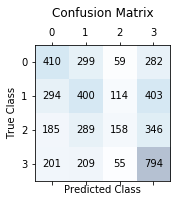


CV Accuracy: 38.400 +/- 1.470
Scores: [38.93 38.3  40.88 36.65 37.23]


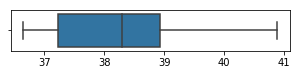


CV CohenKappa: 0.264 +/- 0.021
Scores: [0.248 0.275 0.3   0.24  0.256]


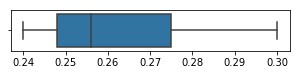

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Bag 1 (SVM-L 2 (sq_hinge)),39.46,0.2793,38.00,28.57,19.22,66.88,"[37.61, 33.56, 40.6, 43.34]","[399, 346, 188, 842]","[662, 685, 275, 1101]","[651, 865, 790, 417]","{'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': True, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__loss': 'squared_hinge', 'base_estimator__max_iter': 100...","{'Accuracy': (38.93, 1.5), 'CohenKappa': (0.266, 0.021)}"
1,"Bag 2 (SVM-L 2 (sq_hinge, max_feature=0.75))",39.17,0.2745,39.05,33.03,16.16,63.07,"[37.61, 33.42, 40.93, 43.51]","[410, 400, 158, 794]","[680, 797, 228, 1031]","[640, 811, 820, 465]","{'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': True, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__loss': 'squared_hinge', 'base_estimator__max_iter': 100...","{'Accuracy': (38.4, 1.47), 'CohenKappa': (0.264, 0.021)}"


In [25]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
#------------------------------------------------------------
# create base classifier
#------------------------------------------------------------
base_clf = LinearSVC(random_state=RANDOM_SEED, loss='squared_hinge')

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_bag2 = BaggingClassifier(random_state=RANDOM_SEED, base_estimator=base_clf,
                            n_estimators=10, max_features=0.75, max_samples=1.0)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_bag2
model_label        = 'Bag 2 (SVM-L 2 (sq_hinge, max_feature=0.75))'
model_results_list = model_results_bag

bag_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
bag_results_df

#### Quick Thoughts on Results
- There is hardly any difference in constraining the number of features (to 75%) available for each of the 10 classifiers.  Bagging the Model SVM-L 2 is not achieving any improvement over the individual version of the model (Accuracy 39%, CohenKappa 0.2795).

<a id="model_bag3"></a>
## Bagging Classifier 3 - SGD 4
[Back to Bagging Classifier](#model_bagclf)

For the base estimator, I will use Model SGD 4 (hinge loss function, L1 regularization with alpha=0.00001) which achieved average results (Accuracy 39%, CohenKappa 0.2835)

Notable Default Values:
- n_estimators = 10
- max_samples = 1.0 (all)
- max_features = 1.0 (all)


Accuracy      : 38.91
Cohen's Kappa : 0.2685

Classification Report
              precision    recall  f1-score   support

           0       0.35      0.47      0.40      1050
           1       0.34      0.14      0.20      1211
           2       0.36      0.25      0.29       978
           3       0.44      0.67      0.53      1259

   micro avg       0.39      0.39      0.39      4498
   macro avg       0.37      0.38      0.36      4498
weighted avg       0.37      0.39      0.36      4498



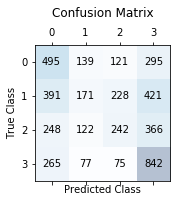


CV Accuracy: 37.690 +/- 0.790
Scores: [37.65 38.97 38.07 37.08 36.7 ]


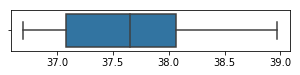


CV CohenKappa: 0.255 +/- 0.024
Scores: [0.22  0.29  0.272 0.24  0.254]


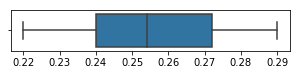

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Bag 1 (SVM-L 2 (sq_hinge)),39.46,0.2793,38.00,28.57,19.22,66.88,"[37.61, 33.56, 40.6, 43.34]","[399, 346, 188, 842]","[662, 685, 275, 1101]","[651, 865, 790, 417]","{'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': True, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__loss': 'squared_hinge', 'base_estimator__max_iter': 100...","{'Accuracy': (38.93, 1.5), 'CohenKappa': (0.266, 0.021)}"
1,"Bag 2 (SVM-L 2 (sq_hinge, max_feature=0.75))",39.17,0.2745,39.05,33.03,16.16,63.07,"[37.61, 33.42, 40.93, 43.51]","[410, 400, 158, 794]","[680, 797, 228, 1031]","[640, 811, 820, 465]","{'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': True, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__loss': 'squared_hinge', 'base_estimator__max_iter': 100...","{'Accuracy': (38.4, 1.47), 'CohenKappa': (0.264, 0.021)}"
2,"Bag 3 (SGD 4 (hinge, L1, alpha=0.0001))",38.91,0.2685,47.14,14.12,24.74,66.88,"[35.38, 33.6, 36.34, 43.76]","[495, 171, 242, 842]","[904, 338, 424, 1082]","[555, 1040, 736, 417]","{'base_estimator__alpha': 0.0001, 'base_estimator__average': False, 'base_estimator__class_weight': None, 'base_estimator__early_stopping': False, 'base_estimator__epsilon': 0.1, 'base_estimator__eta0': 0.0, 'base_estimator__fit_intercept': True,...","{'Accuracy': (37.69, 0.79), 'CohenKappa': (0.255, 0.024)}"


In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble     import BaggingClassifier

#------------------------------------------------------------
# create base classifier
#------------------------------------------------------------
base_clf = SGDClassifier(random_state=RANDOM_SEED, 
                         loss='hinge', penalty='l1',
                         alpha=0.0001,
                         max_iter=1000, tol=1e-3)
#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_bag3 = BaggingClassifier(random_state=RANDOM_SEED, base_estimator=base_clf)


#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_bag3
model_label        = 'Bag 3 (SGD 4 (hinge, L1, alpha=0.0001))'
model_results_list = model_results_bag

bag_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
bag_results_df

#### Quick Thoughts on Results
- Bagging 10 SGD 4 classifiers with all data and all features produces results a little worse than the individual model (Accuracy 38.91% for both, Cohen Kappa 0.2685 vs. 0.2835).
- The TPRs shift among the classes - Classes 0 & 2 improve, Classes 1 & 3 decline a bit.

<a id="model_bag4"></a>
## Bagging Classifier 4 - [SGD 4] Grid Search on n_estimators, max_samples, max_features
[Back to Bagging Classifier](#model_bagclf)

Let's do a grid search on key parameters for the bagging classifier (n_estimators, max_samples, max_features)

In [27]:
#------------------------------------------------------------
# create base classifier
#------------------------------------------------------------
base_clf = SGDClassifier(random_state=RANDOM_SEED, 
                         loss='hinge', penalty='l1',
                         alpha=0.0001,
                         max_iter=1000, tol=1e-3)

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_bag4 = BaggingClassifier(random_state=RANDOM_SEED, base_estimator=base_clf)
model    = clf_bag4

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 3-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------
param_grid  = {'n_estimators':[10, 25, 50], 
               'max_samples' :[0.25, 0.33, 0.50, 0.66, 0.75, 1.0],
               'max_features':[0.25, 0.33, 0.50, 0.66, 0.75, 1.0]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=3)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'max_features': 0.75, 'max_samples': 0.33, 'n_estimators': 50}

BaggingClassifier(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=114, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.75,
         max_samples=0.33, n_estimators=50, n_jobs=None, oob_score=False,
         random_state=114, verbose=0, warm_start=False)


In [34]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
results_df = pd.DataFrame({'Params'     : gs.cv_results_['params'],
              'CohenKappa' : np.round(gs.cv_results_['mean_test_CohenKappa'], 3),
              'Accuracy'   : np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2),
              'Rank'       : gs.cv_results_['rank_test_CohenKappa']})

# results_df[  :18] # max_features 0.25
# results_df[18:36] # max_features 0.33
# results_df[36:54] # max_features 0.50
# results_df[54:72] # max_features 0.66
results_df[72:90] # max_features 0.75
# results_df[90:]   # max_features 1.00

,Params,CohenKappa,Accuracy,Rank
72,"{'max_features': 0.75, 'max_samples': 0.25, 'n_estimators': 10}",0.247,37.93,45
73,"{'max_features': 0.75, 'max_samples': 0.25, 'n_estimators': 25}",0.255,38.38,28
74,"{'max_features': 0.75, 'max_samples': 0.25, 'n_estimators': 50}",0.261,38.88,12
75,"{'max_features': 0.75, 'max_samples': 0.33, 'n_estimators': 10}",0.260,37.57,14
76,"{'max_features': 0.75, 'max_samples': 0.33, 'n_estimators': 25}",0.260,38.19,15
77,"{'max_features': 0.75, 'max_samples': 0.33, 'n_estimators': 50}",0.269,39.11,1
78,"{'max_features': 0.75, 'max_samples': 0.5, 'n_estimators': 10}",0.240,37.21,63
79,"{'max_features': 0.75, 'max_samples': 0.5, 'n_estimators': 25}",0.243,37.79,57
80,"{'max_features': 0.75, 'max_samples': 0.5, 'n_estimators': 50}",0.256,38.37,26
81,"{'max_features': 0.75, 'max_samples': 0.66, 'n_estimators': 10}",0.241,36.68,61


#### Quick Thoughts on Results

- The best parameters are for 50 classifiers with each built using 1/3 of the data and 75% of the features.


Accuracy      : 38.77
Cohen's Kappa : 0.2596

Classification Report
              precision    recall  f1-score   support

           0       0.39      0.34      0.36      1050
           1       0.33      0.20      0.25      1211
           2       0.37      0.22      0.27       978
           3       0.41      0.74      0.53      1259

   micro avg       0.39      0.39      0.39      4498
   macro avg       0.37      0.37      0.35      4498
weighted avg       0.37      0.39      0.36      4498



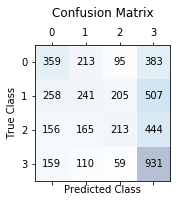


CV Accuracy: 38.020 +/- 0.680
Scores: [37.98 38.73 38.59 36.8  37.99]


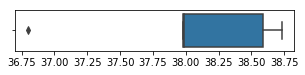


CV CohenKappa: 0.253 +/- 0.019
Scores: [0.226 0.276 0.26  0.236 0.268]


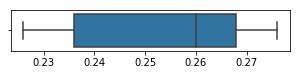

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Bag 1 (SVM-L 2 (sq_hinge)),39.46,0.2793,38.00,28.57,19.22,66.88,"[37.61, 33.56, 40.6, 43.34]","[399, 346, 188, 842]","[662, 685, 275, 1101]","[651, 865, 790, 417]","{'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': True, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__loss': 'squared_hinge', 'base_estimator__max_iter': 100...","{'Accuracy': (38.93, 1.5), 'CohenKappa': (0.266, 0.021)}"
1,"Bag 2 (SVM-L 2 (sq_hinge, max_feature=0.75))",39.17,0.2745,39.05,33.03,16.16,63.07,"[37.61, 33.42, 40.93, 43.51]","[410, 400, 158, 794]","[680, 797, 228, 1031]","[640, 811, 820, 465]","{'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': True, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__loss': 'squared_hinge', 'base_estimator__max_iter': 100...","{'Accuracy': (38.4, 1.47), 'CohenKappa': (0.264, 0.021)}"
2,"Bag 3 (SGD 4 (hinge, L1, alpha=0.0001))",38.91,0.2685,47.14,14.12,24.74,66.88,"[35.38, 33.6, 36.34, 43.76]","[495, 171, 242, 842]","[904, 338, 424, 1082]","[555, 1040, 736, 417]","{'base_estimator__alpha': 0.0001, 'base_estimator__average': False, 'base_estimator__class_weight': None, 'base_estimator__early_stopping': False, 'base_estimator__epsilon': 0.1, 'base_estimator__eta0': 0.0, 'base_estimator__fit_intercept': True,...","{'Accuracy': (37.69, 0.79), 'CohenKappa': (0.255, 0.024)}"
3,"Bag 4 (SGD 4 (hinge, L1, alpha=0.0001), clf=50, feature=75%, sample=33%)",38.77,0.2596,34.19,19.90,21.78,73.95,"[38.52, 33.06, 37.24, 41.1]","[359, 241, 213, 931]","[573, 488, 359, 1334]","[691, 970, 765, 328]","{'base_estimator__alpha': 0.0001, 'base_estimator__average': False, 'base_estimator__class_weight': None, 'base_estimator__early_stopping': False, 'base_estimator__epsilon': 0.1, 'base_estimator__eta0': 0.0, 'base_estimator__fit_intercept': True,...","{'Accuracy': (38.02, 0.68), 'CohenKappa': (0.253, 0.019)}"


In [35]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
#------------------------------------------------------------
# create base classifier
#------------------------------------------------------------
base_clf = SGDClassifier(random_state=RANDOM_SEED, 
                         loss='hinge', penalty='l1',
                         alpha=0.0001,
                         max_iter=1000, tol=1e-3)

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_bag4 = BaggingClassifier(random_state=RANDOM_SEED, base_estimator=base_clf,
                            n_estimators=50, max_samples=0.33, max_features=0.75)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_bag4
model_label        = 'Bag 4 (SGD 4 (hinge, L1, alpha=0.0001), clf=50, feature=75%, sample=33%)'
model_results_list = model_results_bag

bag_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
bag_results_df

#### Quick Thoughts on Results
- The tuned version of the model is not an improvement - where we now use 50 (vs. 10) classifiers and constrain the features (75%) and data (33%) available to build each classifier.
- Bagging the Model SGD 4 is not achieving any improvement over the individual version of the model
  - SGD 4 = Accuracy 38.91%, CohenKappa 0.2795
  - Bagged = Accuracy 38.77%, CohenKappa 0.2596

In [36]:
bag_results_df.to_csv('results_bag.csv', index=False)

## Thoughts on Bagging

There is no advantage in Bagging for this problem.  Bagging multiple classifiers does slightly worse than the models as individual classifiers.

<a id="model_ada"></a>
# AdaBoost
[Table of Contents](#TOC)

Models/Tunings:
- [Decision Tree, Default Values for AdaBoost](#model_ada1)
- [Decision Tree, Grid Search on AdaBoost's Estimators, Learning Rate](#model_ada2)
- [SGD, Default Values for AdaBoost](#model_ada3)
- [SGD, Grid Search on AdaBoost's Estimators, Learning Rate](#model_ada4)

*Links to Documentation*
- [AdaBoost](https://scikit-learn.org/0.20/modules/ensemble.html#adaboost)
- [AdaBoostClassifier](https://scikit-learn.org/0.20/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [4]:
model_results_ada = []

<a id="model_ada1"></a>
## AdaBoost 1 - Decision Tree, Default Values for AdaBoost
[Back to AdaBoost](#model_ada)

For the base estimator, I start with a stub Decision Tree (depth 1) and then accept the default values for AdaBoostClassifier.

The default values for AdaBoost are:
- n_estimators = 50
- learning_rate = 1


Accuracy      : 41.62
Cohen's Kappa : 0.3287

Classification Report
              precision    recall  f1-score   support

           0       0.40      0.39      0.40      1050
           1       0.35      0.36      0.35      1211
           2       0.37      0.22      0.27       978
           3       0.49      0.65      0.56      1259

   micro avg       0.42      0.42      0.42      4498
   macro avg       0.40      0.40      0.40      4498
weighted avg       0.41      0.42      0.40      4498



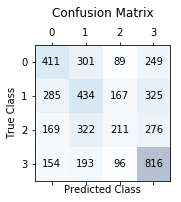


CV Accuracy: 40.580 +/- 0.720
Scores: [41.88 40.3  39.73 40.71 40.28]


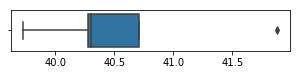


CV CohenKappa: 0.310 +/- 0.013
Scores: [0.304 0.332 0.314 0.294 0.307]


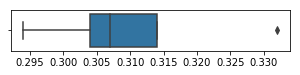

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Ada 1 (DT),41.62,0.3287,39.14,35.84,21.57,64.81,"[40.33, 34.72, 37.48, 48.98]","[411, 434, 211, 816]","[608, 816, 352, 850]","[639, 777, 767, 443]","{'algorithm': 'SAMME.R', 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrea...","{'Accuracy': (40.58, 0.72), 'CohenKappa': (0.31, 0.013)}"


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

#------------------------------------------------------------
# create base classifier
#------------------------------------------------------------
base_clf = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=1)

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_ada1 = AdaBoostClassifier(random_state=RANDOM_SEED, base_estimator=base_clf)


#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_ada1
model_label        = 'Ada 1 (DT)'
model_results_list = model_results_ada

ada_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
ada_results_df

In [6]:
#------------------------------------------------------------
# Explore Model/Decision Tree
#------------------------------------------------------------
model = clf_ada1
print("Estimators : ", len(model.estimators_))

print("\n- - - - Top Features - - - -")
feature_importance_df = pd.DataFrame(model.feature_importances_, 
                                     index=feature_labels, columns=['importance'])
feature_importance_df[feature_importance_df.importance!=0] \
    .sort_values(by='importance', ascending=False) \
    .head(10)

Estimators :  50

- - - - Top Features - - - -


,importance
NbrProfiles,0.24
Age,0.08
PhotoAmt,0.08
DescNbrSentences,0.04
DescSentimentScore,0.04
DescSentimentMagnitude,0.04
PrimaryBreed_Other,0.02
PrimaryBreed_Bengal,0.02
PrimaryBreed_GermanShepherdDog,0.02
PrimaryBreed_GoldenRetriever,0.02


#### Quick Thoughts on Results
- Nice!  AdaBoosted Decision Stumps (depth = 1) performed a little bit better than the best tuned individual Decision Tree (Tree 4 with 150 leaf nodes).  Accuracy 42% vs. 39%, CohenKappa 0.3287 vs 0.3258
- TPR is a little bit better for all but Class 1 (35.8 vs 40.8%).
- Some variation in the CV results.

<a id="model_ada2"></a>
## AdaBoost - DecisionTree, Grid Search on Estimators, Learning Rate
[Back to AdaBoost](#model_ada)

Let's do a grid search on key parameters for AdaBoost Classifier

The default values are:
- n_estimators = 50
- learning_rate = 1 
  - *Learning rate shrinks the contribution of each classifier by learning_rate. There is a trade-off between learning_rate and n_estimators.*

In [7]:
#------------------------------------------------------------
# create base classifier
#------------------------------------------------------------
base_clf = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=1)

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_ada2 = AdaBoostClassifier(random_state=RANDOM_SEED, base_estimator=base_clf)
model    = clf_ada2

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 5-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------
param_grid  = {'n_estimators'  : [25, 50, 75], 
               'learning_rate' : [0.01, 0.05, 0.1, 0.5, 1.0, 1.25, 1.5]}


gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=5)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'learning_rate': 1.0, 'n_estimators': 75}

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=114,
            splitter='best'),
          learning_rate=1.0, n_estimators=75, random_state=114)


In [8]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
results_df = pd.DataFrame({'Params'     : gs.cv_results_['params'],
              'CohenKappa' : np.round(gs.cv_results_['mean_test_CohenKappa'], 3),
              'Accuracy'   : np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2),
              'Rank'       : gs.cv_results_['rank_test_CohenKappa'],
              'CohenKappa_Train' : np.round(gs.cv_results_['mean_train_CohenKappa'], 3),
              'Accuracy_Train'   : np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2) })

results_df

,Params,CohenKappa,Accuracy,Rank,CohenKappa_Train,Accuracy_Train
0,"{'learning_rate': 0.01, 'n_estimators': 25}",0.184,35.83,21,0.184,35.92
1,"{'learning_rate': 0.01, 'n_estimators': 50}",0.199,36.38,20,0.204,36.57
2,"{'learning_rate': 0.01, 'n_estimators': 75}",0.205,36.55,19,0.214,36.86
3,"{'learning_rate': 0.05, 'n_estimators': 25}",0.221,37.06,18,0.224,37.32
4,"{'learning_rate': 0.05, 'n_estimators': 50}",0.233,37.60,17,0.238,37.91
5,"{'learning_rate': 0.05, 'n_estimators': 75}",0.246,38.52,15,0.249,38.75
6,"{'learning_rate': 0.1, 'n_estimators': 25}",0.240,38.01,16,0.241,38.16
7,"{'learning_rate': 0.1, 'n_estimators': 50}",0.258,39.13,14,0.261,39.31
8,"{'learning_rate': 0.1, 'n_estimators': 75}",0.278,39.93,13,0.283,40.23
9,"{'learning_rate': 0.5, 'n_estimators': 25}",0.296,40.30,12,0.300,40.74



Accuracy      : 41.75
Cohen's Kappa : 0.3327

Classification Report
              precision    recall  f1-score   support

           0       0.40      0.39      0.39      1050
           1       0.35      0.36      0.35      1211
           2       0.38      0.22      0.28       978
           3       0.49      0.65      0.56      1259

   micro avg       0.42      0.42      0.42      4498
   macro avg       0.41      0.40      0.40      4498
weighted avg       0.41      0.42      0.40      4498



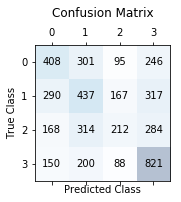


CV Accuracy: 40.960 +/- 0.980
Scores: [42.41 41.5  39.45 40.75 40.71]


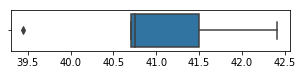


CV CohenKappa: 0.319 +/- 0.018
Scores: [0.325 0.347 0.314 0.292 0.314]


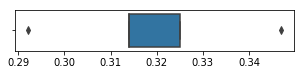

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Ada 1 (DT),41.62,0.3287,39.14,35.84,21.57,64.81,"[40.33, 34.72, 37.48, 48.98]","[411, 434, 211, 816]","[608, 816, 352, 850]","[639, 777, 767, 443]","{'algorithm': 'SAMME.R', 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrea...","{'Accuracy': (40.58, 0.72), 'CohenKappa': (0.31, 0.013)}"
1,"Ada 2 (DT, clf=75)",41.75,0.3327,38.86,36.09,21.68,65.21,"[40.16, 34.9, 37.72, 49.22]","[408, 437, 212, 821]","[608, 815, 350, 847]","[642, 774, 766, 438]","{'algorithm': 'SAMME.R', 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrea...","{'Accuracy': (40.96, 0.98), 'CohenKappa': (0.319, 0.018)}"


In [9]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
#------------------------------------------------------------
# create base classifier
#------------------------------------------------------------
base_clf = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=1)

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_ada2 = AdaBoostClassifier(random_state=RANDOM_SEED, base_estimator=base_clf,
                             learning_rate=1.0, n_estimators=75)
model    = clf_ada2

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_ada2
model_label        = 'Ada 2 (DT, clf=75)'
model_results_list = model_results_ada

ada_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
ada_results_df

In [10]:
#------------------------------------------------------------
# Explore Model/Decision Tree
#------------------------------------------------------------
#model = clf_ada2
print("Estimators : ", len(model.estimators_))

print("\n- - - - Top Features - - - -")
feature_importance_df = pd.DataFrame(model.feature_importances_, 
                                     index=feature_labels, columns=['importance'])
feature_importance_df[feature_importance_df.importance!=0] \
    .sort_values(by='importance', ascending=False) \
    .head(10)

Estimators :  75

- - - - Top Features - - - -


,importance
NbrProfiles,0.173333
Age,0.093333
PhotoAmt,0.066667
Quantity,0.053333
Fee,0.040000
DescNbrSentences,0.040000
DescSentimentScore,0.040000
DescSentimentMagnitude,0.040000
PrimaryBreed_MixedBreed,0.026667
PrimaryBreed_Other,0.013333


#### Quick Thoughts on Results
- The best parameters found by the grid search are 75 classifier with a learning rate of 1.0 (the default value).
- More classifiers (75 vs. default of 50) is a marginal improvement in performance (Accuracy 41.75 vs 41.62% and CohenKappa 0.3327 vs. 0.3287).

<a id="model_ada3"></a>
## AdaBoost 3 - SGD, Default Values for AdaBoost
[Back to AdaBoost](#model_ada)

For the base estimator, I will use the default model for SGD and accept the default values for AdaBoostClassifier.

The default values for AdaBoost are:
- n_estimators = 50
- learning_rate = 1


Accuracy      : 38.46
Cohen's Kappa : 0.2595

Classification Report
              precision    recall  f1-score   support

           0       0.35      0.42      0.38      1050
           1       0.34      0.33      0.33      1211
           2       0.37      0.22      0.27       978
           3       0.45      0.54      0.49      1259

   micro avg       0.38      0.38      0.38      4498
   macro avg       0.38      0.38      0.37      4498
weighted avg       0.38      0.38      0.38      4498



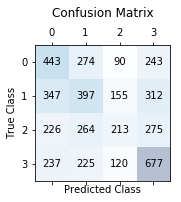


CV Accuracy: 37.330 +/- 0.880
Scores: [37.17 38.49 38.11 36.84 36.03]


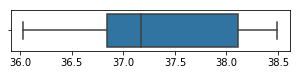


CV CohenKappa: 0.249 +/- 0.026
Scores: [0.203 0.273 0.272 0.25  0.246]


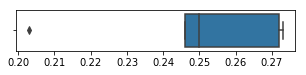

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Ada 1 (DT),41.62,0.3287,39.14,35.84,21.57,64.81,"[40.33, 34.72, 37.48, 48.98]","[411, 434, 211, 816]","[608, 816, 352, 850]","[639, 777, 767, 443]","{'algorithm': 'SAMME.R', 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrea...","{'Accuracy': (40.58, 0.72), 'CohenKappa': (0.31, 0.013)}"
1,"Ada 2 (DT, clf=75)",41.75,0.3327,38.86,36.09,21.68,65.21,"[40.16, 34.9, 37.72, 49.22]","[408, 437, 212, 821]","[608, 815, 350, 847]","[642, 774, 766, 438]","{'algorithm': 'SAMME.R', 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrea...","{'Accuracy': (40.96, 0.98), 'CohenKappa': (0.319, 0.018)}"
2,Ada 3 (SGD),38.46,0.2595,42.19,32.78,21.78,53.77,"[35.36, 34.22, 36.85, 44.92]","[443, 397, 213, 677]","[810, 763, 365, 830]","[607, 814, 765, 582]","{'algorithm': 'SAMME', 'base_estimator__alpha': 0.0001, 'base_estimator__average': False, 'base_estimator__class_weight': None, 'base_estimator__early_stopping': False, 'base_estimator__epsilon': 0.1, 'base_estimator__eta0': 0.0, 'base_estimator_...","{'Accuracy': (37.33, 0.88), 'CohenKappa': (0.249, 0.026)}"


In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier

#------------------------------------------------------------
# create base classifier
#------------------------------------------------------------
base_clf = SGDClassifier(random_state=RANDOM_SEED, 
                         loss='hinge', 
                         max_iter=1000, tol=1e-3)

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_ada3 = AdaBoostClassifier(random_state=RANDOM_SEED, base_estimator=base_clf,
                             algorithm='SAMME')


#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_ada3
model_label        = 'Ada 3 (SGD)'
model_results_list = model_results_ada

ada_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
ada_results_df

### Quick Thoughts on Results

- AdaBoosted SGD performed a little bit better than individual SGD with the default setting.  Accuracy 38% vs. 34.7%, CohenKappa 0.2595 vs. 0.2263
- TPR is mixed - better on Classes 1 & 3 and worse on Classes 0 and 2.
- There's some variation on the Cohen Kappa score in the CV results (0.20 to 0.27)
- AdaBoosting SGD did not produce as strong of results as AdaBoosting the Decision Stumps.  But I have tended to get better results on this dataset with tree-based models.

<a id="model_ada4"></a>
## AdaBoost - SGD, Grid Search on Estimators, Learning Rate
[Back to AdaBoost](#model_ada)

Let's again do a grid search on key parameters for AdaBoost Classifier

The default values are:
- n_estimators = 50
- learning_rate = 1 
  - *Learning rate shrinks the contribution of each classifier by learning_rate. There is a trade-off between learning_rate and n_estimators.*

In [12]:
#------------------------------------------------------------
# create base classifier
#------------------------------------------------------------
base_clf = SGDClassifier(random_state=RANDOM_SEED, 
                         loss='hinge', 
                         max_iter=1000, tol=1e-3)

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_ada4 = AdaBoostClassifier(random_state=RANDOM_SEED, base_estimator=base_clf,
                             algorithm='SAMME')
model    = clf_ada4

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 5-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------
param_grid  = {'n_estimators'  : [25, 50, 75], 
               'learning_rate' : [0.01, 0.05, 0.1, 0.5, 1.0, 1.25, 1.5]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=5)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'learning_rate': 0.5, 'n_estimators': 50}

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=114, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False),
          learning_rate=0.5, n_estimators=50, random_state=114)


In [13]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
results_df = pd.DataFrame({'Params'     : gs.cv_results_['params'],
              'CohenKappa' : np.round(gs.cv_results_['mean_test_CohenKappa'], 3),
              'Accuracy'   : np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2),
              'Rank'       : gs.cv_results_['rank_test_CohenKappa'],
              'CohenKappa_Train' : np.round(gs.cv_results_['mean_train_CohenKappa'], 3),
              'Accuracy_Train'   : np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2) })

results_df

,Params,CohenKappa,Accuracy,Rank,CohenKappa_Train,Accuracy_Train
0,"{'learning_rate': 0.01, 'n_estimators': 25}",0.239,37.35,21,0.246,38.28
1,"{'learning_rate': 0.01, 'n_estimators': 50}",0.244,37.66,14,0.251,38.59
2,"{'learning_rate': 0.01, 'n_estimators': 75}",0.246,37.75,12,0.254,38.82
3,"{'learning_rate': 0.05, 'n_estimators': 25}",0.248,37.98,11,0.259,39.07
4,"{'learning_rate': 0.05, 'n_estimators': 50}",0.251,37.97,7,0.266,39.19
5,"{'learning_rate': 0.05, 'n_estimators': 75}",0.254,38.00,5,0.268,39.28
6,"{'learning_rate': 0.1, 'n_estimators': 25}",0.249,37.92,8,0.265,39.15
7,"{'learning_rate': 0.1, 'n_estimators': 50}",0.252,37.80,6,0.270,39.35
8,"{'learning_rate': 0.1, 'n_estimators': 75}",0.255,37.79,4,0.271,39.33
9,"{'learning_rate': 0.5, 'n_estimators': 25}",0.259,37.71,3,0.265,38.64



Accuracy      : 37.97
Cohen's Kappa : 0.2603

Classification Report
              precision    recall  f1-score   support

           0       0.36      0.39      0.37      1050
           1       0.32      0.36      0.34      1211
           2       0.38      0.20      0.26       978
           3       0.45      0.54      0.49      1259

   micro avg       0.38      0.38      0.38      4498
   macro avg       0.38      0.37      0.36      4498
weighted avg       0.38      0.38      0.37      4498



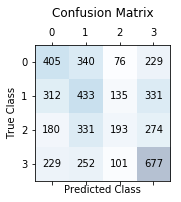


CV Accuracy: 37.650 +/- 0.940
Scores: [37.6  37.88 39.26 36.46 37.04]


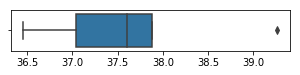


CV CohenKappa: 0.259 +/- 0.022
Scores: [0.224 0.276 0.282 0.245 0.269]


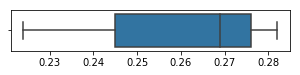

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Ada 1 (DT),41.62,0.3287,39.14,35.84,21.57,64.81,"[40.33, 34.72, 37.48, 48.98]","[411, 434, 211, 816]","[608, 816, 352, 850]","[639, 777, 767, 443]","{'algorithm': 'SAMME.R', 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrea...","{'Accuracy': (40.58, 0.72), 'CohenKappa': (0.31, 0.013)}"
1,"Ada 2 (DT, clf=75)",41.75,0.3327,38.86,36.09,21.68,65.21,"[40.16, 34.9, 37.72, 49.22]","[408, 437, 212, 821]","[608, 815, 350, 847]","[642, 774, 766, 438]","{'algorithm': 'SAMME.R', 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrea...","{'Accuracy': (40.96, 0.98), 'CohenKappa': (0.319, 0.018)}"
2,Ada 3 (SGD),38.46,0.2595,42.19,32.78,21.78,53.77,"[35.36, 34.22, 36.85, 44.92]","[443, 397, 213, 677]","[810, 763, 365, 830]","[607, 814, 765, 582]","{'algorithm': 'SAMME', 'base_estimator__alpha': 0.0001, 'base_estimator__average': False, 'base_estimator__class_weight': None, 'base_estimator__early_stopping': False, 'base_estimator__epsilon': 0.1, 'base_estimator__eta0': 0.0, 'base_estimator_...","{'Accuracy': (37.33, 0.88), 'CohenKappa': (0.249, 0.026)}"
3,"Ada 4 (SGD, learn_rate=0.5)",37.97,0.2603,38.57,35.76,19.73,53.77,"[35.97, 31.93, 38.22, 44.8]","[405, 433, 193, 677]","[721, 923, 312, 834]","[645, 778, 785, 582]","{'algorithm': 'SAMME', 'base_estimator__alpha': 0.0001, 'base_estimator__average': False, 'base_estimator__class_weight': None, 'base_estimator__early_stopping': False, 'base_estimator__epsilon': 0.1, 'base_estimator__eta0': 0.0, 'base_estimator_...","{'Accuracy': (37.65, 0.94), 'CohenKappa': (0.259, 0.022)}"


In [14]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
#------------------------------------------------------------
# create base classifier
#------------------------------------------------------------
base_clf = SGDClassifier(random_state=RANDOM_SEED, 
                         loss='hinge', 
                         max_iter=1000, tol=1e-3)

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_ada4 = AdaBoostClassifier(random_state=RANDOM_SEED, base_estimator=base_clf,
                             algorithm='SAMME',
                             learning_rate=0.5, n_estimators=50)
model    = clf_ada4

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_ada4
model_label        = 'Ada 4 (SGD, learn_rate=0.5)'
model_results_list = model_results_ada

ada_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
ada_results_df

### Quick Thoughts on Results

- The grid search identified a learning rate of 0.5 (smaller than the default of 1.0).  This reduces the amplitude of weights on misclassification at each step. The grid search also retained the default number of classifiers (50).
- The results are marginally different - lower Accuracy, higher CohenKappa.

In [15]:
ada_results_df.to_csv('results_ada.csv', index=False)

## Thoughts on AdaBoost

Boosting is an improvement over the performance of the underlying classifier.  I achieved the better results boosting the Decision Stumps than the SGD algorithm.  Model 2, boosting the Decision Stumps with 75 classifiers, is a little stronger than the best tuned individual tree (CohenKappa 0.3327 vs 0.3258)  But not as good as the best Random Forest model (Forest 1) with CohenKappa of 0.3724.

<a id="model_grad_tree_boosting"></a>
# Gradient Tree Boosting
[Table of Contents](#TOC)

Models/Tunings:
- [Default Values](#model_gtb1)
- [Grid Search on Tree Parameters](#model_gtb2)
- [Grid Search on Boosting Parameters](#model_gtb3)

*Links to Documentation*
- [Gradient Tree Boosting](https://scikit-learn.org/0.20/modules/ensemble.html#gradient-boosting)
- [GradientBoostingClassifier](https://scikit-learn.org/0.20/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [Helpful Overview of Gradient Boosting](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)

In [4]:
model_results_gtb = []

<a id="model_gtb1"></a>
## GTB 1 - Default Values
[Back to Gradient Tree Boosting](#model_grad_tree_boosting)

I start with accepting all the default values.

Notable default values:
- loss = 'deviance'
- learning_rate = 0.1
- n_estimators = 100
- max_depth = 3
- max_features = 'None' (= all features)


Accuracy      : 42.49
Cohen's Kappa : 0.3597

Classification Report
              precision    recall  f1-score   support

           0       0.41      0.40      0.41      1050
           1       0.35      0.37      0.36      1211
           2       0.41      0.19      0.26       978
           3       0.50      0.68      0.57      1259

   micro avg       0.42      0.42      0.42      4498
   macro avg       0.42      0.41      0.40      4498
weighted avg       0.42      0.42      0.41      4498



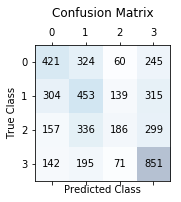


CV Accuracy: 42.860 +/- 0.600
Scores: [42.36 42.93 42.78 43.95 42.28]


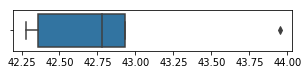


CV CohenKappa: 0.346 +/- 0.024
Scores: [0.319 0.384 0.363 0.334 0.331]


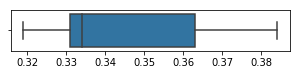

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,GTB 1 (defaults),42.49,0.3597,40.1,37.41,19.02,67.59,"[41.11, 34.63, 40.79, 49.77]","[421, 453, 186, 851]","[603, 855, 270, 859]","[629, 758, 792, 408]","{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_spli...","{'Accuracy': (42.86, 0.6), 'CohenKappa': (0.346, 0.024)}"


In [5]:
from sklearn.ensemble import GradientBoostingClassifier

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_gtb1 = GradientBoostingClassifier(random_state=RANDOM_SEED)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_gtb1
model_label        = 'GTB 1 (defaults)'
model_results_list = model_results_gtb

gtb_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
gtb_results_df

In [7]:
#------------------------------------------------------------
# Explore Model/Decision Tree
#------------------------------------------------------------
model = clf_gtb1
print("Estimators : ", len(model.estimators_))

print("\n- - - - Top Features - - - -")
feature_importance_df = pd.DataFrame(model.feature_importances_, 
                                     index=feature_labels, columns=['importance'])
feature_importance_df[feature_importance_df.importance!=0] \
    .sort_values(by='importance', ascending=False) \
    .head(10)

Estimators :  100

- - - - Top Features - - - -


,importance
NbrProfiles,0.214804
Age,0.160415
PrimaryBreed_MixedBreed,0.099747
PhotoAmt,0.082043
Sterilized_No,0.045562
DescSentimentMagnitude,0.040805
DescNbrSentences,0.033535
Quantity,0.032024
DescSentimentScore,0.029539
Fee,0.024593


#### Quick Thoughts on Results
- **A good first start!**  Results are just a little short of the best approaches with Random Forests (Accuracy 43.5%, CohenKappa 0.3724) and Model 1 (42.5%, 0.3597).
- The CV result are on par with Random Forest - some variation and an outlier.

<a id="model_gtb2"></a>
## GTB 2 - Grid Search on Tree Parameters
[Back to Gradient Tree Boosting](#model_grad_tree_boosting)

Let's do a grid search on the size of the tree (max_depth) & features available at each split (max_features).  The defaults are depth=3 and all features.  Here I'm continuing to use the defaults for estimators (100) and learning rate (0.1).

In [26]:
#------------------------------------------------------------
# create classifier
#------------------------------------------------------------
clf_gtb2 = GradientBoostingClassifier(random_state=RANDOM_SEED)
model = clf_gtb2

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 5-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------

param_grid  = {'max_depth'    :[1, 2, 3, 4, 5, 6, 7, 8],
               'max_features' :[0.25, 0.5, 0.75, 1.0]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=5)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'max_depth': 8, 'max_features': 0.25}

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.25, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=114,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [27]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
results_df = pd.DataFrame({'Params'     : gs.cv_results_['params'],
              'CohenKappa' : np.round(gs.cv_results_['mean_test_CohenKappa'], 3),
              'Accuracy'   : np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2),
              'Rank'       : gs.cv_results_['rank_test_CohenKappa'],
              'CohenKappa_Train' : np.round(gs.cv_results_['mean_train_CohenKappa'], 3),
              'Accuracy_Train'   : np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2) })

results_df

,Params,CohenKappa,Accuracy,Rank,CohenKappa_Train,Accuracy_Train
0,"{'max_depth': 1, 'max_features': 0.25}",0.296,40.50,32,0.309,42.04
1,"{'max_depth': 1, 'max_features': 0.5}",0.296,40.70,31,0.308,42.03
2,"{'max_depth': 1, 'max_features': 0.75}",0.296,40.64,30,0.309,42.01
3,"{'max_depth': 1, 'max_features': 1.0}",0.297,40.60,29,0.310,42.04
4,"{'max_depth': 2, 'max_features': 0.25}",0.329,41.81,28,0.364,45.36
5,"{'max_depth': 2, 'max_features': 0.5}",0.329,42.03,27,0.374,46.01
6,"{'max_depth': 2, 'max_features': 0.75}",0.334,42.17,25,0.374,46.07
7,"{'max_depth': 2, 'max_features': 1.0}",0.332,42.28,26,0.372,46.11
8,"{'max_depth': 3, 'max_features': 0.25}",0.350,43.08,20,0.422,49.74
9,"{'max_depth': 3, 'max_features': 0.5}",0.345,42.73,24,0.429,50.38



Accuracy      : 43.26
Cohen's Kappa : 0.3860

Classification Report
              precision    recall  f1-score   support

           0       0.41      0.40      0.41      1050
           1       0.36      0.37      0.37      1211
           2       0.38      0.25      0.30       978
           3       0.53      0.66      0.59      1259

   micro avg       0.43      0.43      0.43      4498
   macro avg       0.42      0.42      0.41      4498
weighted avg       0.42      0.43      0.42      4498



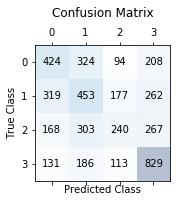


CV Accuracy: 44.150 +/- 0.460
Scores: [43.65 44.31 44.59 44.66 43.57]


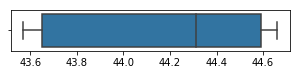


CV CohenKappa: 0.368 +/- 0.018
Scores: [0.354 0.387 0.392 0.36  0.348]


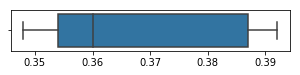

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,GTB 1 (defaults),42.49,0.3597,40.10,37.41,19.02,67.59,"[41.11, 34.63, 40.79, 49.77]","[421, 453, 186, 851]","[603, 855, 270, 859]","[629, 758, 792, 408]","{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_spli...","{'Accuracy': (42.86, 0.6), 'CohenKappa': (0.346, 0.024)}"
1,"GTB 2 (depth=8, features=25%)",43.26,0.3860,40.38,37.41,24.54,65.85,"[40.69, 35.78, 38.46, 52.94]","[424, 453, 240, 829]","[618, 813, 384, 737]","[626, 758, 738, 430]","{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'max_features': 0.25, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_spli...","{'Accuracy': (44.15, 0.46), 'CohenKappa': (0.368, 0.018)}"


In [29]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_gtb2 = GradientBoostingClassifier(random_state=RANDOM_SEED, max_depth=8, max_features=0.25)
model    = clf_gtb2

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_gtb2
model_label        = 'GTB 2 (depth=8, features=25%)'
model_results_list = model_results_gtb

gtb_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
gtb_results_df

In [30]:
#------------------------------------------------------------
# Explore Model/Decision Tree
#------------------------------------------------------------
print("Estimators : ", len(model.estimators_))

print("\n- - - - Top Features - - - -")
feature_importance_df = pd.DataFrame(model.feature_importances_, 
                                     index=feature_labels, columns=['importance'])
feature_importance_df[feature_importance_df.importance!=0] \
    .sort_values(by='importance', ascending=False) \
    .head(10)

Estimators :  100

- - - - Top Features - - - -


,importance
NbrProfiles,0.117329
Age,0.096752
DescSentimentMagnitude,0.084213
PhotoAmt,0.069416
DescSentimentScore,0.058393
DescNbrSentences,0.056094
Fee,0.030474
Quantity,0.029271
Sterilized_No,0.024752
PrimaryBreed_MixedBreed,0.022163


#### Quick Thoughts on Results
- The GTB 2 model is my new **BEST!** with a touch higher CohenKappa of 0.3860 (vs. 0.3724 on Forest 1).
- The grid search suggested the best parameter are to constrain the tree to 8 levels deep and constructed considering only 25% of the features.  Then we still use 100 trees, each trying to improve on the errors present with the previous tree.  The top 3 results all constrained max_features to 0.25 but varied depth from 5, 7, 8.

<a id="model_gtb3"></a>
## GTB 3 - Grid Search on Boosting Parameters
[Back to Gradient Tree Boosting](#model_grad_tree_boosting)

Continuing with my new best model, let's do a grid search on the number of estimators/iterations and learning rate.

In [31]:
#------------------------------------------------------------
# create classifier
#------------------------------------------------------------
clf_gtb3 = GradientBoostingClassifier(random_state=RANDOM_SEED, max_depth=8, max_features=0.25)
model = clf_gtb3

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 5-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------

param_grid  = {'n_estimators'  :[50, 75, 100, 125, 150],
               'learning_rate' :[0.01, 0.1, 0.15, 0.25]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=5)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'learning_rate': 0.1, 'n_estimators': 125}

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.25, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=125,
              n_iter_no_change=None, presort='auto', random_state=114,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [32]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
results_df = pd.DataFrame({'Params'     : gs.cv_results_['params'],
              'CohenKappa' : np.round(gs.cv_results_['mean_test_CohenKappa'], 3),
              'Accuracy'   : np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2),
              'Rank'       : gs.cv_results_['rank_test_CohenKappa'],
              'CohenKappa_Train' : np.round(gs.cv_results_['mean_train_CohenKappa'], 3),
              'Accuracy_Train'   : np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2) })

results_df

,Params,CohenKappa,Accuracy,Rank,CohenKappa_Train,Accuracy_Train
0,"{'learning_rate': 0.01, 'n_estimators': 50}",0.352,43.18,10,0.587,63.74
1,"{'learning_rate': 0.01, 'n_estimators': 75}",0.360,43.57,9,0.604,65.43
2,"{'learning_rate': 0.01, 'n_estimators': 100}",0.362,43.53,6,0.619,66.91
3,"{'learning_rate': 0.01, 'n_estimators': 125}",0.366,43.70,3,0.632,68.22
4,"{'learning_rate': 0.01, 'n_estimators': 150}",0.365,43.70,5,0.646,69.62
5,"{'learning_rate': 0.1, 'n_estimators': 50}",0.361,43.55,8,0.775,81.44
6,"{'learning_rate': 0.1, 'n_estimators': 75}",0.361,43.72,7,0.838,86.96
7,"{'learning_rate': 0.1, 'n_estimators': 100}",0.368,44.15,2,0.884,90.89
8,"{'learning_rate': 0.1, 'n_estimators': 125}",0.372,44.38,1,0.922,93.90
9,"{'learning_rate': 0.1, 'n_estimators': 150}",0.365,43.95,4,0.952,96.21



Accuracy      : 43.06
Cohen's Kappa : 0.3877

Classification Report
              precision    recall  f1-score   support

           0       0.40      0.40      0.40      1050
           1       0.35      0.37      0.36      1211
           2       0.38      0.25      0.30       978
           3       0.54      0.66      0.59      1259

   micro avg       0.43      0.43      0.43      4498
   macro avg       0.42      0.42      0.41      4498
weighted avg       0.42      0.43      0.42      4498



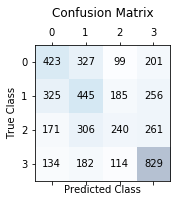


CV Accuracy: 44.380 +/- 0.410
Scores: [45.03 43.78 44.21 44.57 44.33]


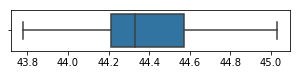


CV CohenKappa: 0.372 +/- 0.010
Scores: [0.378 0.378 0.383 0.356 0.364]


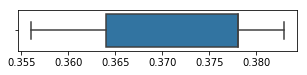

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,GTB 1 (defaults),42.49,0.3597,40.10,37.41,19.02,67.59,"[41.11, 34.63, 40.79, 49.77]","[421, 453, 186, 851]","[603, 855, 270, 859]","[629, 758, 792, 408]","{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_spli...","{'Accuracy': (42.86, 0.6), 'CohenKappa': (0.346, 0.024)}"
1,"GTB 2 (depth=8, features=25%)",43.26,0.3860,40.38,37.41,24.54,65.85,"[40.69, 35.78, 38.46, 52.94]","[424, 453, 240, 829]","[618, 813, 384, 737]","[626, 758, 738, 430]","{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'max_features': 0.25, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_spli...","{'Accuracy': (44.15, 0.46), 'CohenKappa': (0.368, 0.018)}"
2,"GTB 3 (depth=8, features=25%; clfs=125)",43.06,0.3877,40.29,36.75,24.54,65.85,"[40.17, 35.32, 37.62, 53.59]","[423, 445, 240, 829]","[630, 815, 398, 718]","[627, 766, 738, 430]","{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'max_features': 0.25, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_spli...","{'Accuracy': (44.38, 0.41), 'CohenKappa': (0.372, 0.01)}"


In [33]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_gtb3 = GradientBoostingClassifier(random_state=RANDOM_SEED, max_depth=8, max_features=0.25,
                                      learning_rate=0.1, n_estimators=125)
model    = clf_gtb3

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_gtb3
model_label        = 'GTB 3 (depth=8, features=25%; clfs=125)'
model_results_list = model_results_gtb

gtb_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=5)
gtb_results_df

In [35]:
#------------------------------------------------------------
# Explore Model/Decision Tree
#------------------------------------------------------------
print("Estimators : ", len(model.estimators_))

print("\n- - - - Top Features - - - -")
feature_importance_df = pd.DataFrame(model.feature_importances_, 
                                     index=feature_labels, columns=['importance'])
feature_importance_df[feature_importance_df.importance!=0] \
    .sort_values(by='importance', ascending=False) \
    .head(10)

Estimators :  125

- - - - Top Features - - - -


,importance
NbrProfiles,0.115413
Age,0.095199
DescSentimentMagnitude,0.085737
PhotoAmt,0.069155
DescSentimentScore,0.059006
DescNbrSentences,0.056997
Fee,0.030072
Quantity,0.029244
Sterilized_No,0.023961
PrimaryBreed_MixedBreed,0.021471


#### Quick Thoughts on Results
- The grid search found the best results using the default learning rate of 0.1, but added additional classifiers (125 vs. 100).
- This model was a tiny bit better on CohenKappa than GTB 2 (0.3877 vs. 0.3860) and Accuracy about the same.
  - The TPRs per class ranges from 25% to 66% and PPV range from 35% to 54%.

In [34]:
gtb_results_df.to_csv('results_gtb.csv', index=False)

## Thoughts on Gradient Tree Boosting

**Gradient Tree Boosting was effective on this dataset!**  I finally have a new best model: GTB 3 where I am boosting 8-level deep trees constructed considering 25% (or about 18) of the 75 features at each split.  And doing up to 125 of iteration where each tree attempts to address the errors at the prior tree.

**The best results so far is Accuracy 43% with a Cohen Kappa score of 0.3877.**

<a id="model_stack"></a>
# Stacking
[Table of Contents](#TOC)

*"The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote (or the average predicted probabilities (soft vote)) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses."*  (from the documentation)

Models/Tunings:
- [Best Algorithms](#model_stk1)
- [Best Model for each Class](#model_stk2)

*Links to Documentation*
- [Voting Classifier](https://scikit-learn.org/0.20/modules/ensemble.html#voting-classifier)
- [VotingClassifier](https://scikit-learn.org/0.20/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [4]:
model_results_stk = []

<a id="model_stk1"></a>
## Stacking 1 - Best Algorithms
[Back to Stacking](#model_stack)

First, I will stack the models from the algorithms where I got the best results.
- GTD 3 (depth=8, features=25%, classifiers=125) - CohenKappa 0.3877, Accuracy 43.1%
- Forest 1 (defaults) - CohenKappa 0.3724, Accuracy 43.5%
- Ada 2 (DT, clf=75) - CohenKappa 0.3327, Accuracy 41.8%


Accuracy      : 43.06
Cohen's Kappa : 0.3877

Classification Report
              precision    recall  f1-score   support

           0       0.40      0.40      0.40      1050
           1       0.35      0.37      0.36      1211
           2       0.38      0.25      0.30       978
           3       0.54      0.66      0.59      1259

   micro avg       0.43      0.43      0.43      4498
   macro avg       0.42      0.42      0.41      4498
weighted avg       0.42      0.43      0.42      4498



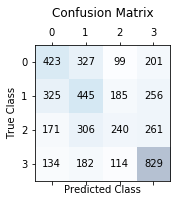


Accuracy      : 43.53
Cohen's Kappa : 0.3724

Classification Report
              precision    recall  f1-score   support

           0       0.41      0.42      0.41      1050
           1       0.37      0.36      0.36      1211
           2       0.37      0.24      0.29       978
           3       0.52      0.68      0.59      1259

   micro avg       0.44      0.44      0.44      4498
   macro avg       0.42      0.42      0.41      4498
weighted avg       0.42      0.44      0.42      4498



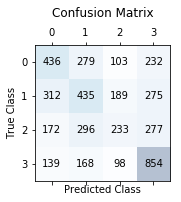


Accuracy      : 41.75
Cohen's Kappa : 0.3327

Classification Report
              precision    recall  f1-score   support

           0       0.40      0.39      0.39      1050
           1       0.35      0.36      0.35      1211
           2       0.38      0.22      0.28       978
           3       0.49      0.65      0.56      1259

   micro avg       0.42      0.42      0.42      4498
   macro avg       0.41      0.40      0.40      4498
weighted avg       0.41      0.42      0.40      4498



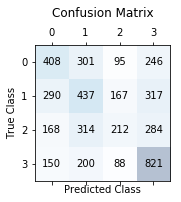


Accuracy      : 44.29
Cohen's Kappa : 0.3828

Classification Report
              precision    recall  f1-score   support

           0       0.40      0.46      0.43      1050
           1       0.36      0.36      0.36      1211
           2       0.44      0.23      0.30       978
           3       0.53      0.68      0.60      1259

   micro avg       0.44      0.44      0.44      4498
   macro avg       0.43      0.43      0.42      4498
weighted avg       0.44      0.44      0.43      4498



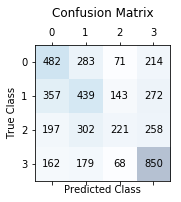

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Stk1:GTB 3,43.06,0.3877,40.29,36.75,24.54,65.85,"[40.17, 35.32, 37.62, 53.59]","[423, 445, 240, 829]","[630, 815, 398, 718]","[627, 766, 738, 430]","{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'max_features': 0.25, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_spli...",None
1,Stk1:Forest 1,43.53,0.3724,41.52,35.92,23.82,67.83,"[41.17, 36.93, 37.4, 52.14]","[436, 435, 233, 854]","[623, 743, 390, 784]","[614, 776, 745, 405]","{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight...",None
2,Stk1:Ada 2 (DT),41.75,0.3327,38.86,36.09,21.68,65.21,"[40.16, 34.9, 37.72, 49.22]","[408, 437, 212, 821]","[608, 815, 350, 847]","[642, 774, 766, 438]","{'algorithm': 'SAMME.R', 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrea...",None
3,Stack 1 (Best Algo),44.29,0.3828,45.90,36.25,22.60,67.51,"[40.23, 36.49, 43.94, 53.32]","[482, 439, 221, 850]","[716, 764, 282, 744]","[568, 772, 757, 409]","{'estimators': [('gtb3', GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=8, max_features=0.25, max_leaf_nodes=None, min_impurity_decrease=0.0,...",None


In [5]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree     import DecisionTreeClassifier

#------------------------------------------------------------
# create model
#------------------------------------------------------------
# models to stack
clf_gtb3 = GradientBoostingClassifier(random_state=RANDOM_SEED, max_depth=8, max_features=0.25,
                                      learning_rate=0.1, n_estimators=125)

clf_rf1  = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100)

base_clf = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=1)
clf_ada2 = AdaBoostClassifier(random_state=RANDOM_SEED, base_estimator=base_clf,
                             learning_rate=1.0, n_estimators=75)


# the "stacked" model
clf_stk1 = VotingClassifier(estimators=[('gtb3', clf_gtb3), 
                                        ('rf1', clf_rf1), 
                                        ('ada2', clf_ada2)],
                            voting='hard')

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_stk1
model_label        = 'Stack 1 (Best Algo)'
model_results_list = model_results_stk

for model, model_label in zip([clf_gtb3, clf_rf1, clf_ada2, clf_stk1], 
                        ['Stk1:GTB 3',
                         'Stk1:Forest 1',
                         'Stk1:Ada 2 (DT)', 
                         'Stack 1 (Best Algo)']):
    stk_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, skip_cv=True)
stk_results_df

#### Quick Thoughts on Results
- The overall Accuracy on the Stacked model is better than any of the individual models (44.29%) and actually the best so far!  The Cohen's Kappa score 0.3828 is a tiny bit below the best (by just 0.0049).
- The results by Class are good as well
  - Class 0 - TPR 46%, PPV 40% - better than the individual stacked models
  - Class 1 - TRP 36%, PPV 36% - one included model is better (GTB 3)
  - Class 2 - TRP 23%, PPV 44% - two included models are slightly better (GTB - 25%, Forest - 24%)
  - Class 3 - TRP 68%, PPV 53% - one included model is better (Forest - 67.8 vs 67.5)
- This is a good use of Stacking - mostly achieving the best of the stacked models.

<a id="model_stk2"></a>
# Stacking 2 - Best Model for each Class
[Back to Stacking](#model_stack)

I will stack the models where I achieved the highest TPR for each class.
- Class 0 - SGD 1 - TPR 52%
- Class 1 - SGD 3 - TPR 66%
- Class 2 - SVM-L 1 - TPR 43%
- Class 3 - SGD 4 - TPR 73%
- Best Model as Tie Breaker (odd # of votes) - GTB 3

I am curious if stacking will meld the good performance by class together to degrade to the least common denominator.


Accuracy      : 34.70
Cohen's Kappa : 0.2263

Classification Report
              precision    recall  f1-score   support

           0       0.31      0.52      0.39      1050
           1       0.29      0.16      0.21      1211
           2       0.30      0.28      0.29       978
           3       0.48      0.43      0.45      1259

   micro avg       0.35      0.35      0.35      4498
   macro avg       0.34      0.35      0.34      4498
weighted avg       0.35      0.35      0.34      4498



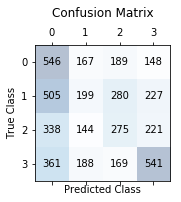


Accuracy      : 36.82
Cohen's Kappa : 0.2660

Classification Report
              precision    recall  f1-score   support

           0       0.41      0.14      0.21      1050
           1       0.30      0.66      0.42      1211
           2       0.38      0.10      0.15       978
           3       0.49      0.48      0.48      1259

   micro avg       0.37      0.37      0.37      4498
   macro avg       0.40      0.35      0.32      4498
weighted avg       0.40      0.37      0.33      4498



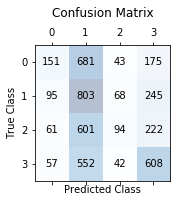


Accuracy      : 26.92
Cohen's Kappa : 0.1188

Classification Report
              precision    recall  f1-score   support

           0       0.32      0.26      0.29      1050
           1       0.25      0.24      0.24      1211
           2       0.21      0.43      0.28       978
           3       0.46      0.18      0.26      1259

   micro avg       0.27      0.27      0.27      4498
   macro avg       0.31      0.28      0.27      4498
weighted avg       0.31      0.27      0.27      4498



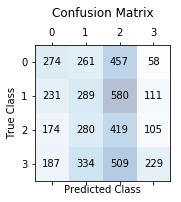


Accuracy      : 38.91
Cohen's Kappa : 0.2835

Classification Report
              precision    recall  f1-score   support

           0       0.37      0.40      0.39      1050
           1       0.31      0.19      0.24      1211
           2       0.35      0.19      0.24       978
           3       0.43      0.73      0.54      1259

   micro avg       0.39      0.39      0.39      4498
   macro avg       0.37      0.38      0.35      4498
weighted avg       0.37      0.39      0.36      4498



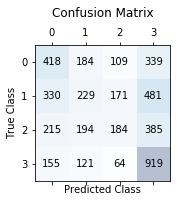


Accuracy      : 43.06
Cohen's Kappa : 0.3877

Classification Report
              precision    recall  f1-score   support

           0       0.40      0.40      0.40      1050
           1       0.35      0.37      0.36      1211
           2       0.38      0.25      0.30       978
           3       0.54      0.66      0.59      1259

   micro avg       0.43      0.43      0.43      4498
   macro avg       0.42      0.42      0.41      4498
weighted avg       0.42      0.43      0.42      4498



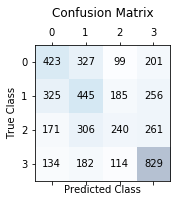


Accuracy      : 39.75
Cohen's Kappa : 0.3250

Classification Report
              precision    recall  f1-score   support

           0       0.38      0.48      0.42      1050
           1       0.32      0.33      0.32      1211
           2       0.35      0.19      0.24       978
           3       0.51      0.56      0.53      1259

   micro avg       0.40      0.40      0.40      4498
   macro avg       0.39      0.39      0.38      4498
weighted avg       0.39      0.40      0.39      4498



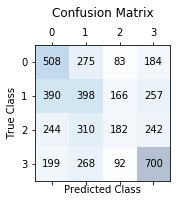

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,Stk1:GTB 3,43.06,0.3877,40.29,36.75,24.54,65.85,"[40.17, 35.32, 37.62, 53.59]","[423, 445, 240, 829]","[630, 815, 398, 718]","[627, 766, 738, 430]","{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'max_features': 0.25, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_spli...",None
1,Stk1:Forest 1,43.53,0.3724,41.52,35.92,23.82,67.83,"[41.17, 36.93, 37.4, 52.14]","[436, 435, 233, 854]","[623, 743, 390, 784]","[614, 776, 745, 405]","{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight...",None
2,Stk1:Ada 2 (DT),41.75,0.3327,38.86,36.09,21.68,65.21,"[40.16, 34.9, 37.72, 49.22]","[408, 437, 212, 821]","[608, 815, 350, 847]","[642, 774, 766, 438]","{'algorithm': 'SAMME.R', 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrea...",None
3,Stack 1 (Best Algo),44.29,0.3828,45.90,36.25,22.60,67.51,"[40.23, 36.49, 43.94, 53.32]","[482, 439, 221, 850]","[716, 764, 282, 744]","[568, 772, 757, 409]","{'estimators': [('gtb3', GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=8, max_features=0.25, max_leaf_nodes=None, min_impurity_decrease=0.0,...",None
4,Stk2:SGD 1,34.70,0.2263,52.00,16.43,28.12,42.97,"[31.2, 28.51, 30.12, 47.58]","[546, 199, 275, 541]","[1204, 499, 638, 596]","[504, 1012, 703, 718]","{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter': None, 'n_iter_no_cha...",None
5,Stk2:SGD 3,36.82,0.2660,14.38,66.31,9.61,48.29,"[41.48, 30.45, 38.06, 48.64]","[151, 803, 94, 608]","[213, 1834, 153, 642]","[899, 408, 884, 651]","{'alpha': 0.01, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter': None, 'n_iter_no_chang...",None
6,Stk2:SVM-L 1,26.92,0.1188,26.10,23.86,42.84,18.19,"[31.64, 24.83, 21.32, 45.53]","[274, 289, 419, 229]","[592, 875, 1546, 274]","[776, 922, 559, 1030]","{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 114, 'tol': 0.0001, 'verbose': 0}",None
7,Stk2:SGD 4,38.91,0.2835,39.81,18.91,18.81,72.99,"[37.39, 31.46, 34.85, 43.27]","[418, 229, 184, 919]","[700, 499, 344, 1205]","[632, 982, 794, 340]","{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter': None, 'n_iter_no_cha...",None
8,Stk2:GTB 3,43.06,0.3877,40.29,36.75,24.54,65.85,"[40.17, 35.32, 37.62, 53.59]","[423, 445, 240, 829]","[630, 815, 398, 718]","[627, 766, 738, 430]","{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'max_features': 0.25, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_spli...",None
9,Stack 2 (Best Class TPR),39.75,0.3250,48.38,32.87,18.61,55.60,"[37.88, 31.81, 34.8, 50.61]","[508, 398, 182, 700]","[833, 853, 341, 683]","[542, 813, 796, 559]","{'estimators': [('sgd1', SGDClassifier(alpha=0.0001, average=False, class_weight=None, early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=Tr

In [7]:
from sklearn.ensemble     import VotingClassifier
from sklearn.ensemble     import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm          import LinearSVC


#------------------------------------------------------------
# create model
#------------------------------------------------------------
# models to stack

# Class 0 - SGD 1 - TPR 52%
clf_sgd1 = SGDClassifier(random_state=RANDOM_SEED, 
                         loss='hinge', max_iter=1000, tol=1e-3)

# Class 1 - SGD 3 - TPR 66%
clf_sgd3 = SGDClassifier(random_state=RANDOM_SEED, 
                         loss='hinge', max_iter=1000, tol=1e-3,
                         alpha=0.01)

# Class 2 - SVM-L 1 - TPR 43%
clf_svml1 = LinearSVC(random_state=RANDOM_SEED, loss='hinge')

# Class 3 - SGD 4 - TPR 73%
clf_sgd4 = SGDClassifier(random_state=RANDOM_SEED, 
                         loss='hinge', max_iter=1000, tol=1e-3,
                         alpha=0.0001, penalty='l1')

# Best Model as Tie Breaker (odd # of votes) - GTB 3
clf_gtb3 = GradientBoostingClassifier(random_state=RANDOM_SEED, max_depth=8, max_features=0.25,
                                      learning_rate=0.1, n_estimators=125)

# the "stacked" model
clf_stk2 = VotingClassifier(estimators=[('sgd1', clf_sgd1),
                                        ('sgd3', clf_sgd3),
                                        ('svml1',clf_svml1), 
                                        ('sgd4', clf_sgd4),
                                        ('gtb3', clf_gtb3)],
                            voting='hard')

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=5)
#------------------------------------------------------------
model              = clf_stk2
model_label        = 'Stack 2 (Best Class TPR)'
model_results_list = model_results_stk

for model, model_label in zip([clf_sgd1, clf_sgd3, clf_svml1, clf_sgd4,
                               clf_gtb3, clf_stk2], 
                        ['Stk2:SGD 1',
                         'Stk2:SGD 3',
                         'Stk2:SVM-L 1',
                         'Stk2:SGD 4', 
                         'Stk2:GTB 3',
                         'Stack 2 (Best Class TPR)']):
    stk_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, skip_cv=True)
stk_results_df

#### Quick Thoughts on Results
- Not so hot.  The results tend more toward the least common denominator.  When a model is really strong (on TPR) on one class it was much weaker on another class (or classes).  That lower performance in other classes is holding things back, rather than taking the best of each model.

In [8]:
stk_results_df.to_csv('results_stk.csv', index=False)

## Thoughts on Stacking
Stacking the models from several algorithms where I achieve the strongest results worked well!  The Stack 1 model was an improvement in a number of directions across to the individual models.

It is a real toss up between Stack 1 and the best performing individual model (GTB 3).  The GTB 3 modeledges out Stack 1 on the Cohen's Kappa score (0.3877 vs. 0.3828 - a tiny difference of 0.0049).  But the overall accuracy of Stack 1 is better 44.3% vs 43.06.
- Stack 1 (as compared to GTB 3) predicts the correct adoption speed for 80 (Class 0 and Class 4) pets, while being incorrect on 25 (Class 1 and 2) pets.
- Stack 1 has stronger TPR results on Class 0 (adopted in first week) correctly identify 59 pets with the same PPV rate (40%) the GTB 3 model.  Fifty-nine pets represents 1.3% of the test dataset, which is notable in my opinion.

<a id="model_ann"></a>
# Neural Network
[Table of Contents](#TOC)

Models/Tunings:
- [Default Values](#model_ann1)
- [Grid Search on Activation Function and Initial Nodes](#model_ann2)
- [Grid Search on Learning Rate and Nodes](#model_ann3)
- [Grid Search on L2 Penalty](#model_ann4)

*Links to Documentation*
- [Neural Network](https://scikit-learn.org/0.20/modules/neural_networks_supervised.html)
- [MLPClassifier](https://scikit-learn.org/0.20/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [15]:
model_results_nn = []

<a id="model_ann1"></a>
## NN 1 - Default Values
[Back to Neural Networks](#model_ann)

I will start with the default values, but adjust the network to be limited to 1 hidden layer with 75 nodes (1 per input feature).  I also increased maximum iteration to converge from 200 to 1000.  In some initial executions, I received warnings that the solver did not converge.

The notable default values include:
- hidden_layer_sizes=(100,)
- activation='relu'
  - 'logistic', 'tanh'
- alpha=0.0001 (L2 penalty)
- max_iter=200 & tol=1e-4
- learning_rate='constant' (given by learning_rate_init=0.001)
  - invscaling, adaptive


Accuracy      : 36.73
Cohen's Kappa : 0.2531

Classification Report
              precision    recall  f1-score   support

           0       0.35      0.33      0.34      1050
           1       0.32      0.32      0.32      1211
           2       0.30      0.22      0.25       978
           3       0.45      0.56      0.50      1259

   micro avg       0.37      0.37      0.37      4498
   macro avg       0.35      0.36      0.35      4498
weighted avg       0.36      0.37      0.36      4498



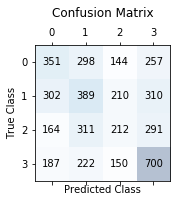


CV Accuracy: 34.440 +/- 0.550
Scores: [35.06 34.53 33.71]


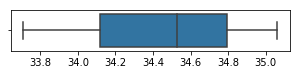


CV CohenKappa: 0.217 +/- 0.005
Scores: [0.224 0.215 0.212]


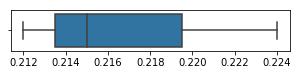

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,NN 1 (defaults),36.73,0.2531,33.43,32.12,21.68,55.6,"[34.96, 31.89, 29.61, 44.93]","[351, 389, 212, 700]","[653, 831, 504, 858]","[699, 822, 766, 559]","{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (75,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000, 'mom...","{'Accuracy': (34.44, 0.55), 'CohenKappa': (0.217, 0.005)}"


In [16]:
from sklearn.neural_network import MLPClassifier

#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_nn1 = MLPClassifier(random_state=RANDOM_SEED, hidden_layer_sizes=(75,),
                       max_iter=1000)


#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=3)
#------------------------------------------------------------
model              = clf_nn1
model_label        = 'NN 1 (defaults)'
model_results_list = model_results_nn

nn_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=3)
nn_results_df

Layers  :  3
Outputs :  4
n_iter  :  605


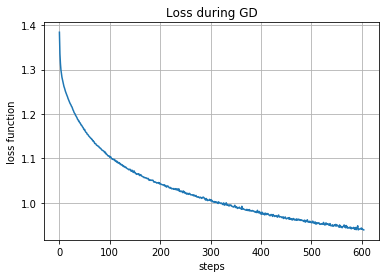

In [17]:
#------------------------------------------------------------
# explore available info about model/network
#------------------------------------------------------------
model = clf_nn1
print("Layers  : ", model.n_layers_)
print("Outputs : ", model.n_outputs_)
print("n_iter  : ", model.n_iter_)

fig, ax = plt.subplots()
ax.plot(model.loss_curve_)
ax.set(xlabel='steps', ylabel='loss function', title='Loss during GD')
ax.grid()
plt.show()

#### Quick Thoughts on Results
- Not so hot, CohenKappa of 0.25 puts the model in about the bottom 1/3 the models so far.
- The model is accurate a little over 1/3 of the time (37%).  TPR on classes of AdoptionSpeed range from 22 - 55%

<a id="model_ann2"></a>
## NN 2 - Grid Search on Activation Function and Initial Nodes
[Back to Neural Networks](#model_ann)

I am interested in which activation function might work best on this data.
- relu (default) - the rectified linear unit function, returns f(x) = max(0, x)
- logistic - the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x))
- tanh, the hyperbolic tan function, returns f(x) = tanh(x)

I will also try networks of varying number of nodes in one hidden layer to help determine which activation works best.  I will use the following range of nodes [15, 30, 45, 60, 75].

In [18]:
#------------------------------------------------------------
# create classifier
#------------------------------------------------------------
clf_nn2 = MLPClassifier(random_state=RANDOM_SEED, hidden_layer_sizes=(75,),
                       max_iter=1000)
model = clf_nn2

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 3-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------

param_grid  = {'activation'         :['relu', 'logistic', 'tanh'],
               'hidden_layer_sizes' :[(15,), (30,), (45,), (60,), (75,)]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=3)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'activation': 'logistic', 'hidden_layer_sizes': (15,)}

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=114, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [19]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
results_df = pd.DataFrame({'Params'     : gs.cv_results_['params'],
              'CohenKappa' : np.round(gs.cv_results_['mean_test_CohenKappa'], 3),
              'Accuracy'   : np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2),
              'Rank'       : gs.cv_results_['rank_test_CohenKappa'],
              'CohenKappa_Train' : np.round(gs.cv_results_['mean_train_CohenKappa'], 3),
              'Accuracy_Train'   : np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2) })

results_df

,Params,CohenKappa,Accuracy,Rank,CohenKappa_Train,Accuracy_Train
0,"{'activation': 'relu', 'hidden_layer_sizes': (15,)}",0.267,38.01,2,0.411,47.65
1,"{'activation': 'relu', 'hidden_layer_sizes': (30,)}",0.250,36.92,7,0.468,52.74
2,"{'activation': 'relu', 'hidden_layer_sizes': (45,)}",0.237,35.83,9,0.529,58.58
3,"{'activation': 'relu', 'hidden_layer_sizes': (60,)}",0.223,34.87,11,0.581,64.36
4,"{'activation': 'relu', 'hidden_layer_sizes': (75,)}",0.217,34.44,12,0.643,67.40
5,"{'activation': 'logistic', 'hidden_layer_sizes': (15,)}",0.288,38.80,1,0.412,47.69
6,"{'activation': 'logistic', 'hidden_layer_sizes': (30,)}",0.252,36.96,6,0.468,52.83
7,"{'activation': 'logistic', 'hidden_layer_sizes': (45,)}",0.249,36.20,8,0.515,56.45
8,"{'activation': 'logistic', 'hidden_layer_sizes': (60,)}",0.260,37.93,5,0.380,47.16
9,"{'activation': 'logistic', 'hidden_layer_sizes': (75,)}",0.264,37.58,3,0.385,47.50



Accuracy      : 39.68
Cohen's Kappa : 0.3172

Classification Report
              precision    recall  f1-score   support

           0       0.37      0.38      0.38      1050
           1       0.33      0.35      0.34      1211
           2       0.33      0.18      0.23       978
           3       0.49      0.63      0.55      1259

   micro avg       0.40      0.40      0.40      4498
   macro avg       0.38      0.38      0.37      4498
weighted avg       0.38      0.40      0.38      4498



/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


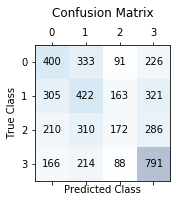

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



CV Accuracy: 38.800 +/- 0.300
Scores: [39.14 38.85 38.4 ]


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


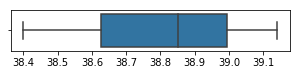


CV CohenKappa: 0.288 +/- 0.010
Scores: [0.297 0.293 0.275]


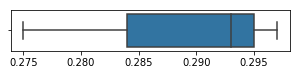

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,NN 1 (defaults),36.73,0.2531,33.43,32.12,21.68,55.60,"[34.96, 31.89, 29.61, 44.93]","[351, 389, 212, 700]","[653, 831, 504, 858]","[699, 822, 766, 559]","{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (75,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000, 'mom...","{'Accuracy': (34.44, 0.55), 'CohenKappa': (0.217, 0.005)}"
1,"NN 2 (fn=logistic, nodes=15)",39.68,0.3172,38.10,34.85,17.59,62.83,"[37.0, 32.99, 33.46, 48.71]","[400, 422, 172, 791]","[681, 857, 342, 833]","[650, 789, 806, 468]","{'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000, ...","{'Accuracy': (38.8, 0.3), 'CohenKappa': (0.288, 0.01)}"


In [20]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_nn2 = MLPClassifier(random_state=RANDOM_SEED, max_iter=1000,
                        activation='logistic',
                        hidden_layer_sizes=(15,))

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=3)
#------------------------------------------------------------
model              = clf_nn2
model_label        = 'NN 2 (fn=logistic, nodes=15)'
model_results_list = model_results_nn

nn_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=3)
nn_results_df

Layers  :  3
Outputs :  4
n_iter  :  1000


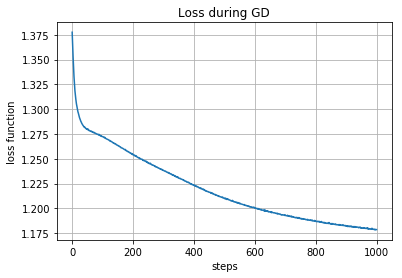

In [21]:
#------------------------------------------------------------
# explore available info about model/network
#------------------------------------------------------------
print("Layers  : ", model.n_layers_)
print("Outputs : ", model.n_outputs_)
print("n_iter  : ", model.n_iter_)

fig, ax = plt.subplots()
ax.plot(model.loss_curve_)
ax.set(xlabel='steps', ylabel='loss function', title='Loss during GD')
ax.grid()
plt.show()

#### Quick Thoughts on Results
- From grid search results, each activation function performed better with a smaller network
  - logistic (best) - CohenKappa declined from 0.288 to 0.264 as network grew from 15 nodes to 75.
  - relu - declined from 0.267 to 0.217
  - tanh - declined from 0.264 to 0.198
- Changing the activation function to "logistic" and using a smaller network shows a nice improvement.  A CohenKappa of 0.31 moves this approach into the top 1/3, but still not great.
- It is interesting the solver does not converge after 1000 iterations and the loss function is not coming down very fast.

<a id="model_ann3"></a>
## NN 3 - Grid Search on Learning Rate and Nodes
[Back to Neural Networks](#model_ann)

Since NN 2 did not converge let's do a grid search adjusting the learning rate and also try to fine tune the nodes in the network.  The default is a constant learning rate of 0.001.  So let's try larger values.

The grid search for Model NN 2 indicated that smaller networks did better, so let's fine tune the search around 15 nodes.  I will use the following range for nodes: [7, 10, 13, 15, 18, 21].

In [22]:
#------------------------------------------------------------
# create classifier
#------------------------------------------------------------
clf_nn3 = MLPClassifier(random_state=RANDOM_SEED, max_iter=1000,
                        activation='logistic',
                        hidden_layer_sizes=(15,))
model = clf_nn3

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 3-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------

param_grid  = {'learning_rate_init' :[0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
               'hidden_layer_sizes' :[(7,), (10,), (13,), (15,), (18,), (21,)]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=3)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'hidden_layer_sizes': (10,), 'learning_rate_init': 0.005}

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.005, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=114, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [23]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
results_df = pd.DataFrame({'Params'     : gs.cv_results_['params'],
              'CohenKappa' : np.round(gs.cv_results_['mean_test_CohenKappa'], 3),
              'Accuracy'   : np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2),
              'Rank'       : gs.cv_results_['rank_test_CohenKappa'],
              'CohenKappa_Train' : np.round(gs.cv_results_['mean_train_CohenKappa'], 3),
              'Accuracy_Train'   : np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2) })

results_df

,Params,CohenKappa,Accuracy,Rank,CohenKappa_Train,Accuracy_Train
0,"{'hidden_layer_sizes': (7,), 'learning_rate_init': 0.0005}",0.276,38.95,13,0.309,41.39
1,"{'hidden_layer_sizes': (7,), 'learning_rate_init': 0.001}",0.287,39.29,6,0.344,43.25
2,"{'hidden_layer_sizes': (7,), 'learning_rate_init': 0.005}",0.278,39.09,11,0.391,45.35
3,"{'hidden_layer_sizes': (7,), 'learning_rate_init': 0.01}",0.289,38.34,2,0.392,45.35
4,"{'hidden_layer_sizes': (7,), 'learning_rate_init': 0.05}",0.269,38.48,18,0.365,44.56
5,"{'hidden_layer_sizes': (7,), 'learning_rate_init': 0.1}",0.244,37.80,33,0.323,41.89
6,"{'hidden_layer_sizes': (10,), 'learning_rate_init': 0.0005}",0.276,39.16,14,0.318,42.27
7,"{'hidden_layer_sizes': (10,), 'learning_rate_init': 0.001}",0.288,39.79,4,0.372,45.64
8,"{'hidden_layer_sizes': (10,), 'learning_rate_init': 0.005}",0.292,39.52,1,0.399,46.72
9,"{'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01}",0.288,39.01,5,0.412,46.65



Accuracy      : 40.55
Cohen's Kappa : 0.3101

Classification Report
              precision    recall  f1-score   support

           0       0.41      0.33      0.36      1050
           1       0.33      0.36      0.35      1211
           2       0.37      0.22      0.28       978
           3       0.47      0.65      0.55      1259

   micro avg       0.41      0.41      0.41      4498
   macro avg       0.40      0.39      0.38      4498
weighted avg       0.40      0.41      0.39      4498



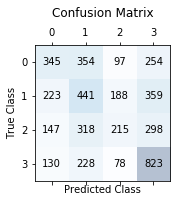


CV Accuracy: 39.520 +/- 1.070
Scores: [39.74 40.71 38.12]


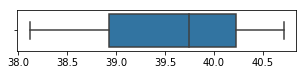


CV CohenKappa: 0.292 +/- 0.013
Scores: [0.276 0.309 0.291]


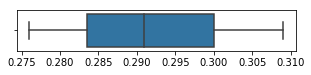

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,NN 1 (defaults),36.73,0.2531,33.43,32.12,21.68,55.60,"[34.96, 31.89, 29.61, 44.93]","[351, 389, 212, 700]","[653, 831, 504, 858]","[699, 822, 766, 559]","{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (75,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000, 'mom...","{'Accuracy': (34.44, 0.55), 'CohenKappa': (0.217, 0.005)}"
1,"NN 2 (fn=logistic, nodes=15)",39.68,0.3172,38.10,34.85,17.59,62.83,"[37.0, 32.99, 33.46, 48.71]","[400, 422, 172, 791]","[681, 857, 342, 833]","[650, 789, 806, 468]","{'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000, ...","{'Accuracy': (38.8, 0.3), 'CohenKappa': (0.288, 0.01)}"
2,"NN 3 (fn=logistic, nodes=10, learn_rate=0.005)",40.55,0.3101,32.86,36.42,21.98,65.37,"[40.83, 32.89, 37.2, 47.46]","[345, 441, 215, 823]","[500, 900, 363, 911]","[705, 770, 763, 436]","{'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'max_iter': 1000, ...","{'Accuracy': (39.52, 1.07), 'CohenKappa': (0.292, 0.013)}"


In [24]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_nn3 = MLPClassifier(random_state=RANDOM_SEED, max_iter=1000,
                        activation='logistic',
                        hidden_layer_sizes=(10,),
                        learning_rate_init=0.005)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=3)
#------------------------------------------------------------
model              = clf_nn3
model_label        = 'NN 3 (fn=logistic, nodes=10, learn_rate=0.005)'
model_results_list = model_results_nn

nn_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=3)
nn_results_df

Layers  :  3
Outputs :  4
n_iter  :  309


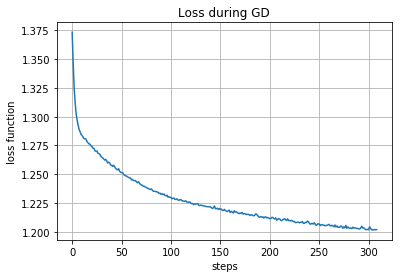

In [25]:
#------------------------------------------------------------
# explore available info about model/network
#------------------------------------------------------------
print("Layers  : ", model.n_layers_)
print("Outputs : ", model.n_outputs_)
print("n_iter  : ", model.n_iter_)

fig, ax = plt.subplots()
ax.plot(model.loss_curve_)
ax.set(xlabel='steps', ylabel='loss function', title='Loss during GD')
ax.grid()
plt.show()

#### Quick Thoughts on Results
- I did not see anything strange in the grid search results. But it is not as easy to see a clear trend.  Generally, it appears the larger networks performed better with a smaller learning rate and vice versa.  There were multiple high ranked results in the 10 node network.  The best learning rate was just a little higher than the default (0.005 vs 0.0001).
- The resulting model with 10 nodes and the larger learning rate did converge in 309 iterations.  But the model ends up about the same as NN2 - slightly better Accuracy (40.6% vs. 39.7%), but CohenKappa slips a tiny bit (0.3101 from 0.3172).

In [43]:
#------------------------------------------------------------
# explore weights between nodes
#------------------------------------------------------------

# # input layer to hidden layer 1
# model.coefs_[0].shape
# # (75, 10)
# # 75 feature/inputs and 10 nodes in hidden layer 1

print("Weights Input => Hidden_1")
print("Min Weight:", model.coefs_[0].min())
print("Max Weight:", model.coefs_[0].max())

# # hidden layer 1 to output
# model.coefs_[1].shape
# # (10, 4)
# # 10 nodes in hidden layer 1 to 4 nodes in output layer (1 for each class)

print()
print("Weights Hidden_1 => Output")
print("Min Weight:", model.coefs_[1].min())
print("Max Weight:", model.coefs_[1].max())

Weights Input => Hidden_1
Min Weight: -41.92136536421882
Max Weight: 18.846283625024284

Weights Hidden_1 => Output
Min Weight: -4.593764414888601
Max Weight: 2.658090363481703


#### Quick Thoughts on Results
- There is some variation in the weights of the nodes.  So let's explore adjusting the L2 penalty to shrink more extreme weights.

<a id="model_ann4"></a>
## NN 4 - Grid Search on L2 Penalty
[Back to Neural Networks](#model_ann)

As noted above, there is wide variation on the weights between the nodes in the network.  So let's explore some adjustments in the L2 penalty (alpha).

In [48]:
#------------------------------------------------------------
# create classifier
#------------------------------------------------------------
clf_nn4 = MLPClassifier(random_state=RANDOM_SEED, max_iter=1000,
                        activation='logistic',
                        hidden_layer_sizes=(10,),
                        learning_rate_init=0.005)
model = clf_nn4

#------------------------------------------------------------
# define parameters to search
# defaults 
#  - use "CohenKappa" as metric to determine "best" parameter value
#  - use 3-fold CV within grid search
#
# execute grid search
#------------------------------------------------------------

param_grid  = {'alpha' :[1e-07, 1e-06, 1e-05, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}

gs = clfmulti_grid_search(model, features_train, target_train, param_grid, cv_folds=3)

#------------------------------------------------------------
# print best parameters & model
#------------------------------------------------------------
print("Best Params\n", gs.best_params_)
print()

gs_best_model = gs.best_estimator_
print(gs_best_model)

Best Params
 {'alpha': 1e-05}

MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.005, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=114, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [49]:
#------------------------------------------------------------
# review results of grid search ... 
#------------------------------------------------------------
results_df = pd.DataFrame({'Params'     : gs.cv_results_['params'],
              'CohenKappa' : np.round(gs.cv_results_['mean_test_CohenKappa'], 3),
              'Accuracy'   : np.round(gs.cv_results_['mean_test_Accuracy'] * 100, 2),
              'Rank'       : gs.cv_results_['rank_test_CohenKappa'],
              'CohenKappa_Train' : np.round(gs.cv_results_['mean_train_CohenKappa'], 3),
              'Accuracy_Train'   : np.round(gs.cv_results_['mean_train_Accuracy'] * 100, 2) })

results_df

,Params,CohenKappa,Accuracy,Rank,CohenKappa_Train,Accuracy_Train
0,{'alpha': 1e-07},0.293,39.54,2,0.398,46.74
1,{'alpha': 1e-06},0.293,39.54,2,0.398,46.74
2,{'alpha': 1e-05},0.294,39.56,1,0.398,46.74
3,{'alpha': 5e-05},0.292,39.54,4,0.398,46.75
4,{'alpha': 0.0001},0.292,39.52,5,0.399,46.72
5,{'alpha': 0.0005},0.291,39.49,6,0.394,46.48
6,{'alpha': 0.001},0.282,39.07,8,0.387,46.14
7,{'alpha': 0.005},0.285,38.88,7,0.380,45.51
8,{'alpha': 0.01},0.273,38.49,9,0.374,45.12
9,{'alpha': 0.1},0.272,38.23,10,0.306,41.17



Accuracy      : 39.80
Cohen's Kappa : 0.3162

Classification Report
              precision    recall  f1-score   support

           0       0.38      0.38      0.38      1050
           1       0.32      0.39      0.35      1211
           2       0.38      0.13      0.20       978
           3       0.48      0.63      0.54      1259

   micro avg       0.40      0.40      0.40      4498
   macro avg       0.39      0.38      0.37      4498
weighted avg       0.39      0.40      0.38      4498



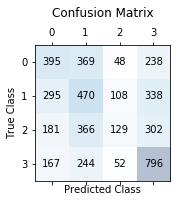


CV Accuracy: 39.560 +/- 0.930
Scores: [39.8  40.57 38.32]


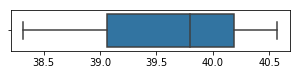


CV CohenKappa: 0.294 +/- 0.013
Scores: [0.278 0.309 0.294]


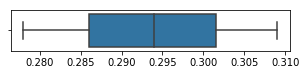

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,TP,FP,FN,Parameters,CV
0,NN 1 (defaults),36.73,0.2531,33.43,32.12,21.68,55.60,"[34.96, 31.89, 29.61, 44.93]","[351, 389, 212, 700]","[653, 831, 504, 858]","[699, 822, 766, 559]","{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (75,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000, 'mom...","{'Accuracy': (34.44, 0.55), 'CohenKappa': (0.217, 0.005)}"
1,"NN 2 (fn=logistic, nodes=15)",39.68,0.3172,38.10,34.85,17.59,62.83,"[37.0, 32.99, 33.46, 48.71]","[400, 422, 172, 791]","[681, 857, 342, 833]","[650, 789, 806, 468]","{'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000, ...","{'Accuracy': (38.8, 0.3), 'CohenKappa': (0.288, 0.01)}"
2,"NN 3 (fn=logistic, nodes=10, learn_rate=0.005)",40.55,0.3101,32.86,36.42,21.98,65.37,"[40.83, 32.89, 37.2, 47.46]","[345, 441, 215, 823]","[500, 900, 363, 911]","[705, 770, 763, 436]","{'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'max_iter': 1000, ...","{'Accuracy': (39.52, 1.07), 'CohenKappa': (0.292, 0.013)}"
3,"NN 4 (fn=logistic, nodes=10, learn_rate=0.005, alpha=1e-05)",39.80,0.3162,37.62,38.81,13.19,63.22,"[38.05, 32.44, 38.28, 47.55]","[395, 470, 129, 796]","[643, 979, 208, 878]","[655, 741, 849, 463]","{'activation': 'logistic', 'alpha': 1e-05, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'learning_rate_init': 0.005, 'max_iter': 1000, '...","{'Accuracy': (39.56, 0.93), 'CohenKappa': (0.294, 0.013)}"


In [50]:
#------------------------------------------------------------
# create model with the *BEST* parameters from the Grid Search
#------------------------------------------------------------
#------------------------------------------------------------
# create model
#------------------------------------------------------------
clf_nn4 = MLPClassifier(random_state=RANDOM_SEED, max_iter=1000,
                        activation='logistic',
                        hidden_layer_sizes=(10,),
                        learning_rate_init=0.005,
                        alpha=1e-05)

#------------------------------------------------------------
# fit model to training dataset
# assess model against test dataset
# cross-validate model against the training dataset (CV=3)
#------------------------------------------------------------
model              = clf_nn4
model_label        = 'NN 4 (fn=logistic, nodes=10, learn_rate=0.005, alpha=1e-05)'
model_results_list = model_results_nn

nn_results_df = clfmulti_fit_assess_CV(model_label, model, model_results_list, 
                                       features_train, target_train, 
                                       features_test,  target_test, cv_folds=3)
nn_results_df

In [51]:
#------------------------------------------------------------
# explore weights between nodes
#------------------------------------------------------------

# # input layer to hidden layer 1
# model.coefs_[0].shape
# # (75, 10)
# # 75 feature/inputs and 10 nodes in hidden layer 1

print("Weights Input => Hidden_1")
print("Min Weight:", model.coefs_[0].min())
print("Max Weight:", model.coefs_[0].max())

# # hidden layer 1 to output
# model.coefs_[1].shape
# # (10, 4)
# # 10 nodes in hidden layer 1, to 4 nodes in output layer (1 for each class)

print()
print("Weights Hidden_1 => Output")
print("Min Weight:", model.coefs_[1].min())
print("Max Weight:", model.coefs_[1].max())

Weights Input => Hidden_1
Min Weight: -46.99061286307573
Max Weight: 20.455663249508703

Weights Hidden_1 => Output
Min Weight: -4.861126011091371
Max Weight: 2.739226048170134


#### Quick Thoughts on Results
- The grid search suggested better results by lowering the alpha penalty (rather increasing the penalty to shrink the weights).  And lowering the penalty did increase range of the weights
  - Lower alpha = 1e-05, range of weight on layer 1 (-47 to 20)
  - Default alpha = 1e-04, range of weight on layer 1 (-42 to 19)
- Adjusting (lower) the L2 penalty does not move the needle - CohenKappa fractionally better, Accuracy fractionally worse.

In [52]:
nn_results_df.to_csv('results_nn.csv', index=False)

## Thoughts on Neural Network
A neural network solution falls within the top third but does not produce great results.  The best neural network is NN 2 using the logistic activation function and a small network of just 15 nodes in one hidden layer.  I tried a couple of attempts to make adjustments to the learning rate, number of nodes and L2 penalty with only marginal changes in Cohen's Kappa Score and/or overall Accuracy of the model.

<a id="Results"></a>
# Discussion of Results
[Table of Contents](#TOC)

The results of the best model for each of the twelve algorithms are presented in the DataFrame below.

The GTB 3 model achieved the highest Cohen's Kappa score.  But I think the **Stack 1 model is a little better**.  Its Cohen's Kappa score is a tiny bit lower (0.3828 vs. 0.3877 - a difference of 0.0049), but its overall Accuracy is better 44% vs. 43%.  The Stack 1 model had higher TPR on Class 3 (4+ months) 67.5% and Class 0 (first week) 46%, Class 1 (first month) 36% is a toss up and a little worse on Class 2 (2-3 months) 22.6%.  PPV is better on almost all of the classes.  I identified that the more harmful errors were false negatives on the slowest adoption class (Class 3).  Stack 1 has one of the lowest counts of FNs on the test dataset.

The Stack 1 model combined the models of the three strongest performing algorithms:  Gradient Tree Boosting (GTB 3), Random Forest (Forest 1) and the AdaBoost Decision Trees (Ada 2).

Different flavors of decision trees occupy the top half of the best results.  This dataset must be well-suited to decision trees. A small Neural Network is in the middle of the pack and the SVM and SGD flavors are below it with KNN bring up the rear.

Ensembles are hit on this problem.  Two boosting approaches (GTB and AdaBoost) where each iteration is attempting to correct misclassification in the previous pass.  A Random Forest combining 100 individual decision trees.  And finally, Stacking the three best models that in many ways teases out the best of each.

**To be useful, the approach needs more work.**  In my opinion, it would be difficult to manage an animal shelter where the length of stay estimate is accurate less than 45% of the time.  There is wide variation is the accuracy of the model on various adoption speed classes.  It is most reliable on the Class 3 (4+ months) with a TPR of 67.5% or identifying 2/3 of the longest stay animals and correct 53% of the time (PPV).  The models are then usually strongest on the shortest length of stay (Class 0 adopted in the first week) with TPR 46% (in the best case) and ranges down to mid-30's.  The toughest class to predict is the pets adopted in 2-3 months (Class 2).

Based on my domain expertise the results make sense.  It is probably easier to predict animals on the extremes - adopted fast (cute puppies and kittens) and animals with factors that make it clear it will take time to find a home.  In addition, in my EDA, there were several attributes that looked like there was a stronger association with Class 3 (e.g., multiple pets on profile (quantity and the mixed gender), adult pets (vs. a couple month old puppy/kitten),  fewer photos included in the pet's online profile, or being sterlized and/or vaccinated, which I suspect is a proxy for age).  I am also not surprised that the 2-3 month group (Class 2) is the toughest to predict.  I think of these as the "in-betweeners" where there may not be an obvious reason why they were not adopted quicker or fall into the slowest class.

In [4]:
results_best_df = pd.read_csv('results_best.csv')
results_best_df.sort_values(by=['CohenKappa', 'Accuracy'], ascending=[False, False])\
    [['Method', 'Accuracy', 'CohenKappa', 'TPR_0', 'TPR_1', 'TPR_2', 'TPR_3', 'PPV', 'FN', 'FP', 'Parameters']]

,Method,Accuracy,CohenKappa,TPR_0,TPR_1,TPR_2,TPR_3,PPV,FN,FP,Parameters
9,"GTB 3 (depth=8, features=25%; clfs=125)",43.06,0.3877,40.29,36.75,24.54,65.85,"[40.17, 35.32, 37.62, 53.59]","[627, 766, 738, 430]","[630, 815, 398, 718]","{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'max_features': 0.25, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_spli..."
10,Stack 1 (Best Algo),44.29,0.3828,45.90,36.25,22.60,67.51,"[40.23, 36.49, 43.94, 53.32]","[568, 772, 757, 409]","[716, 764, 282, 744]","{'estimators': [('gtb3', GradientBoostingClassifier(criterion='friedman_mse', init=None,\n learning_rate=0.1, loss='deviance', max_depth=8,\n max_features=0.25, max_leaf_nodes=None,\n min_impurity_decrease=0..."
2,Forest 1 (defaults),43.53,0.3724,41.52,35.92,23.82,67.83,"[41.17, 36.93, 37.4, 52.14]","[614, 776, 745, 405]","[623, 743, 390, 784]","{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight..."
8,"Ada 2 (DT, clf=75)",41.75,0.3327,38.86,36.09,21.68,65.21,"[40.16, 34.9, 37.72, 49.22]","[642, 774, 766, 438]","[608, 815, 350, 847]","{'algorithm': 'SAMME.R', 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrea..."
0,"Tree 4 (max_leaf=150, max_features=all)",39.28,0.3258,34.38,40.79,13.50,61.95,"[39.24, 32.02, 31.58, 48.24]","[689, 717, 846, 479]","[559, 1049, 286, 837]","{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 150, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, ..."
3,"XTree 2 (450 trees, max_features)",40.97,0.3254,38.86,36.83,25.56,58.70,"[38.42, 35.71, 33.38, 51.39]","[642, 765, 728, 520]","[654, 803, 499, 699]","{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_..."
11,"NN 2 (fn=logistic, nodes=15)",39.68,0.3172,38.10,34.85,17.59,62.83,"[37.0, 32.99, 33.46, 48.71]","[650, 789, 806, 468]","[681, 857, 342, 833]","{'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000, ..."
6,"SGD 4 (L1, alpha=0.0001)",38.91,0.2835,39.81,18.91,18.81,72.99,"[37.39, 31.46, 34.85, 43.27]","[632, 982, 794, 340]","[700, 499, 344, 1205]","{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter': None, 'n_iter_no_cha..."
4,SVM-L 2 (sq_hinge loss fn),39.46,0.2795,38.00,28.57,19.22,66.88,"[37.64, 33.53, 40.6, 43.34]","[651, 865, 790, 417]","[661, 686, 275, 1101]","{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 114, 'tol': 0.0001, 'verbose': 0}"
7,Bag 1 (SVM-L 2 (sq_hinge)),39.46,0.2793,38.00,28.57,19.22,66.88,"[37.61, 33.56, 40.6, 43.34]","[651, 865, 790, 417]","[662, 685, 275, 1101]","{'base_estimator__C': 1.0, 'base_estimator__class_weight': None, 'base_estimator__dual': True, 'base_estimator__fit_intercept': True, 'base_estimator__intercept_scaling': 1, 'base_estimator__loss': 'squared_hinge', 'base_estimator__max_iter': 100..."


## Project Learnings
I enjoyed tackling this project.  It provided multiple opportunities to develop my skills.

- This was my first multinomial classification project.  I have only tackled binary classification in the past.
  - I researched the metrics that were applicable and was introduced to Cohen's Kappa Score.
  - I experimented with which results were useful to consider and collect.  I processed the confusion matrix and classification report output to extract information by class.  With multiple classes, I was curious about how the model performed on each.
  - I generally needed to rework my common model functions to handle multiple class output or input in some fashion.
- Google's Natural Language API - I spent a little time getting familiar with the output provided.  I ended up adding the sentiment score, magnitude and length of the text description as features for the model to consider.  In the top models, all three attributes were among the top 10 features considered important.
- I did a little more initial feature engineering that I have typically tackled on projects.  
  - The breeds informartion seemed too granular to be helpful to the model so I consolidate breeds to the top 10 and then included an other category.
  - I also tried to make use of the RescuerID by calculating the number of profiles as an indication of whether the rescuer was an individual with 1-2 profiles, a small organization with a few profiles or a large rescue with many profiles.  Surprisingly, the NbrProfiles is the top feature in many of the best models.  I need to do more research into the results to determine if my engineered feature was helpful or skewed the the results in some unintended way.  I am surprised it is the top feature.
- I improved my tuning skills by running a different dataset through all twelve algorithms.  
  - I was more confident in making choices on the next steps to purse in the 2nd and 3rd models.
  - I did a better job on Neural Networks tuning a couple items at time to get an idea of the reasonable range of parameters that made sense for the dataset.  Previously, I tuned one parameter at time but knew they were interrelated.  I did not want to do a huge grid search on all the key parameters until I had some idea of what range of values made some sense for this dataset.
  - I picked up more details from the documentation. Where available, I explore any output available in the fitted models.  I was searching for any information from the current model to guide choices about the parameters to adjust in subsequent tuning passes.

Plus, some things to continue to work on ...
- I want to review some of the submissions on the Kaggle competition.  Hopefully, I can pick up some good ideas reviewing how others tackled feature engineering or some additional algorithms to research as well.
- I want to spend some time digging into the output of processing the photos by Google's Vision API.  I would like to better understand how I might incorporate that information as features in the model, plus gain some familiarity with the API in general.